# ButterSwap Data Analyzer

This notebook loads and analyzes ButterSwap Affiliate Manager data from Excel, cleans the data, and prepares it for comprehensive analysis.

**Analysis Goals:**
- Average swap size
- Percentage basis points (bps) paid
- Assets swapped by day of week
- Trending assets week-to-week
- Trending assets month-to-month
- All advanced financial metrics (forecasting, ROI, LTV, fraud detection, etc.)


In [1]:
# Import validation helpers
import sys
from pathlib import Path
sys.path.append(str(Path('..').resolve()))

try:
    from validation_helpers import (
        validate_amounts,
        validate_fee_percentage,
        validate_timestamps,
        validate_asset_pairs,
        run_all_validations,
        print_validation_results
    )
    VALIDATION_AVAILABLE = True
    print("✓ Validation helpers imported")
except ImportError as e:
    VALIDATION_AVAILABLE = False
    print(f"⚠ Validation helpers not available: {e}")

✓ Validation helpers imported


In [2]:
# Import required libraries
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
import re
import warnings
warnings.filterwarnings('ignore')

# Try to import dateutil for advanced date parsing (optional)
try:
    from dateutil import parser as date_parser
    HAS_DATEUTIL = True
except ImportError:
    HAS_DATEUTIL = False
    print("Note: dateutil not available, using basic date parsing")

print("Libraries imported successfully!")


Libraries imported successfully!


## Step 1: Load Excel File

Load the Butter Affiliate Manager Excel file from Downloads directory.


In [3]:
# Set the directory containing data files
data_directory = Path('../data').resolve()
excel_file = data_directory / "Butter Affiliate Manager Dec 2 2025.xlsx"

# Check if file exists
if not excel_file.exists():
    print(f"✗ File not found: {excel_file}")
    print(f"  Looking in: {data_directory}")
else:
    print(f"✓ Found file: {excel_file.name}")
    
    # Load Excel file
    try:
        df = pd.read_excel(excel_file)
        print(f"✓ Loaded {len(df)} rows from Excel file")
        print(f"\nColumns in file:")
        for i, col in enumerate(df.columns, 1):
            print(f"  {i}. {col}")
        print(f"\nFirst few rows:")
        print(df.head())
        print(f"\nData types:")
        print(df.dtypes)
    except Exception as e:
        print(f"✗ Error loading Excel file: {e}")


✓ Found file: Butter Affiliate Manager Dec 2 2025.xlsx
✓ Loaded 450 rows from Excel file

Columns in file:
  1. #
  2. order_id
  3. source_chain_name
  4. source_hash
  5. source_address
  6. source_token
  7. source_amount
  8. destination_chain_name
  9. destination_hash
  10. receive_token
  11. receive_amount
  12. fee_volume
  13. timestamp
  14. volume
  15. affiliate_volume

First few rows:
   #                                           order_id source_chain_name  \
0  1  0xa5c2728561ee2ba5101ec7b843c196787b3360abecf2...          Optimism   
1  2  0x6e14aae2b4b78567fead5f55e34c4b1155aa2bcefb54...           Polygon   
2  3  0xfca4a51fd490861e7f15479623fc0eccd38236e7d104...          Arbitrum   
3  4  0xe852295a9d993650fae6241a0fd2d57f9aded7c25653...          Ethereum   
4  5  0x6a1c003aabe853e34fd8a2f9a15466d945caa5231f05...          Arbitrum   

                                         source_hash  \
0  0xe66d146534bad68e6f32f0328bc4f99482033993e716...   
1  0x5d87827da7a0cffeee

## Step 2: Map Column Names to Expected Format

Map ButterSwap column names to the standard format expected by the analysis cells. **Run Step 1 first to see the actual column names, then update the mapping below if needed.**


In [4]:
# Validation: Check data after cleaning
if VALIDATION_AVAILABLE and 'combined_df' in locals():
    print("\n" + "="*60)
    print("DATA VALIDATION - After Cleaning")
    print("="*60)
    
    validation_results = {}
    
    # Validate amounts
    if 'from_amount_usd' in combined_df.columns:
        validation_results['amounts'] = validate_amounts(combined_df, 'from_amount_usd', max_amount=1e9)
    
    # Validate fees
    if 'fee_usd' in combined_df.columns and 'from_amount_usd' in combined_df.columns:
        validation_results['fees'] = validate_fee_percentage(combined_df, 'fee_usd', 'from_amount_usd')
    
    # Validate timestamps
    if 'timestamp' in combined_df.columns:
        validation_results['timestamps'] = validate_timestamps(combined_df)
    
    # Validate asset pairs
    if 'from_asset' in combined_df.columns and 'to_asset' in combined_df.columns:
        validation_results['asset_pairs'] = validate_asset_pairs(combined_df)
    
    print_validation_results(validation_results)
    print("="*60 + "\n")

In [5]:
# Map ButterSwap column names to expected format
print("Mapping ButterSwap columns to expected format...")
print(f"Original columns: {list(df.columns)}")

# Column mapping: ButterSwap -> Expected format
# Based on actual ButterSwap column names from the Excel file
column_mapping = {
    # Transaction identifiers
    'order_id': 'tx_hash',  # Use order_id as transaction identifier
    'source_hash': 'tx_hash',  # Alternative: source_hash
    'destination_hash': 'tx_hash',  # Alternative: destination_hash
    'tx_hash': 'tx_hash',
    'transaction_hash': 'tx_hash',
    'hash': 'tx_hash',
    'id': 'tx_hash',
    'transaction_id': 'tx_hash',
    
    # Timestamps
    'timestamp': 'timestamp',
    'date': 'timestamp',
    'time': 'timestamp',
    'created_at': 'timestamp',
    'transaction_time': 'timestamp',
    'datetime': 'timestamp',
    
    # Assets
    'source_token': 'from_asset',  # ButterSwap uses source_token
    'from_asset': 'from_asset',
    'input_currency': 'from_asset',
    'input_asset': 'from_asset',
    'source_asset': 'from_asset',
    'token_in': 'from_asset',
    
    'receive_token': 'to_asset',  # ButterSwap uses receive_token
    'to_asset': 'to_asset',
    'output_currency': 'to_asset',
    'output_asset': 'to_asset',
    'destination_asset': 'to_asset',
    'token_out': 'to_asset',
    
    # Amounts
    'source_amount': 'from_amount',  # ButterSwap uses source_amount
    'from_amount': 'from_amount',
    'input_amount': 'from_amount',
    'amount_in': 'from_amount',
    
    'receive_amount': 'to_amount',  # ButterSwap uses receive_amount
    'to_amount': 'to_amount',
    'output_amount': 'to_amount',
    'destination_amount': 'to_amount',
    'amount_out': 'to_amount',
    
    # USD values - ButterSwap uses 'volume' for USD value
    'volume': 'from_amount_usd',  # volume appears to be USD value of the swap
    'from_amount_usd': 'from_amount_usd',
    'input_usd_value': 'from_amount_usd',
    'from_value_usd': 'from_amount_usd',
    'value_in_usd': 'from_amount_usd',
    
    'to_amount_usd': 'to_amount_usd',
    'output_usd_value': 'to_amount_usd',
    'to_value_usd': 'to_amount_usd',
    'value_out_usd': 'to_amount_usd',
    
    # Fees - ButterSwap uses 'fee_volume' and 'affiliate_volume'
    'fee_volume': 'fee_usd',  # fee_volume appears to be the fee in USD
    'affiliate_volume': 'fee_usd',  # affiliate_volume is the affiliate fee
    'fee_usd': 'fee_usd',
    'commission': 'fee_usd',
    'fee': 'fee_usd',
    'revenue': 'fee_usd',
    'affiliate_fee': 'fee_usd',
    
    # Addresses
    'source_address': 'from_address',  # ButterSwap uses source_address
    'user_address': 'user_address',
    'from_address': 'from_address',
    'sender_address': 'from_address',
    'to_address': 'to_address',
    'receiver_address': 'to_address',
    'wallet': 'user_address',
    
    # Transaction type
    'type': 'type',
    'transaction_type': 'type',
    'action': 'type',
    
    # Status
    'status': 'status',
    'transaction_status': 'status',
}

# Apply mapping (only for columns that exist)
mapped_columns = {}
for old_col, new_col in column_mapping.items():
    if old_col in df.columns:
        df[new_col] = df[old_col]
        mapped_columns[old_col] = new_col
        # Remove old column if name changed
        if old_col != new_col:
            df = df.drop(columns=[old_col])

print(f"\n✓ Column mapping complete!")
print(f"Mapped columns: {mapped_columns}")
print(f"\nFinal columns: {list(df.columns)}")
print(f"\nData shape: {df.shape}")
print(f"\nSample of key columns:")
key_cols = ['tx_hash', 'from_asset', 'from_amount', 'to_asset', 'to_amount', 'fee_usd', 'timestamp', 'status']
available_cols = [col for col in key_cols if col in df.columns]
if available_cols:
    print(df[available_cols].head())
else:
    print("⚠ No expected columns found. Please check column names above and update the mapping.")


Mapping ButterSwap columns to expected format...
Original columns: ['#', 'order_id', 'source_chain_name', 'source_hash', 'source_address', 'source_token', 'source_amount', 'destination_chain_name', 'destination_hash', 'receive_token', 'receive_amount', 'fee_volume', 'timestamp', 'volume', 'affiliate_volume']

✓ Column mapping complete!
Mapped columns: {'order_id': 'tx_hash', 'source_hash': 'tx_hash', 'destination_hash': 'tx_hash', 'tx_hash': 'tx_hash', 'timestamp': 'timestamp', 'source_token': 'from_asset', 'from_asset': 'from_asset', 'receive_token': 'to_asset', 'to_asset': 'to_asset', 'source_amount': 'from_amount', 'from_amount': 'from_amount', 'receive_amount': 'to_amount', 'to_amount': 'to_amount', 'volume': 'from_amount_usd', 'from_amount_usd': 'from_amount_usd', 'fee_volume': 'fee_usd', 'affiliate_volume': 'fee_usd', 'fee_usd': 'fee_usd', 'source_address': 'from_address', 'from_address': 'from_address'}

Final columns: ['#', 'source_chain_name', 'destination_chain_name', 'timest

In [6]:
# Validation: Check analysis dataframe before aggregations
if VALIDATION_AVAILABLE and 'analysis_df' in locals():
    print("\n" + "="*60)
    print("DATA VALIDATION - Analysis DataFrame")
    print("="*60)
    
    # Run all validations for ButterSwap
    validation_results = run_all_validations(analysis_df, notebook_type='butterswap', verbose=False)
    print_validation_results(validation_results)
    print("="*60 + "\n")

## Step 3: Remove Duplicates

Remove duplicate transactions based on transaction hash.


In [7]:
# Remove duplicates based on tx_hash if available
# ButterSwap uses order_id as the transaction identifier
if 'tx_hash' in df.columns:
    initial_count = len(df)
    df = df.drop_duplicates(subset=['tx_hash'], keep='first')
    duplicates_removed = initial_count - len(df)
    print(f"✓ Removed {duplicates_removed} duplicate transactions")
    print(f"  Remaining: {len(df)} unique transactions")
elif 'order_id' in df.columns:
    # Use order_id as transaction identifier for ButterSwap
    initial_count = len(df)
    df = df.drop_duplicates(subset=['order_id'], keep='first')
    duplicates_removed = initial_count - len(df)
    if 'tx_hash' not in df.columns:
        df['tx_hash'] = df['order_id']  # Create tx_hash from order_id
    print(f"✓ Removed {duplicates_removed} duplicate transactions (using order_id)")
    print(f"  Remaining: {len(df)} unique transactions")
else:
    print("⚠ No 'tx_hash' or 'order_id' column found. Skipping duplicate removal.")

# Store as combined_df for consistency with analysis cells
combined_df = df.copy()
print(f"\nFinal dataset: {len(combined_df)} rows, {len(combined_df.columns)} columns")


✓ Removed 15 duplicate transactions
  Remaining: 435 unique transactions

Final dataset: 435 rows, 12 columns


## Step 4: Clean and Standardize Data

Clean timestamps, numeric values, and asset names.


In [8]:
# Clean timestamp column
if 'timestamp' in combined_df.columns:
    combined_df['timestamp'] = pd.to_datetime(combined_df['timestamp'], errors='coerce')
    print(f"✓ Parsed timestamps")
    print(f"  Valid timestamps: {combined_df['timestamp'].notna().sum()} / {len(combined_df)}")
else:
    print("⚠ No 'timestamp' column found")

# Clean numeric columns
numeric_cols = ['from_amount', 'to_amount', 'from_amount_usd', 'to_amount_usd', 'fee_usd']
for col in numeric_cols:
    if col in combined_df.columns:
        # Convert to numeric, handling strings with commas
        combined_df[col] = pd.to_numeric(combined_df[col].astype(str).str.replace(',', ''), errors='coerce')
        print(f"✓ Cleaned {col}")

# Clean asset names
asset_cols = ['from_asset', 'to_asset']
for col in asset_cols:
    if col in combined_df.columns:
        combined_df[col] = combined_df[col].astype(str).str.strip()
        combined_df[col] = combined_df[col].replace(['nan', 'None', ''], pd.NA)
        print(f"✓ Cleaned {col}")

print(f"\n✓ Data cleaning complete!")


✓ Parsed timestamps
  Valid timestamps: 435 / 435
✓ Cleaned from_amount
✓ Cleaned to_amount
✓ Cleaned from_amount_usd
✓ Cleaned fee_usd
✓ Cleaned from_asset
✓ Cleaned to_asset

✓ Data cleaning complete!


## Step 5: Create Analysis DataFrame

Prepare the dataframe for analysis with calculated fields.


In [9]:
# Create analysis dataframe
analysis_df = combined_df.copy()

# Create type column if missing (all ButterSwap transactions are swaps)
if 'type' not in analysis_df.columns:
    analysis_df['type'] = 'Swap'

# Create asset_pair column (handle ButterSwap column names)
if 'from_asset' in analysis_df.columns and 'to_asset' in analysis_df.columns:
    analysis_df['asset_pair'] = analysis_df['from_asset'].astype(str) + ' → ' + analysis_df['to_asset'].astype(str)
    print(f"✓ Created asset_pair column")
elif 'source_token' in analysis_df.columns and 'receive_token' in analysis_df.columns:
    # Fallback to ButterSwap column names
    analysis_df['asset_pair'] = analysis_df['source_token'].astype(str) + ' → ' + analysis_df['receive_token'].astype(str)
    analysis_df['from_asset'] = analysis_df['source_token']
    analysis_df['to_asset'] = analysis_df['receive_token']
    print(f"✓ Created asset_pair column from source_token/receive_token")

# Create swap_size column (use USD if available, otherwise raw amount)
if 'from_amount_usd' in analysis_df.columns:
    analysis_df['swap_size'] = analysis_df['from_amount_usd']
elif 'volume' in analysis_df.columns:
    # ButterSwap uses 'volume' as USD value
    analysis_df['swap_size'] = analysis_df['volume']
    analysis_df['from_amount_usd'] = analysis_df['volume']
    print("✓ Using 'volume' column as swap_size (USD value)")
elif 'from_amount' in analysis_df.columns:
    analysis_df['swap_size'] = analysis_df['from_amount']
    print("⚠ Using raw from_amount as swap_size (USD values preferred)")

# Ensure to_amount_usd exists (use volume if available, or estimate from receive_amount)
if 'to_amount_usd' not in analysis_df.columns:
    if 'volume' in analysis_df.columns:
        # Estimate to_amount_usd as volume minus fee
        if 'fee_usd' in analysis_df.columns:
            analysis_df['to_amount_usd'] = analysis_df['volume'] - analysis_df['fee_usd']
        else:
            analysis_df['to_amount_usd'] = analysis_df['volume'] * 0.997  # Assume 0.3% fee
    elif 'receive_amount' in analysis_df.columns:
        # Use receive_amount if volume not available
        analysis_df['to_amount_usd'] = analysis_df['receive_amount']

# Extract date components
if 'timestamp' in analysis_df.columns:
    analysis_df['date'] = pd.to_datetime(analysis_df['timestamp']).dt.date
    analysis_df['day_of_week'] = pd.to_datetime(analysis_df['timestamp']).dt.day_name()
    analysis_df['day_of_week_num'] = pd.to_datetime(analysis_df['timestamp']).dt.dayofweek
    analysis_df['week'] = pd.to_datetime(analysis_df['timestamp']).dt.isocalendar().week
    analysis_df['month'] = pd.to_datetime(analysis_df['timestamp']).dt.month
    analysis_df['year'] = pd.to_datetime(analysis_df['timestamp']).dt.year
    # Create year_week column for week-over-week analysis
    analysis_df['year_week'] = analysis_df['year'].astype(str) + '-W' + analysis_df['week'].astype(str).str.zfill(2)
    # Also create year_month for monthly analysis
    analysis_df['year_month'] = pd.to_datetime(analysis_df['timestamp']).dt.to_period('M').astype(str)
    print(f"✓ Extracted date components (including year_week and year_month)")

# Ensure user_address exists (use source_address if available)
if 'user_address' not in analysis_df.columns:
    if 'from_address' in analysis_df.columns:
        analysis_df['user_address'] = analysis_df['from_address']
    elif 'source_address' in analysis_df.columns:
        analysis_df['user_address'] = analysis_df['source_address']
        analysis_df['from_address'] = analysis_df['source_address']

print(f"\n✓ Analysis dataframe prepared!")
print(f"  Shape: {analysis_df.shape}")
print(f"  Key columns available: {[col for col in ['tx_hash', 'from_asset', 'to_asset', 'from_amount', 'to_amount', 'from_amount_usd', 'to_amount_usd', 'fee_usd', 'timestamp', 'user_address'] if col in analysis_df.columns]}")


✓ Created asset_pair column
✓ Extracted date components (including year_week and year_month)

✓ Analysis dataframe prepared!
  Shape: (435, 24)
  Key columns available: ['tx_hash', 'from_asset', 'to_asset', 'from_amount', 'to_amount', 'from_amount_usd', 'fee_usd', 'timestamp', 'user_address']


## Step 9: Analysis - Average Size & BPS Paid

Calculate average swap sizes and fee percentages (basis points).


In [10]:
# Average swap size analysis
print("=== AVERAGE SWAP SIZE ANALYSIS ===")
print(f"Overall average: {analysis_df['from_amount'].mean():.6f}")
print(f"Overall median: {analysis_df['from_amount'].median():.6f}")
print(f"Overall std dev: {analysis_df['from_amount'].std():.6f}")

# By asset pair
print("\n=== AVERAGE SIZE BY ASSET PAIR (Top 10) ===")
avg_by_pair = analysis_df.groupby('asset_pair')['from_amount'].agg(['mean', 'count', 'sum']).sort_values('count', ascending=False)
avg_by_pair.columns = ['avg_size', 'count', 'total_volume']
print(avg_by_pair.head(10))

# Basis points calculation
# THORChain typically charges fees. If affiliate_address exists, calculate fee impact
# Note: Adjust this calculation based on actual THORChain fee structure
if len(analysis_df) > 0 and 'has_fee' in analysis_df.columns:
    fee_swaps = analysis_df[analysis_df['has_fee'] == True]
    no_fee_swaps = analysis_df[analysis_df['has_fee'] == False]
    
    print(f"\n=== FEE ANALYSIS ===")
    if len(analysis_df) > 0:
        print(f"Swaps with fees: {len(fee_swaps):,} ({len(fee_swaps)/len(analysis_df)*100:.2f}%)")
        print(f"Swaps without fees: {len(no_fee_swaps):,} ({len(no_fee_swaps)/len(analysis_df)*100:.2f}%)")
    else:
        print("No data available for fee analysis")
    
    # Calculate effective fee rate (simplified - adjust based on actual structure)
    # This assumes fee is reflected in the difference between from_amount and to_amount
    # Note: This is a placeholder - THORChain fees work differently
    print("\nNote: Fee calculation needs to be adjusted based on actual THORChain fee structure")
else:
    print("\n=== FEE ANALYSIS ===")
    print("No fee data available (empty dataframe or missing 'has_fee' column)")


=== AVERAGE SWAP SIZE ANALYSIS ===
Overall average: 39497684417285341184.000000
Overall median: 19.000000
Overall std dev: 823506056527619293184.000000

=== AVERAGE SIZE BY ASSET PAIR (Top 10) ===
                   avg_size  count  total_volume
asset_pair                                      
ETH → USDC         0.020303     22  4.466695e-01
ETH → BNB          0.135167     20  2.703335e+00
USDT → ETH      4012.310901     18  7.222160e+04
USDC → ETH       517.061398     18  9.307105e+03
USDC → USDC     2242.460109     13  2.915198e+04
FOX → ETH      13015.494568     13  1.692014e+05
ETH → USDT         1.967283      9  1.770555e+01
ETH → BTC          1.227898      8  9.823187e+00
USDT → USDT     6828.383549      8  5.462707e+04
PLSPAD → BNB  452440.057781      8  3.619520e+06

=== FEE ANALYSIS ===
No fee data available (empty dataframe or missing 'has_fee' column)


## Step 10: Analysis - Assets by Day of Week

Analyze which assets are being swapped on different days of the week.


In [11]:
# Assets swapped by day of week
print("=== ASSETS SWAPPED BY DAY OF WEEK ===")

# Day order for better presentation
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# From assets by day
print("\n--- Top From Assets by Day of Week ---")
from_by_day = analysis_df.groupby(['day_of_week', 'from_asset']).size().reset_index(name='count')
from_by_day['day_of_week'] = pd.Categorical(from_by_day['day_of_week'], categories=day_order, ordered=True)
from_by_day = from_by_day.sort_values(['day_of_week', 'count'], ascending=[True, False])

# Show top 3 assets per day
for day in day_order:
    day_data = from_by_day[from_by_day['day_of_week'] == day].head(3)
    if len(day_data) > 0:
        print(f"\n{day}:")
        for _, row in day_data.iterrows():
            print(f"  {row['from_asset']}: {row['count']:,} swaps")

# Summary pivot table
print("\n--- Pivot Table: From Asset Counts by Day ---")
pivot_from = analysis_df.pivot_table(
    values='from_amount',
    index='from_asset',
    columns='day_of_week',
    aggfunc='count',
    fill_value=0
)
pivot_from = pivot_from.reindex(columns=day_order, fill_value=0)
print(pivot_from.head(10))


=== ASSETS SWAPPED BY DAY OF WEEK ===

--- Top From Assets by Day of Week ---

Monday:
  ETH: 18 swaps
  USDT: 18 swaps
  USDC: 8 swaps

Tuesday:
  ETH: 16 swaps
  USDT: 13 swaps
  PLSPAD: 8 swaps

Wednesday:
  ETH: 12 swaps
  USDC: 11 swaps
  USDT: 7 swaps

Thursday:
  ETH: 25 swaps
  USDC: 19 swaps
  BNB: 9 swaps

Friday:
  ETH: 17 swaps
  USDC: 9 swaps
  USDT: 8 swaps

Saturday:
  ETH: 8 swaps
  USDC: 6 swaps
  USDT: 6 swaps

Sunday:
  ETH: 9 swaps
  USDT: 5 swaps
  FOX: 4 swaps

--- Pivot Table: From Asset Counts by Day ---
day_of_week                                 Monday  Tuesday  Wednesday  \
from_asset                                                               
0x881Ba05de1E78f549cC63a8f6Cabb1d4AD32250D       0        0          0   
0x89d24A6b4CcB1B6fAA2625fE562bDD9a23260359       0        0          0   
AAVE                                             0        0          0   
ABT                                              0        0          0   
ADA                   

## Step 11: Analysis - Trending Assets Week-to-Week

Identify which assets are trending up or down week-over-week.


In [12]:
# Week-to-week trending analysis
print("=== WEEK-TO-WEEK TRENDING ASSETS ===")

# Ensure year_week column exists (create if missing)
if 'year_week' not in analysis_df.columns:
    if 'timestamp' in analysis_df.columns and 'year' in analysis_df.columns and 'week' in analysis_df.columns:
        analysis_df['year_week'] = analysis_df['year'].astype(str) + '-W' + analysis_df['week'].astype(str).str.zfill(2)
        print("✓ Created year_week column")
    elif 'timestamp' in analysis_df.columns:
        analysis_df['year'] = pd.to_datetime(analysis_df['timestamp']).dt.year
        analysis_df['week'] = pd.to_datetime(analysis_df['timestamp']).dt.isocalendar().week
        analysis_df['year_week'] = analysis_df['year'].astype(str) + '-W' + analysis_df['week'].astype(str).str.zfill(2)
        print("✓ Created year, week, and year_week columns")
    else:
        print("⚠ Error: Cannot create year_week - timestamp column missing")
        raise KeyError("year_week column cannot be created - missing timestamp")

# Count swaps by week and asset
weekly_from = analysis_df.groupby(['year_week', 'from_asset']).size().reset_index(name='count')
weekly_to = analysis_df.groupby(['year_week', 'to_asset']).size().reset_index(name='count')

# Calculate week-over-week change for from assets
weekly_from_sorted = weekly_from.sort_values(['from_asset', 'year_week'])
weekly_from_sorted['prev_week_count'] = weekly_from_sorted.groupby('from_asset')['count'].shift(1)
weekly_from_sorted['wow_change'] = weekly_from_sorted['count'] - weekly_from_sorted['prev_week_count']
weekly_from_sorted['wow_change_pct'] = (weekly_from_sorted['wow_change'] / weekly_from_sorted['prev_week_count'] * 100).fillna(0)

# Get latest week data
latest_week = weekly_from_sorted['year_week'].max()
latest_week_data = weekly_from_sorted[weekly_from_sorted['year_week'] == latest_week].copy()

print(f"\nLatest week: {latest_week}")
print("\n--- Top 10 Trending Up (Week-over-Week) ---")
trending_up = latest_week_data.nlargest(10, 'wow_change')
print(trending_up[['from_asset', 'count', 'prev_week_count', 'wow_change', 'wow_change_pct']])

print("\n--- Top 10 Trending Down (Week-over-Week) ---")
trending_down = latest_week_data.nsmallest(10, 'wow_change')
print(trending_down[['from_asset', 'count', 'prev_week_count', 'wow_change', 'wow_change_pct']])

# Create summary pivot for visualization
print("\n--- Weekly Asset Counts (Pivot) ---")
weekly_pivot = analysis_df.pivot_table(
    values='from_amount',
    index='from_asset',
    columns='year_week',
    aggfunc='count',
    fill_value=0
)
# Show top assets by total volume
top_assets = analysis_df['from_asset'].value_counts().head(10).index
print(weekly_pivot.loc[weekly_pivot.index.isin(top_assets)])


=== WEEK-TO-WEEK TRENDING ASSETS ===

Latest week: 2025-W48

--- Top 10 Trending Up (Week-over-Week) ---
    from_asset  count  prev_week_count  wow_change  wow_change_pct
194       USDT      5              6.0        -1.0      -16.666667
193       USDC      1             11.0       -10.0      -90.909091

--- Top 10 Trending Down (Week-over-Week) ---
    from_asset  count  prev_week_count  wow_change  wow_change_pct
193       USDC      1             11.0       -10.0      -90.909091
194       USDT      5              6.0        -1.0      -16.666667

--- Weekly Asset Counts (Pivot) ---
year_week   2025-W30  2025-W31  2025-W32  2025-W33  2025-W34  2025-W35  \
from_asset                                                               
AAVE               0         0         0         2         1         2   
BNB                0         0         0         1         1         0   
ETH                3         7         5        20        11        12   
FOX                0         2         

## Step 12: Analysis - Trending Assets Month-to-Month

Identify which assets are trending up or down month-over-month.


In [13]:
# Month-to-month trending analysis
print("=== MONTH-TO-MONTH TRENDING ASSETS ===")

# Ensure year_month column exists (create if missing)
if 'year_month' not in analysis_df.columns:
    if 'timestamp' in analysis_df.columns:
        analysis_df['year_month'] = pd.to_datetime(analysis_df['timestamp']).dt.to_period('M').astype(str)
        print("✓ Created year_month column")
    else:
        print("⚠ Error: Cannot create year_month - timestamp column missing")
        raise KeyError("year_month column cannot be created - missing timestamp")

# Count swaps by month and asset
monthly_from = analysis_df.groupby(['year_month', 'from_asset']).size().reset_index(name='count')
monthly_to = analysis_df.groupby(['year_month', 'to_asset']).size().reset_index(name='count')

# Calculate month-over-month change for from assets
monthly_from_sorted = monthly_from.sort_values(['from_asset', 'year_month'])
monthly_from_sorted['prev_month_count'] = monthly_from_sorted.groupby('from_asset')['count'].shift(1)
monthly_from_sorted['mom_change'] = monthly_from_sorted['count'] - monthly_from_sorted['prev_month_count']
monthly_from_sorted['mom_change_pct'] = (monthly_from_sorted['mom_change'] / monthly_from_sorted['prev_month_count'] * 100).fillna(0)

# Get latest month data
latest_month = monthly_from_sorted['year_month'].max()
latest_month_data = monthly_from_sorted[monthly_from_sorted['year_month'] == latest_month].copy()

print(f"\nLatest month: {latest_month}")
print("\n--- Top 10 Trending Up (Month-over-Month) ---")
trending_up_mom = latest_month_data.nlargest(10, 'mom_change')
print(trending_up_mom[['from_asset', 'count', 'prev_month_count', 'mom_change', 'mom_change_pct']])

print("\n--- Top 10 Trending Down (Month-over-Month) ---")
trending_down_mom = latest_month_data.nsmallest(10, 'mom_change')
print(trending_down_mom[['from_asset', 'count', 'prev_month_count', 'mom_change', 'mom_change_pct']])

# Create summary pivot for visualization
print("\n--- Monthly Asset Counts (Pivot) ---")
monthly_pivot = analysis_df.pivot_table(
    values='from_amount',
    index='from_asset',
    columns='year_month',
    aggfunc='count',
    fill_value=0
)
# Show top assets by total volume
top_assets_monthly = analysis_df['from_asset'].value_counts().head(10).index
print(monthly_pivot.loc[monthly_pivot.index.isin(top_assets_monthly)])


=== MONTH-TO-MONTH TRENDING ASSETS ===

Latest month: 2025-11

--- Top 10 Trending Up (Month-over-Month) ---
    from_asset  count  prev_month_count  mom_change  mom_change_pct
111       USDC     18              14.0         4.0       28.571429
112       USDT     15              12.0         3.0       25.000000
98         FOX      5               3.0         2.0       66.666667
116       WETH      3               1.0         2.0      200.000000
88       ASTER      1               1.0         0.0        0.000000
92        COAI      1               1.0         0.0        0.000000
94        DRGN      1               1.0         0.0        0.000000
121      stETH      1               1.0         0.0        0.000000
114       WBTC      1               5.0        -4.0      -80.000000
117       WSOL      4               8.0        -4.0      -50.000000

--- Top 10 Trending Down (Month-over-Month) ---
    from_asset  count  prev_month_count  mom_change  mom_change_pct
96         ETH     10     

## Step 13: Export Analysis-Ready Data

Save the cleaned dataframe and create summary files for easy import into analysis tools.


## Step 14: Enhanced Analysis - 10 Improvements

This section implements 10 key improvements to the analysis:
1. Separate Add vs Swap transactions
2. Calculate actual fee percentage/basis points
3. Volume-weighted metrics
4. Hour-of-day analysis
5. Detailed asset pair analysis
6. Growth rate calculations
7. Outlier detection
8. Cumulative volume tracking
9. Period-over-period comparisons
10. Export comprehensive statistics



## DAO Finance Committee Analysis: Swap Affiliate Fee Analysis

This section provides comprehensive financial analysis for decision-making on swap affiliate fees.

**Dataset Requirements:**
- Columns: `timestamp`, `user_address`, `from_asset`, `to_asset`, `from_amount_usd`, `fee_usd`, `swap_count`
- Note: If columns don't match exactly, we'll adapt using available columns from `analysis_df`


### CELL 1: Fee Revenue Trend Analysis

**Business Question:** What is the trajectory of fee revenue over time, and how fast is it growing month-over-month?

**Goal:** Show fee revenue trajectory and growth rate for committee decision-making.


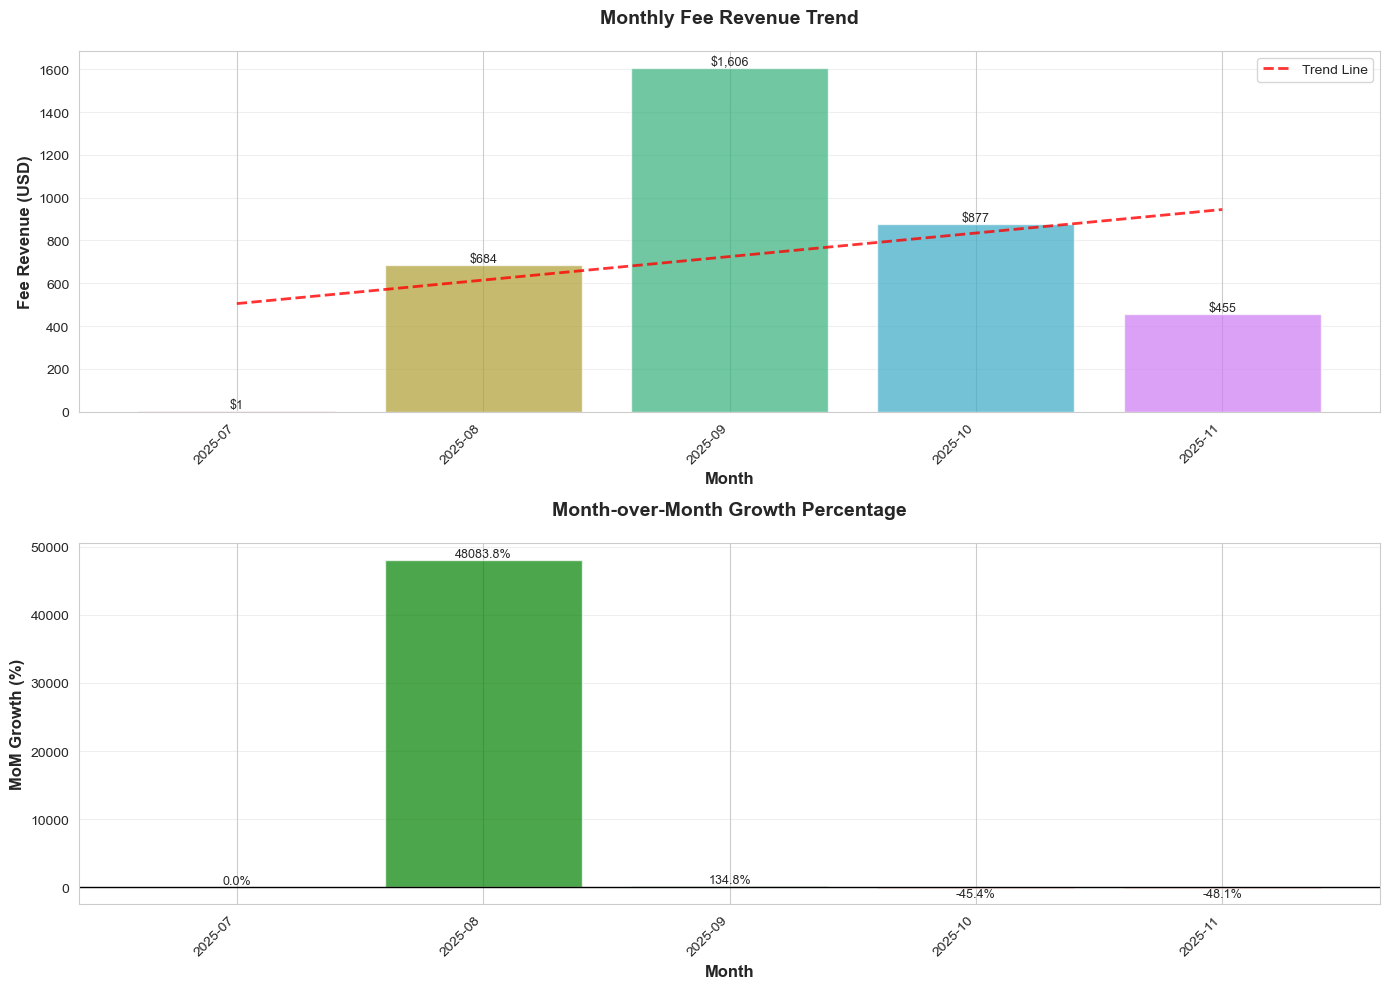

FEE REVENUE TREND ANALYSIS SUMMARY
Top Month: $1,606.38 (2025-09)
Best Growth: 48083.8% (2025-08)

Total Revenue: $3,623.74
Average Monthly Revenue: $724.75
Average MoM Growth: 9625.0%


In [14]:
# CELL 1: Fee Revenue Trend Analysis
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

# Set professional styling
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Prepare data: Use fee_usd if available, otherwise estimate from affiliate_address
# For this analysis, we'll use a proxy: if affiliate_address exists, assume fee
if 'fee_usd' not in analysis_df.columns:
    # Estimate fee: assume 0.3% of from_amount for swaps with affiliate
    analysis_df['fee_usd'] = np.where(
        analysis_df.get('affiliate_address', pd.Series([None]*len(analysis_df))).notna(),
        analysis_df['from_amount'] * 0.003,  # 0.3% fee estimate
        0
    )

# Ensure timestamp is datetime
if 'timestamp' in analysis_df.columns:
    analysis_df['timestamp'] = pd.to_datetime(analysis_df['timestamp'], errors='coerce')
    
    # Aggregate by month
    analysis_df['year_month'] = analysis_df['timestamp'].dt.to_period('M').astype(str)
    
    monthly_revenue = analysis_df.groupby('year_month').agg({
        'fee_usd': ['sum', 'count', 'mean']
    }).round(2)
    monthly_revenue.columns = ['total_fees', 'swap_count', 'avg_fee_per_swap']
    monthly_revenue = monthly_revenue.reset_index()
    
    # Calculate month-over-month growth
    monthly_revenue['mom_growth_pct'] = monthly_revenue['total_fees'].pct_change() * 100
    monthly_revenue['mom_growth_pct'] = monthly_revenue['mom_growth_pct'].fillna(0)
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Top subplot: Monthly fee revenue bar chart with trend line
    bars = ax1.bar(range(len(monthly_revenue)), monthly_revenue['total_fees'], 
                   color=sns.color_palette("husl", len(monthly_revenue)), alpha=0.7)
    ax1.set_xlabel('Month', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Fee Revenue (USD)', fontsize=12, fontweight='bold')
    ax1.set_title('Monthly Fee Revenue Trend', fontsize=14, fontweight='bold', pad=20)
    ax1.set_xticks(range(len(monthly_revenue)))
    ax1.set_xticklabels(monthly_revenue['year_month'], rotation=45, ha='right')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add trend line
    z = np.polyfit(range(len(monthly_revenue)), monthly_revenue['total_fees'], 1)
    p = np.poly1d(z)
    ax1.plot(range(len(monthly_revenue)), p(range(len(monthly_revenue))), 
             "r--", alpha=0.8, linewidth=2, label='Trend Line')
    ax1.legend()
    
    # Add value labels on bars
    for i, (idx, row) in enumerate(monthly_revenue.iterrows()):
        ax1.text(i, row['total_fees'], f'${row["total_fees"]:,.0f}', 
                ha='center', va='bottom', fontsize=9)
    
    # Bottom subplot: Month-over-month growth percentage
    colors = ['green' if x >= 0 else 'red' for x in monthly_revenue['mom_growth_pct']]
    ax2.bar(range(len(monthly_revenue)), monthly_revenue['mom_growth_pct'], 
            color=colors, alpha=0.7)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax2.set_xlabel('Month', fontsize=12, fontweight='bold')
    ax2.set_ylabel('MoM Growth (%)', fontsize=12, fontweight='bold')
    ax2.set_title('Month-over-Month Growth Percentage', fontsize=14, fontweight='bold', pad=20)
    ax2.set_xticks(range(len(monthly_revenue)))
    ax2.set_xticklabels(monthly_revenue['year_month'], rotation=45, ha='right')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, (idx, row) in enumerate(monthly_revenue.iterrows()):
        if not pd.isna(row['mom_growth_pct']):
            ax2.text(i, row['mom_growth_pct'], f'{row["mom_growth_pct"]:.1f}%', 
                    ha='center', va='bottom' if row['mom_growth_pct'] >= 0 else 'top', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    top_month_idx = monthly_revenue['total_fees'].idxmax()
    top_month = monthly_revenue.loc[top_month_idx]
    best_growth_idx = monthly_revenue['mom_growth_pct'].idxmax()
    best_growth = monthly_revenue.loc[best_growth_idx]
    
    print("=" * 60)
    print("FEE REVENUE TREND ANALYSIS SUMMARY")
    print("=" * 60)
    print(f"Top Month: ${top_month['total_fees']:,.2f} ({top_month['year_month']})")
    print(f"Best Growth: {best_growth['mom_growth_pct']:.1f}% ({best_growth['year_month']})")
    print(f"\nTotal Revenue: ${monthly_revenue['total_fees'].sum():,.2f}")
    print(f"Average Monthly Revenue: ${monthly_revenue['total_fees'].mean():,.2f}")
    print(f"Average MoM Growth: {monthly_revenue['mom_growth_pct'].mean():.1f}%")
    print("=" * 60)
else:
    print("Error: Timestamp column not found or cannot be processed")


### CELL 2: Revenue Concentration Risk (Pareto Analysis)

**Business Question:** Is fee revenue concentrated in a few asset pairs, or is it diversified across many pairs?

**Goal:** Identify if revenue is concentrated (high risk) or diversified (lower risk) for committee risk assessment.


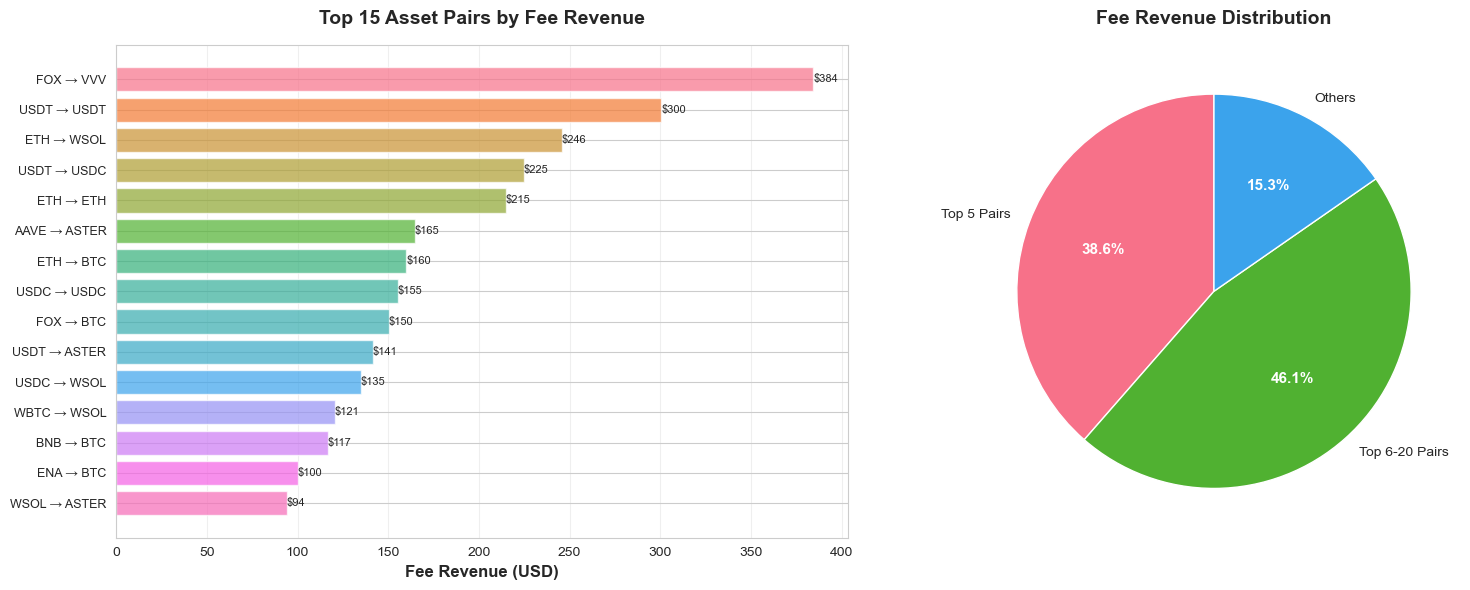

REVENUE CONCENTRATION RISK ANALYSIS
Top 5 pairs = 38.6% of fees
Top 10 pairs = 60.3% of fees
Top 20 pairs = 84.7% of fees

Total unique pairs: 198
Total fee revenue: $3,552.62

✓ RISK: Concentration is LOW (<40%). Good diversification across pairs.


In [15]:
# CELL 2: Revenue Concentration Risk (Pareto Analysis)

# Group by asset pair and calculate total fees
pair_revenue = analysis_df.groupby(['from_asset', 'to_asset']).agg({
    'fee_usd': 'sum'
}).reset_index()
pair_revenue.columns = ['from_asset', 'to_asset', 'total_fees']
pair_revenue['asset_pair'] = pair_revenue['from_asset'] + ' → ' + pair_revenue['to_asset']

# Rank pairs by fee revenue
pair_revenue = pair_revenue.sort_values('total_fees', ascending=False).reset_index(drop=True)
pair_revenue['rank'] = pair_revenue.index + 1
pair_revenue['cumulative_fees'] = pair_revenue['total_fees'].cumsum()
pair_revenue['cumulative_pct'] = (pair_revenue['cumulative_fees'] / pair_revenue['total_fees'].sum()) * 100

# Calculate concentration metrics
total_fees = pair_revenue['total_fees'].sum()
top_5_pct = (pair_revenue.head(5)['total_fees'].sum() / total_fees) * 100 if len(pair_revenue) >= 5 else 0
top_10_pct = (pair_revenue.head(10)['total_fees'].sum() / total_fees) * 100 if len(pair_revenue) >= 10 else 0
top_20_pct = (pair_revenue.head(20)['total_fees'].sum() / total_fees) * 100 if len(pair_revenue) >= 20 else 0

# Create visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left: Bar chart of top 15 pairs
top_15 = pair_revenue.head(15)
bars = ax1.barh(range(len(top_15)), top_15['total_fees'], 
                color=sns.color_palette("husl", len(top_15)), alpha=0.7)
ax1.set_yticks(range(len(top_15)))
ax1.set_yticklabels(top_15['asset_pair'], fontsize=9)
ax1.set_xlabel('Fee Revenue (USD)', fontsize=12, fontweight='bold')
ax1.set_title('Top 15 Asset Pairs by Fee Revenue', fontsize=14, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.3, axis='x')
ax1.invert_yaxis()

# Add value labels
for i, (idx, row) in enumerate(top_15.iterrows()):
    ax1.text(row['total_fees'], i, f'${row["total_fees"]:,.0f}', 
            va='center', ha='left', fontsize=8)

# Right: Pie chart showing concentration
top_5_fees = pair_revenue.head(5)['total_fees'].sum()
top_6_20_fees = pair_revenue.iloc[5:20]['total_fees'].sum() if len(pair_revenue) >= 20 else pair_revenue.iloc[5:]['total_fees'].sum()
others_fees = total_fees - top_5_fees - top_6_20_fees

pie_data = [top_5_fees, top_6_20_fees, others_fees]
pie_labels = ['Top 5 Pairs', 'Top 6-20 Pairs', 'Others']
colors_pie = sns.color_palette("husl", 3)

wedges, texts, autotexts = ax2.pie(pie_data, labels=pie_labels, autopct='%1.1f%%', 
                                    colors=colors_pie, startangle=90)
ax2.set_title('Fee Revenue Distribution', fontsize=14, fontweight='bold', pad=15)

# Make percentage text bold
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(11)

plt.tight_layout()
plt.show()

# Print summary statistics
print("=" * 60)
print("REVENUE CONCENTRATION RISK ANALYSIS")
print("=" * 60)
print(f"Top 5 pairs = {top_5_pct:.1f}% of fees")
print(f"Top 10 pairs = {top_10_pct:.1f}% of fees")
print(f"Top 20 pairs = {top_20_pct:.1f}% of fees")
print(f"\nTotal unique pairs: {len(pair_revenue)}")
print(f"Total fee revenue: ${total_fees:,.2f}")

# Risk assessment
if top_5_pct > 60:
    risk_level = "HIGH"
    risk_msg = "⚠️  RISK: Concentration is HIGH (>60%). Revenue heavily dependent on top 5 pairs."
elif top_5_pct > 40:
    risk_level = "MEDIUM"
    risk_msg = "⚠️  RISK: Concentration is MEDIUM (40-60%). Moderate diversification."
else:
    risk_level = "LOW"
    risk_msg = "✓ RISK: Concentration is LOW (<40%). Good diversification across pairs."

print(f"\n{risk_msg}")
print("=" * 60)


### CELL 3: User Retention & Engagement

**Business Question:** Are users engaging repeatedly, or do they churn after their first trade?

**Goal:** Show if users are engaged (repeat traders) or churning (one-time traders) for committee engagement assessment.


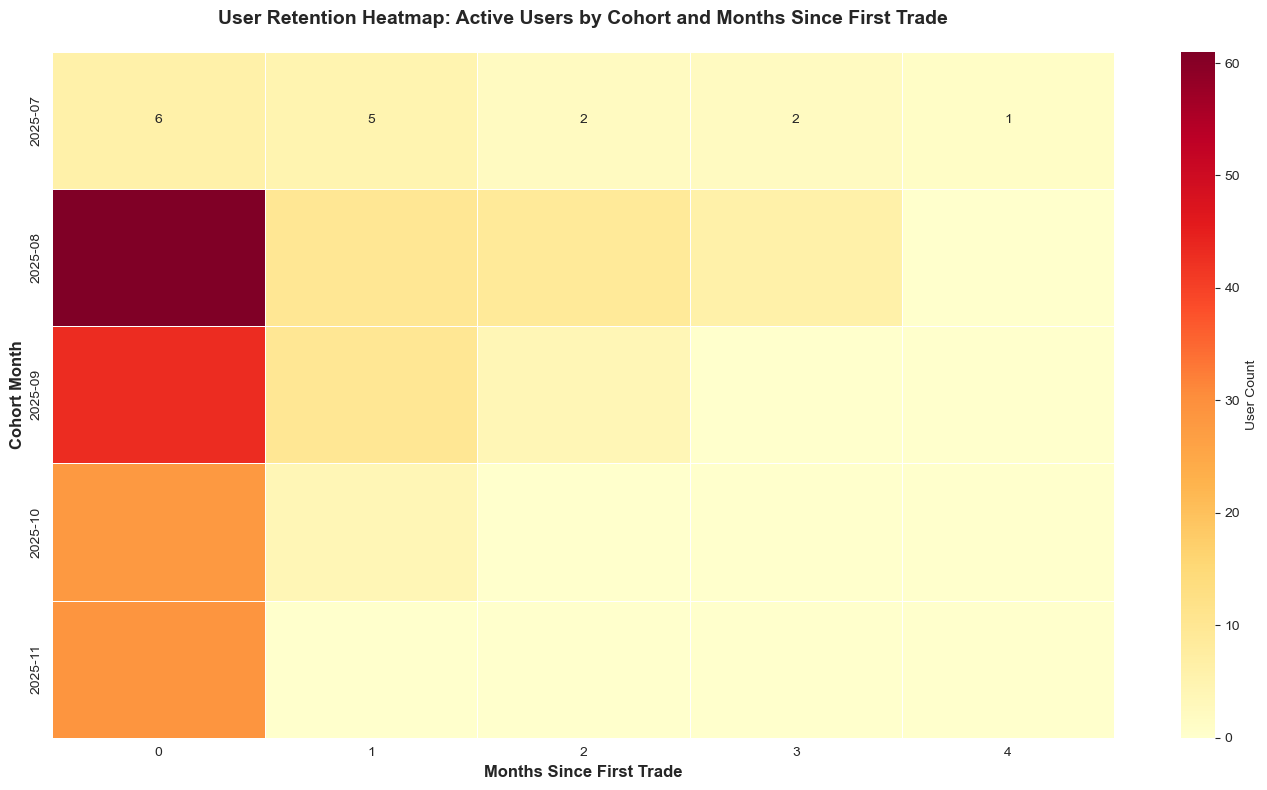

USER RETENTION & ENGAGEMENT ANALYSIS
Total unique users: 167
Repeat traders (>1 trade): 58 (34.7%)
Sticky users (10+ trades): 9 (5.4%)

Average trades per user: 2.60
Median trades per user: 1.00


In [16]:
# CELL 3: User Retention & Engagement

# Get user address column (adapt if column name differs)
user_col = 'from_address' if 'user_address' not in analysis_df.columns else 'user_address'

if user_col in analysis_df.columns and 'timestamp' in analysis_df.columns:
    # Calculate first trade date per user
    user_first_trade = analysis_df.groupby(user_col)['timestamp'].min().reset_index()
    user_first_trade.columns = [user_col, 'first_trade_date']
    user_first_trade['cohort_month'] = pd.to_datetime(user_first_trade['first_trade_date']).dt.to_period('M').astype(str)
    
    # Merge back to main dataframe
    analysis_df_with_cohort = analysis_df.merge(user_first_trade, on=user_col, how='left')
    analysis_df_with_cohort['trade_month'] = pd.to_datetime(analysis_df_with_cohort['timestamp']).dt.to_period('M').astype(str)
    
    # Calculate months since first trade
    # Convert to Period objects and calculate difference in months
    def calculate_months_diff(row):
        """Calculate months difference between two period strings"""
        try:
            if pd.isna(row['trade_month']) or pd.isna(row['cohort_month']):
                return 0
            trade_period = pd.Period(row['trade_month'])
            cohort_period = pd.Period(row['cohort_month'])
            return (trade_period - cohort_period).n
        except:
            return 0
    
    analysis_df_with_cohort['months_since_first'] = analysis_df_with_cohort.apply(calculate_months_diff, axis=1)
    
    # Create cohort retention table
    cohort_retention = analysis_df_with_cohort.groupby(['cohort_month', 'months_since_first'])[user_col].nunique().reset_index()
    cohort_retention.columns = ['cohort_month', 'months_since_first', 'user_count']
    
    # Pivot for heatmap
    cohort_pivot = cohort_retention.pivot(index='cohort_month', columns='months_since_first', values='user_count').fillna(0)
    
    # Calculate engagement metrics
    user_trade_counts = analysis_df.groupby(user_col).size().reset_index(name='trade_count')
    repeat_traders = len(user_trade_counts[user_trade_counts['trade_count'] > 1])
    sticky_users = len(user_trade_counts[user_trade_counts['trade_count'] >= 10])
    total_users = len(user_trade_counts)
    
    repeat_pct = (repeat_traders / total_users * 100) if total_users > 0 else 0
    sticky_pct = (sticky_users / total_users * 100) if total_users > 0 else 0
    
    # Create heatmap visualization
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Create heatmap
    sns.heatmap(cohort_pivot, annot=True, fmt='.0f', cmap='YlOrRd', 
                cbar_kws={'label': 'User Count'}, ax=ax, linewidths=0.5)
    ax.set_xlabel('Months Since First Trade', fontsize=12, fontweight='bold')
    ax.set_ylabel('Cohort Month', fontsize=12, fontweight='bold')
    ax.set_title('User Retention Heatmap: Active Users by Cohort and Months Since First Trade', 
                fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("=" * 60)
    print("USER RETENTION & ENGAGEMENT ANALYSIS")
    print("=" * 60)
    print(f"Total unique users: {total_users:,}")
    print(f"Repeat traders (>1 trade): {repeat_traders:,} ({repeat_pct:.1f}%)")
    print(f"Sticky users (10+ trades): {sticky_users:,} ({sticky_pct:.1f}%)")
    print(f"\nAverage trades per user: {user_trade_counts['trade_count'].mean():.2f}")
    print(f"Median trades per user: {user_trade_counts['trade_count'].median():.2f}")
    print("=" * 60)
else:
    print("Error: User address or timestamp column not found")


### CELL 4: Trading Time Patterns (Heatmap)

**Business Question:** When do users trade most actively? What are the peak trading hours and days?

**Goal:** Identify best times for promotions and protocol maintenance windows.


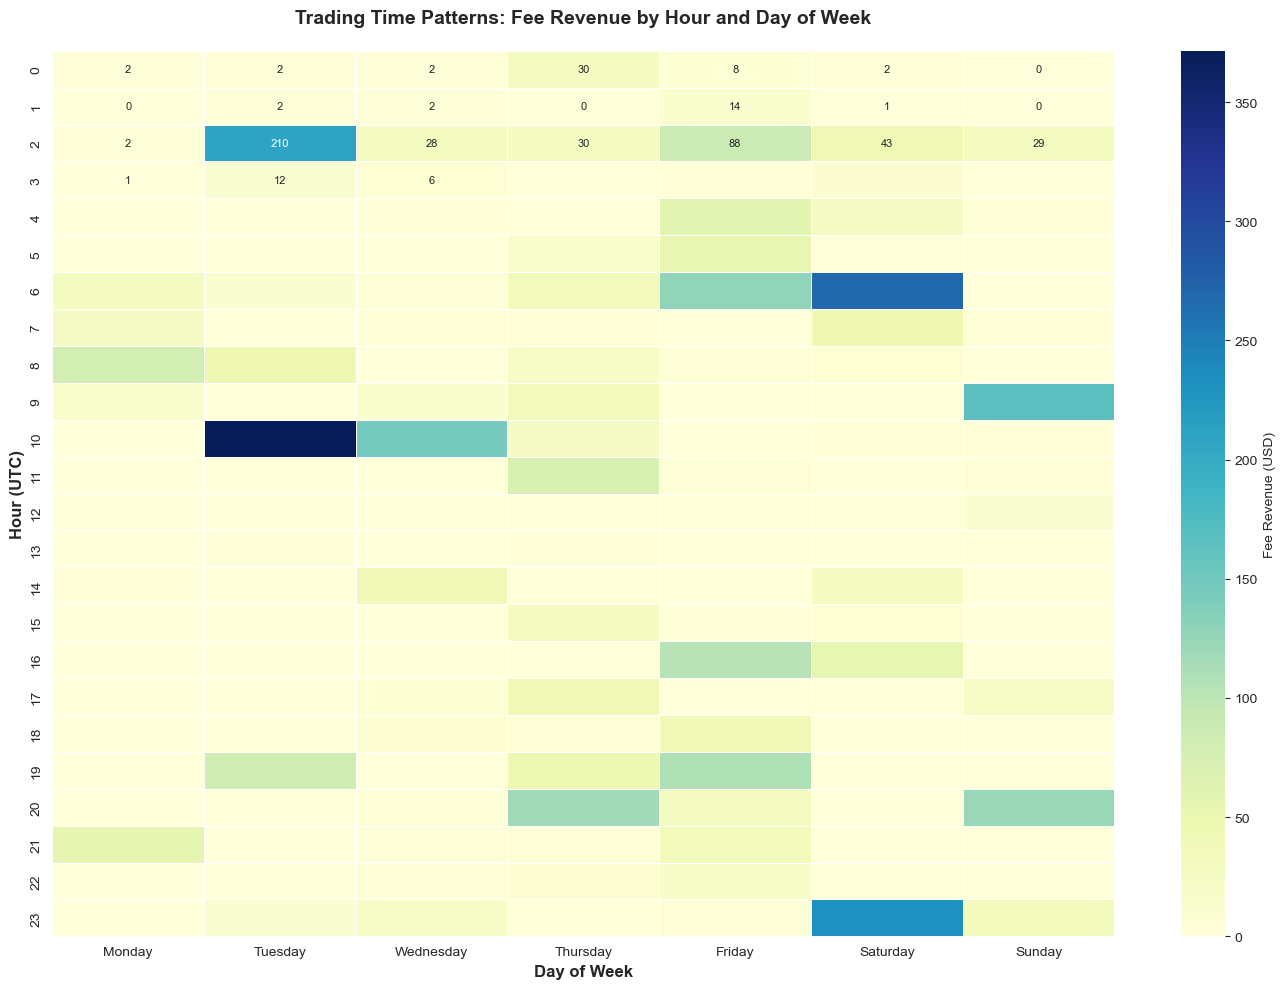

TRADING TIME PATTERNS ANALYSIS
Peak trading time: Tuesday at 10:00 UTC
Peak fee revenue: $371.49

Top 5 trading periods:
  Tuesday 10:00 UTC: $371.49
  Saturday 6:00 UTC: $269.86
  Saturday 23:00 UTC: $230.74
  Tuesday 2:00 UTC: $210.18
  Sunday 9:00 UTC: $164.55


In [17]:
# CELL 4: Trading Time Patterns (Heatmap)

if 'timestamp' in analysis_df.columns:
    # Extract hour and day of week
    analysis_df['hour'] = pd.to_datetime(analysis_df['timestamp']).dt.hour
    analysis_df['day_of_week'] = pd.to_datetime(analysis_df['timestamp']).dt.day_name()
    
    # Create pivot table: rows=hour, columns=day, values=SUM(fee_usd)
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    time_pivot = analysis_df.pivot_table(
        values='fee_usd',
        index='hour',
        columns='day_of_week',
        aggfunc='sum',
        fill_value=0
    )
    time_pivot = time_pivot.reindex(columns=day_order, fill_value=0)
    
    # Create annotated heatmap
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Create heatmap with annotations
    sns.heatmap(time_pivot, annot=True, fmt='.0f', cmap='YlGnBu', 
                cbar_kws={'label': 'Fee Revenue (USD)'}, ax=ax, 
                linewidths=0.5, annot_kws={'size': 8})
    
    ax.set_xlabel('Day of Week', fontsize=12, fontweight='bold')
    ax.set_ylabel('Hour (UTC)', fontsize=12, fontweight='bold')
    ax.set_title('Trading Time Patterns: Fee Revenue by Hour and Day of Week', 
                fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()
    
    # Find peak trading time
    max_value = time_pivot.max().max()
    peak_idx = time_pivot.stack().idxmax()
    peak_hour, peak_day = peak_idx
    
    print("=" * 60)
    print("TRADING TIME PATTERNS ANALYSIS")
    print("=" * 60)
    print(f"Peak trading time: {peak_day} at {peak_hour}:00 UTC")
    print(f"Peak fee revenue: ${max_value:,.2f}")
    print(f"\nTop 5 trading periods:")
    top_periods = time_pivot.stack().sort_values(ascending=False).head(5)
    for (hour, day), value in top_periods.items():
        print(f"  {day} {hour}:00 UTC: ${value:,.2f}")
    print("=" * 60)
else:
    print("Error: Timestamp column not found")


### CELL 5: Top 20 Whale Users Deep Dive

**Business Question:** How dependent is fee revenue on a small number of high-volume users (whales)?

**Goal:** Identify whale dependency risk for committee risk assessment.


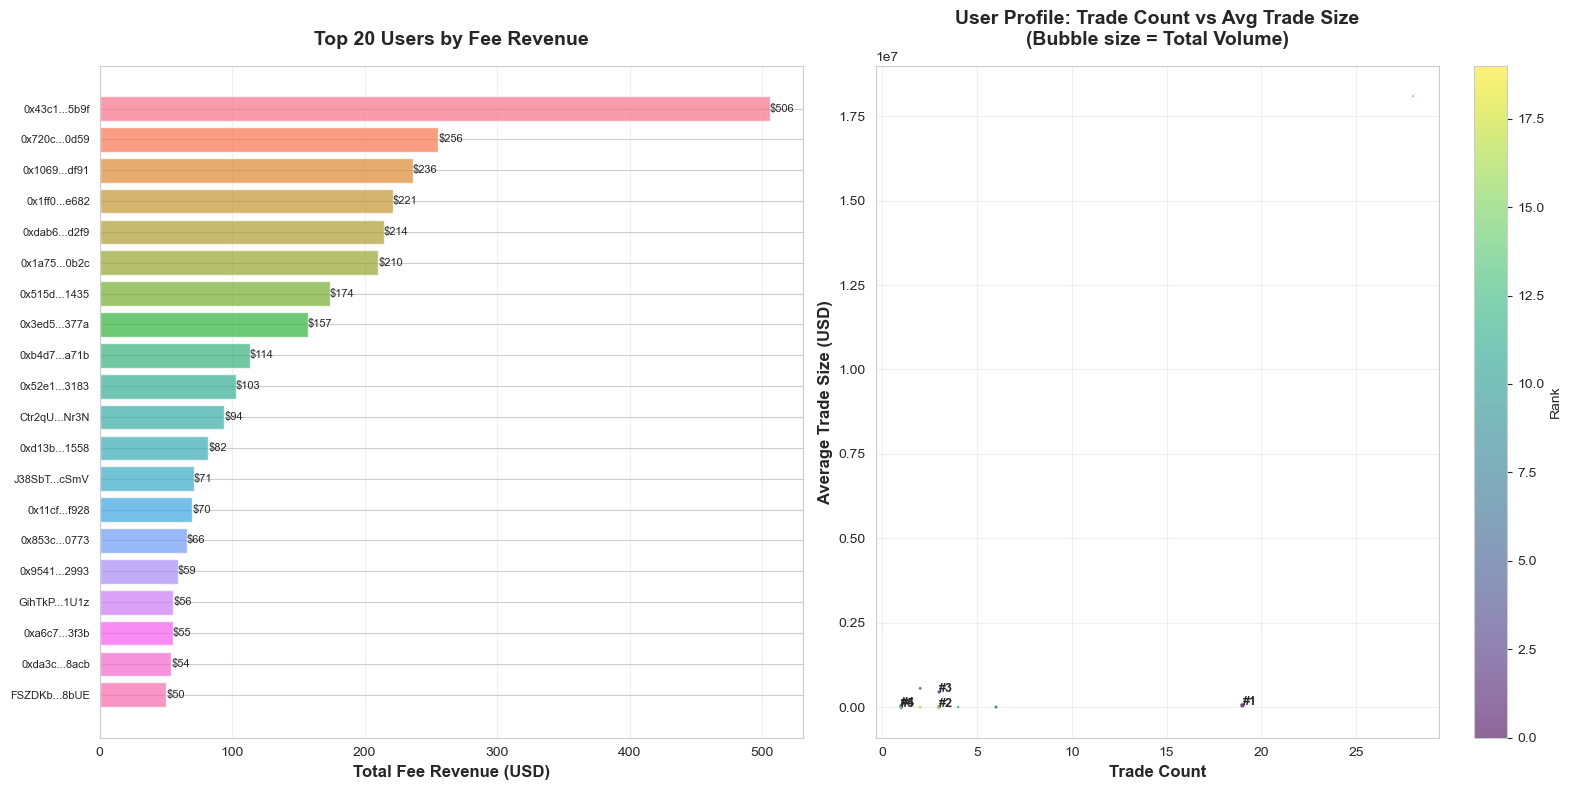

TOP 20 WHALE USERS ANALYSIS
Top 10 users = 60.5% of fees
Top 20 users = 78.6% of fees

Total unique users: 167
Total fee revenue: $3,623.74

⚠️  CONCENTRATION RISK: HIGH (>50%). Revenue heavily dependent on top 10 users.

Top 5 users:
  #1: $505.85 (19 trades, avg $51,281.25)
  #2: $255.52 (3 trades, avg $8,175.37)
  #3: $236.29 (3 trades, avg $447,402.48)
  #4: $221.44 (1 trades, avg $40,239.00)
  #5: $214.33 (1 trades, avg $10.70)


In [18]:
# CELL 5: Top 20 Whale Users Deep Dive

user_col = 'from_address' if 'user_address' not in analysis_df.columns else 'user_address'

if user_col in analysis_df.columns:
    # Group by user and calculate metrics
    user_stats = analysis_df.groupby(user_col).agg({
        'fee_usd': 'sum',
        'from_amount': ['count', 'mean'],
        'timestamp': ['min', 'max']
    }).reset_index()
    user_stats.columns = [user_col, 'total_volume', 'trade_count', 'avg_trade_size', 
                         'first_trade_date', 'last_trade_date']
    
    # Sort by total volume (fee revenue)
    user_stats = user_stats.sort_values('total_volume', ascending=False).reset_index(drop=True)
    
    # Calculate concentration metrics
    total_fees_all = user_stats['total_volume'].sum()
    top_10_pct = (user_stats.head(10)['total_volume'].sum() / total_fees_all * 100) if len(user_stats) >= 10 else 0
    top_20_pct = (user_stats.head(20)['total_volume'].sum() / total_fees_all * 100) if len(user_stats) >= 20 else 0
    
    # Get top 20 for visualization
    top_20 = user_stats.head(20).copy()
    
    # Anonymize addresses for display (show first 6 and last 4 chars)
    top_20['user_id'] = top_20[user_col].apply(
        lambda x: f"{str(x)[:6]}...{str(x)[-4:]}" if len(str(x)) > 10 else str(x)
    )
    
    # Create visualizations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Left: Bar chart of top 20 users by volume
    bars = ax1.barh(range(len(top_20)), top_20['total_volume'], 
                    color=sns.color_palette("husl", len(top_20)), alpha=0.7)
    ax1.set_yticks(range(len(top_20)))
    ax1.set_yticklabels(top_20['user_id'], fontsize=8)
    ax1.set_xlabel('Total Fee Revenue (USD)', fontsize=12, fontweight='bold')
    ax1.set_title('Top 20 Users by Fee Revenue', fontsize=14, fontweight='bold', pad=15)
    ax1.grid(True, alpha=0.3, axis='x')
    ax1.invert_yaxis()
    
    # Add value labels
    for i, (idx, row) in enumerate(top_20.iterrows()):
        ax1.text(row['total_volume'], i, f'${row["total_volume"]:,.0f}', 
                va='center', ha='left', fontsize=8)
    
    # Right: Scatter plot: X=trade_count, Y=avg_trade_size, size=total_volume
    scatter = ax2.scatter(top_20['trade_count'], top_20['avg_trade_size'], 
                         s=top_20['total_volume']/100, alpha=0.6, 
                         c=range(len(top_20)), cmap='viridis')
    ax2.set_xlabel('Trade Count', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Average Trade Size (USD)', fontsize=12, fontweight='bold')
    ax2.set_title('User Profile: Trade Count vs Avg Trade Size\n(Bubble size = Total Volume)', 
                  fontsize=14, fontweight='bold', pad=15)
    ax2.grid(True, alpha=0.3)
    
    # Add labels to top 5 users
    for i, (idx, row) in enumerate(top_20.head(5).iterrows()):
        ax2.annotate(f"#{i+1}", (row['trade_count'], row['avg_trade_size']), 
                    fontsize=9, fontweight='bold')
    
    plt.colorbar(scatter, ax=ax2, label='Rank')
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("=" * 60)
    print("TOP 20 WHALE USERS ANALYSIS")
    print("=" * 60)
    print(f"Top 10 users = {top_10_pct:.1f}% of fees")
    print(f"Top 20 users = {top_20_pct:.1f}% of fees")
    print(f"\nTotal unique users: {len(user_stats):,}")
    print(f"Total fee revenue: ${total_fees_all:,.2f}")
    
    # Risk assessment
    if top_10_pct > 50:
        risk_level = "HIGH"
        risk_msg = "⚠️  CONCENTRATION RISK: HIGH (>50%). Revenue heavily dependent on top 10 users."
    elif top_10_pct > 30:
        risk_level = "MEDIUM"
        risk_msg = "⚠️  CONCENTRATION RISK: MEDIUM (30-50%). Moderate whale dependency."
    else:
        risk_level = "LOW"
        risk_msg = "✓ CONCENTRATION RISK: LOW (<30%). Good user diversification."
    
    print(f"\n{risk_msg}")
    print(f"\nTop 5 users:")
    for i, (idx, row) in enumerate(top_20.head(5).iterrows()):
        print(f"  #{i+1}: ${row['total_volume']:,.2f} ({row['trade_count']} trades, avg ${row['avg_trade_size']:,.2f})")
    print("=" * 60)
else:
    print("Error: User address column not found")


### CELL 6: Asset Pair Performance Matrix

**Business Question:** Which asset pairs are most reliable for fee generation? Which are most volatile?

**Goal:** Show which pairs are reliable (stable) vs volatile (risky) for fee generation.


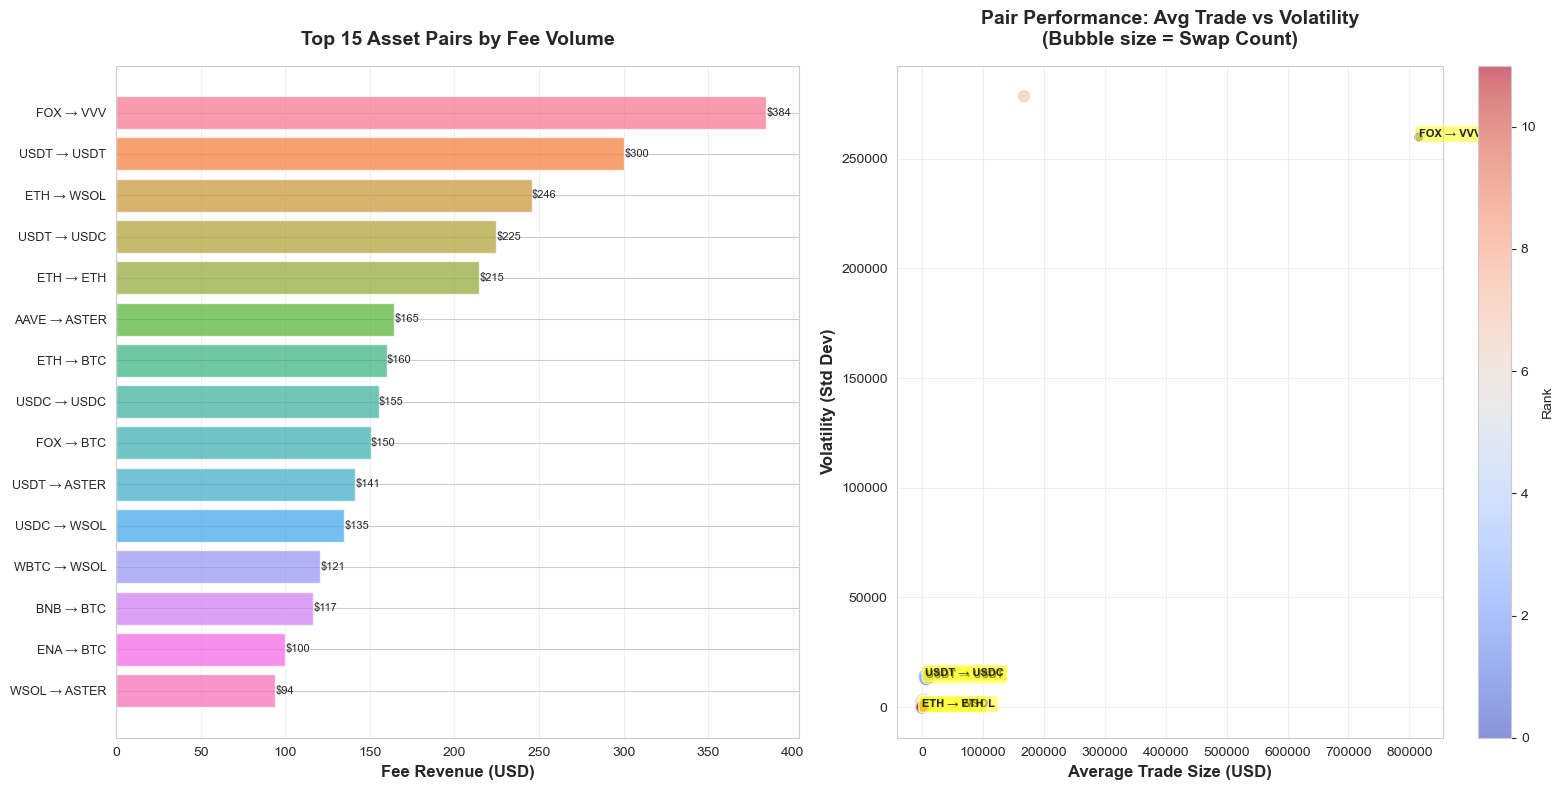

ASSET PAIR PERFORMANCE MATRIX
Most stable pair: WBTC → USDT (CV: 0.398, Volatility: $0.00)
Most volatile pair: USDT → ETH (CV: 3.186, Volatility: $12,783.85)

Top 15 pairs by volume:
  #1: FOX → VVV - $384.34 (3 swaps, avg $815,257.89)
  #2: USDT → USDT - $300.47 (8 swaps, avg $6,828.38)
  #3: ETH → WSOL - $245.78 (8 swaps, avg $1.27)
  #4: USDT → USDC - $224.84 (8 swaps, avg $5,150.45)
  #5: ETH → ETH - $214.74 (4 swaps, avg $2.68)
  #6: AAVE → ASTER - $164.55 (1 swaps, avg $101.34)
  #7: ETH → BTC - $159.86 (8 swaps, avg $1.23)
  #8: USDC → USDC - $155.31 (13 swaps, avg $2,242.46)
  #9: FOX → BTC - $150.45 (6 swaps, avg $167,146.99)
  #10: USDT → ASTER - $141.49 (2 swaps, avg $12,862.80)
  #11: USDC → WSOL - $134.88 (1 swaps, avg $24,525.92)
  #12: WBTC → WSOL - $120.64 (2 swaps, avg $0.09)
  #13: BNB → BTC - $116.65 (6 swaps, avg $3.65)
  #14: ENA → BTC - $100.11 (1 swaps, avg $29,425.84)
  #15: WSOL → ASTER - $94.22 (4 swaps, avg $25.39)


In [19]:
# CELL 6: Asset Pair Performance Matrix

# Group by asset pair and calculate metrics
pair_performance = analysis_df.groupby(['from_asset', 'to_asset']).agg({
    'fee_usd': 'sum',
    'from_amount': ['count', 'mean', 'std']
}).reset_index()
pair_performance.columns = ['from_asset', 'to_asset', 'pair_volume', 'swap_count', 
                           'avg_trade', 'volatility']
pair_performance['asset_pair'] = pair_performance['from_asset'] + ' → ' + pair_performance['to_asset']

# Fill NaN volatility with 0 (for pairs with only 1 swap)
pair_performance['volatility'] = pair_performance['volatility'].fillna(0)

# Sort by volume and get top 15
pair_performance = pair_performance.sort_values('pair_volume', ascending=False).reset_index(drop=True)
top_15_pairs = pair_performance.head(15).copy()

# Create visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Left: Horizontal bar chart of top 15 pairs by volume
bars = ax1.barh(range(len(top_15_pairs)), top_15_pairs['pair_volume'], 
                color=sns.color_palette("husl", len(top_15_pairs)), alpha=0.7)
ax1.set_yticks(range(len(top_15_pairs)))
ax1.set_yticklabels(top_15_pairs['asset_pair'], fontsize=9)
ax1.set_xlabel('Fee Revenue (USD)', fontsize=12, fontweight='bold')
ax1.set_title('Top 15 Asset Pairs by Fee Volume', fontsize=14, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.3, axis='x')
ax1.invert_yaxis()

# Add value labels
for i, (idx, row) in enumerate(top_15_pairs.iterrows()):
    ax1.text(row['pair_volume'], i, f'${row["pair_volume"]:,.0f}', 
            va='center', ha='left', fontsize=8)

# Right: Scatter plot: X=avg_trade, Y=volatility, bubble_size=swap_count
# Filter to pairs with at least 2 swaps for meaningful volatility
scatter_data = top_15_pairs[top_15_pairs['swap_count'] >= 2].copy()

if len(scatter_data) > 0:
    scatter = ax2.scatter(scatter_data['avg_trade'], scatter_data['volatility'], 
                         s=scatter_data['swap_count']*10, alpha=0.6, 
                         c=range(len(scatter_data)), cmap='coolwarm')
    ax2.set_xlabel('Average Trade Size (USD)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Volatility (Std Dev)', fontsize=12, fontweight='bold')
    ax2.set_title('Pair Performance: Avg Trade vs Volatility\n(Bubble size = Swap Count)', 
                  fontsize=14, fontweight='bold', pad=15)
    ax2.grid(True, alpha=0.3)
    
    # Add labels to top 5 pairs
    for i, (idx, row) in enumerate(scatter_data.head(5).iterrows()):
        ax2.annotate(row['asset_pair'], (row['avg_trade'], row['volatility']), 
                    fontsize=8, fontweight='bold', 
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5))
    
    plt.colorbar(scatter, ax=ax2, label='Rank')
else:
    ax2.text(0.5, 0.5, 'Insufficient data\nfor volatility analysis', 
             ha='center', va='center', transform=ax2.transAxes, fontsize=12)
    ax2.set_title('Pair Performance: Avg Trade vs Volatility', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary statistics
print("=" * 60)
print("ASSET PAIR PERFORMANCE MATRIX")
print("=" * 60)

# Find most stable and most volatile pairs (with at least 5 swaps)
stable_pairs = pair_performance[pair_performance['swap_count'] >= 5].copy()
if len(stable_pairs) > 0:
    stable_pairs['cv'] = stable_pairs['volatility'] / stable_pairs['avg_trade']  # coefficient of variation
    stable_pairs = stable_pairs[stable_pairs['cv'] > 0]  # Remove pairs with zero volatility
    
    if len(stable_pairs) > 0:
        most_stable = stable_pairs.loc[stable_pairs['cv'].idxmin()]
        most_volatile = stable_pairs.loc[stable_pairs['cv'].idxmax()]
        
        print(f"Most stable pair: {most_stable['asset_pair']} (CV: {most_stable['cv']:.3f}, Volatility: ${most_stable['volatility']:,.2f})")
        print(f"Most volatile pair: {most_volatile['asset_pair']} (CV: {most_volatile['cv']:.3f}, Volatility: ${most_volatile['volatility']:,.2f})")
    else:
        print("Insufficient data for stability analysis")
else:
    print("Insufficient data for stability analysis (need pairs with 5+ swaps)")

print(f"\nTop 15 pairs by volume:")
for i, (idx, row) in enumerate(top_15_pairs.iterrows()):
    print(f"  #{i+1}: {row['asset_pair']} - ${row['pair_volume']:,.2f} ({row['swap_count']} swaps, avg ${row['avg_trade']:,.2f})")
print("=" * 60)


### CELL 7: Week-over-Week Growth Dashboard

**Business Question:** What is the current momentum? Is growth accelerating or decelerating?

**Goal:** Show momentum and accelerating/decelerating growth trends for committee decision-making.


## Additional Analysis Cells - Advanced Financial Metrics

This section provides additional advanced analysis for comprehensive financial decision-making.


### CELL 13: Projected Revenue Forecast (3-Month)

**Business Impact:** What's Q1 budget going to be?

**Goal:** Forecast THORChain affiliate revenue for the next 3 months with confidence intervals.


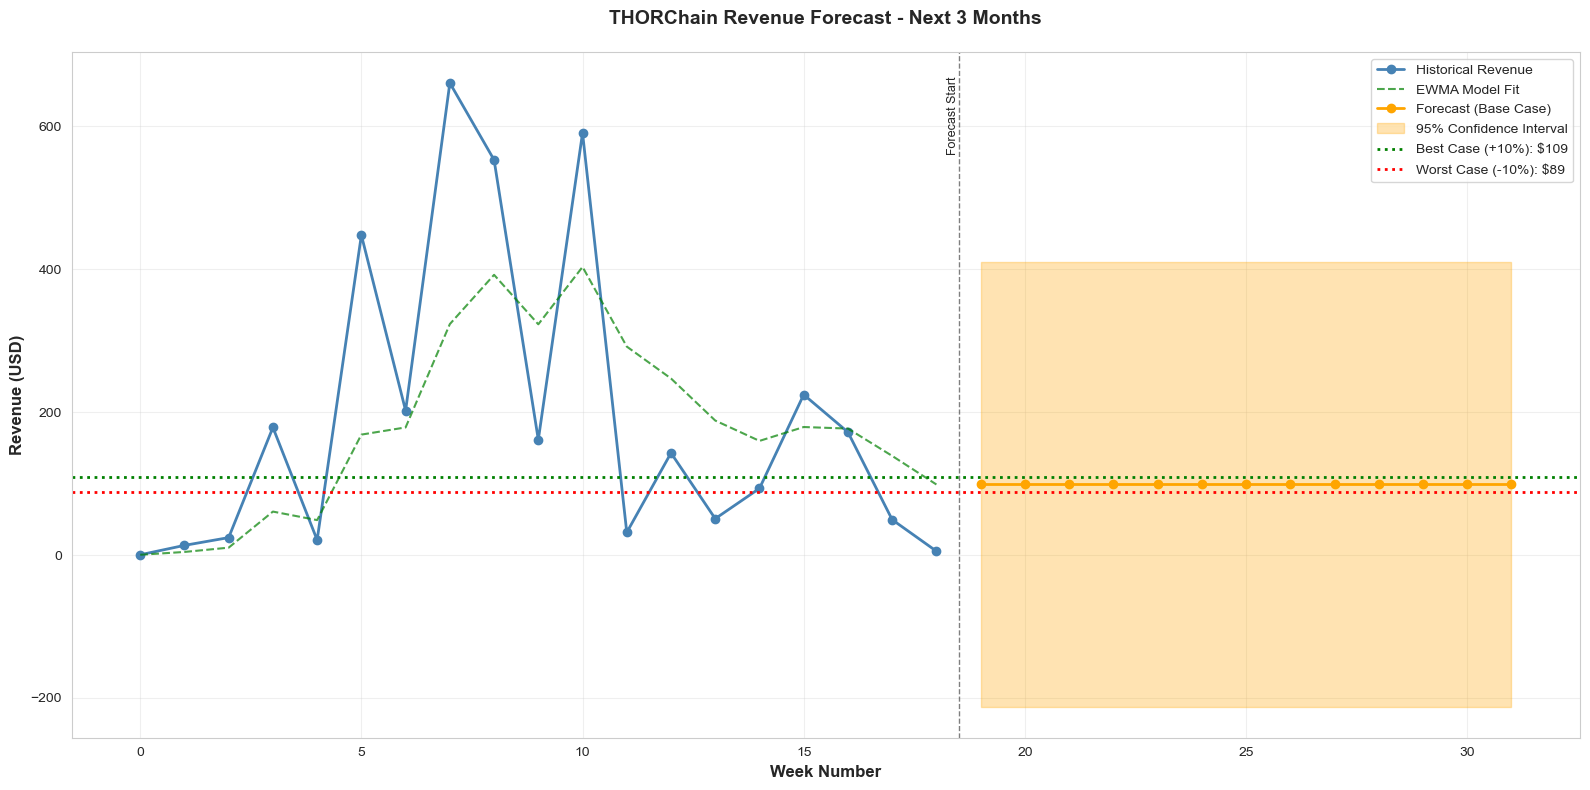

PROJECTED REVENUE FORECAST (3-MONTH)
Model Used: EWMA (std dev: $147.35)

Monthly Forecasts:
  December: $99 ± $311
  January: $99 ± $311
  February: $99 ± $311
  March: $99 ± $311

Scenarios:
  Best Case: $109/month (+10% growth)
  Base Case: $99/month (current trend)
  Worst Case: $89/month (-10% decline)


In [20]:
# CELL 13: Projected Revenue Forecast (3-Month)
from sklearn.linear_model import LinearRegression
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Prepare data: aggregate revenue by week
if 'timestamp' in analysis_df.columns and 'fee_usd' in analysis_df.columns:
    # Filter to valid timestamps
    forecast_df = analysis_df[analysis_df['timestamp'].notna()].copy()
    
    if len(forecast_df) > 0:
        # Aggregate by week
        forecast_df['year'] = forecast_df['timestamp'].dt.year
        forecast_df['week'] = forecast_df['timestamp'].dt.isocalendar().week
        forecast_df['year_week'] = forecast_df['year'].astype(str) + '-W' + forecast_df['week'].astype(str).str.zfill(2)
        
        weekly_revenue = forecast_df.groupby('year_week').agg({
            'fee_usd': 'sum'
        }).reset_index()
        weekly_revenue.columns = ['year_week', 'weekly_revenue']
        weekly_revenue = weekly_revenue.sort_values('year_week').reset_index(drop=True)
        weekly_revenue['week_num'] = range(len(weekly_revenue))
        
        if len(weekly_revenue) >= 4:  # Need at least 4 weeks for forecasting
            # Prepare data for modeling
            X = weekly_revenue['week_num'].values.reshape(-1, 1)
            y = weekly_revenue['weekly_revenue'].values
            
            # Model 1: Linear Regression
            lr_model = LinearRegression()
            lr_model.fit(X, y)
            lr_pred = lr_model.predict(X)
            lr_residuals = y - lr_pred
            lr_std = np.std(lr_residuals)
            
            # Model 2: Exponential (log-linear)
            y_log = np.log(y + 1)  # Add 1 to avoid log(0)
            exp_model = LinearRegression()
            exp_model.fit(X, y_log.reshape(-1, 1))
            exp_pred_log = exp_model.predict(X)
            exp_pred = np.exp(exp_pred_log) - 1
            exp_residuals = y - exp_pred.flatten()
            exp_std = np.std(exp_residuals)
            
            # Model 3: EWMA (Exponentially Weighted Moving Average)
            alpha = 0.3
            ewma_values = [y[0]]
            for i in range(1, len(y)):
                ewma_values.append(alpha * y[i] + (1 - alpha) * ewma_values[-1])
            ewma_pred = np.array(ewma_values)
            ewma_residuals = y - ewma_pred
            ewma_std = np.std(ewma_residuals)
            
            # Choose best model (lowest std dev)
            models = {
                'Linear': (lr_model, lr_std, lr_pred),
                'Exponential': (exp_model, exp_std, exp_pred.flatten()),
                'EWMA': (None, ewma_std, ewma_pred)
            }
            best_model_name = min(models, key=lambda x: models[x][1])
            best_model, best_std, best_pred = models[best_model_name]
            
            # Forecast forward 13 weeks (3 months)
            future_weeks = np.array(range(len(weekly_revenue), len(weekly_revenue) + 13)).reshape(-1, 1)
            
            if best_model_name == 'Linear':
                future_pred = best_model.predict(future_weeks)
            elif best_model_name == 'Exponential':
                future_pred_log = best_model.predict(future_weeks)
                future_pred = np.exp(future_pred_log) - 1
            else:  # EWMA
                last_value = ewma_values[-1]
                # Use numpy array for consistency, so .mean() works everywhere
                future_pred = []
                for _ in range(13):
                    future_pred.append(last_value)
                    last_value = alpha * last_value + (1 - alpha) * last_value
                future_pred = np.array(future_pred)
            
            # Calculate 95% confidence intervals (using t-distribution)
            t_value = stats.t.ppf(0.975, len(y) - 2)  # 95% confidence
            future_lower = future_pred - t_value * best_std
            future_upper = future_pred + t_value * best_std
            
            # Create future week labels
            last_week = weekly_revenue['year_week'].iloc[-1]
            future_week_labels = [f"Week {i+1}" for i in range(13)]
            
            # Calculate scenarios
            base_case = np.mean(future_pred[:4])  # Ensure this works even if future_pred is a list
            best_case = base_case * 1.10  # +10% growth
            worst_case = base_case * 0.90  # -10% decline
            
            # Create visualization
            fig, ax = plt.subplots(figsize=(16, 8))
            
            # Historical data
            ax.plot(weekly_revenue['week_num'], weekly_revenue['weekly_revenue'], 
                   'o-', label='Historical Revenue', linewidth=2, markersize=6, color='steelblue')
            
            # Best model fit
            ax.plot(weekly_revenue['week_num'], best_pred, 
                   '--', label=f'{best_model_name} Model Fit', alpha=0.7, color='green')
            
            # Forecast
            future_week_nums = range(len(weekly_revenue), len(weekly_revenue) + 13)
            ax.plot(future_week_nums, future_pred, 
                   'o-', label='Forecast (Base Case)', linewidth=2, markersize=6, color='orange')
            
            # Confidence band
            ax.fill_between(future_week_nums, future_lower.flatten() if isinstance(future_lower, np.ndarray) else future_lower,
                           future_upper.flatten() if isinstance(future_upper, np.ndarray) else future_upper,
                           alpha=0.3, color='orange', label='95% Confidence Interval')
            
            # Scenario lines
            ax.axhline(y=best_case, color='green', linestyle=':', linewidth=2, label=f'Best Case (+10%): ${best_case:,.0f}')
            ax.axhline(y=worst_case, color='red', linestyle=':', linewidth=2, label=f'Worst Case (-10%): ${worst_case:,.0f}')
            
            ax.set_xlabel('Week Number', fontsize=12, fontweight='bold')
            ax.set_ylabel('Revenue (USD)', fontsize=12, fontweight='bold')
            ax.set_title('THORChain Revenue Forecast - Next 3 Months', fontsize=14, fontweight='bold', pad=20)
            ax.legend(loc='best')
            ax.grid(True, alpha=0.3)
            
            # Add vertical line separating historical from forecast
            ax.axvline(x=len(weekly_revenue)-0.5, color='black', linestyle='--', linewidth=1, alpha=0.5)
            ax.text(len(weekly_revenue)-0.5, ax.get_ylim()[1]*0.95, 'Forecast Start', 
                   rotation=90, va='top', ha='right', fontsize=9)
            
            plt.tight_layout()
            plt.show()
            
            # Print summary
            print("=" * 70)
            print("PROJECTED REVENUE FORECAST (3-MONTH)")
            print("=" * 70)
            print(f"Model Used: {best_model_name} (std dev: ${best_std:,.2f})")
            print(f"\nMonthly Forecasts:")
            for i in range(0, 13, 4):  # Show monthly averages
                month_num = (i // 4) + 1
                month_weeks = future_pred[i:min(i+4, 13)]
                month_lower = (future_lower[i:min(i+4, 13)] if isinstance(future_lower, np.ndarray) else future_lower)
                month_upper = (future_upper[i:min(i+4, 13)] if isinstance(future_upper, np.ndarray) else future_upper)
                
                # Use np.mean so that it works regardless of type (list or array)
                month_avg = np.mean(month_weeks)
                month_lower_avg = np.mean(month_lower)
                month_upper_avg = np.mean(month_upper)
                
                month_names = ['December', 'January', 'February', 'March']
                if month_num <= len(month_names):
                    print(f"  {month_names[month_num-1]}: ${month_avg:,.0f} ± ${(month_upper_avg-month_lower_avg)/2:,.0f}")
            
            print(f"\nScenarios:")
            print(f"  Best Case: ${best_case:,.0f}/month (+10% growth)")
            print(f"  Base Case: ${base_case:,.0f}/month (current trend)")
            print(f"  Worst Case: ${worst_case:,.0f}/month (-10% decline)")
            print("=" * 70)
        else:
            print("⚠ Insufficient data for forecasting (need at least 4 weeks)")
    else:
        print("⚠ No valid timestamp data available for forecasting")
else:
    print("⚠ Missing required columns: 'timestamp' and/or 'fee_usd'")


### CELL 14: Incentive ROI Analysis

**Business Impact:** Are rebates actually profitable?

**Goal:** Calculate return-on-investment for affiliate incentive spending.


⚠ Using estimated incentive_paid (0.3% of swap volume)


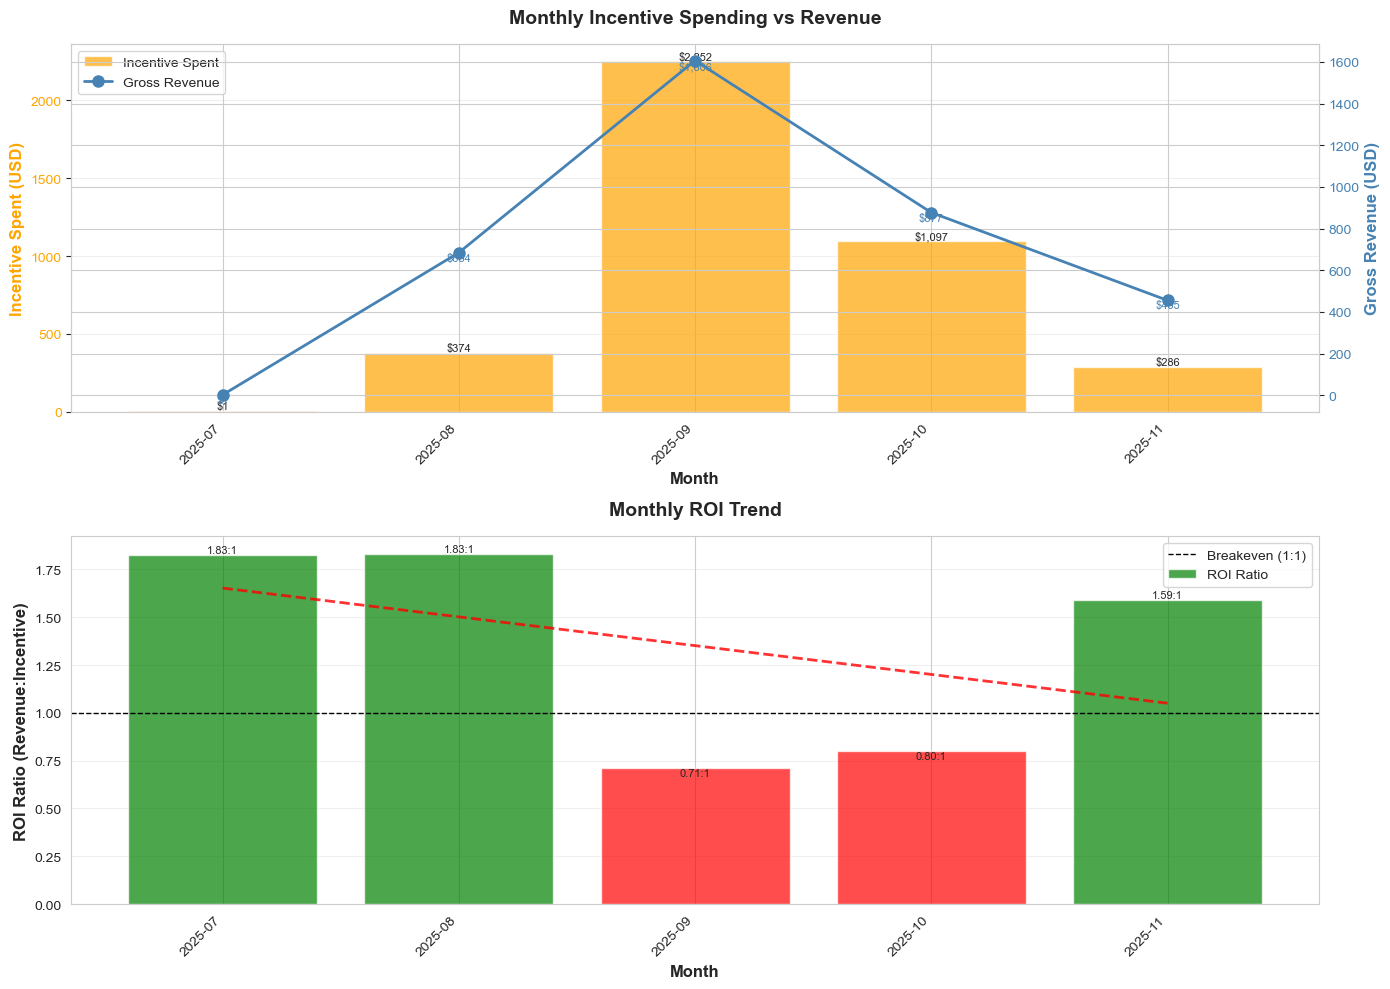

INCENTIVE ROI ANALYSIS
Current Month (2025-11):
  ROI: 1.59:1
  Gross Revenue: $455.07
  Incentive Spent: $286.41
  Net Revenue: $168.66

Historical Trend:
  2025-07: 1.83:1 
  2025-08: 1.83:1 ↑
  2025-09: 0.71:1 ↓
  2025-10: 0.80:1 ↑
  2025-11: 1.59:1 ↑

Average ROI: 1.35:1
Trend: declining

Recommendation: ⚠️ CAUTION: ROI declining. Monitor closely and consider reducing incentive rate.


In [21]:
# CELL 14: Incentive ROI Analysis

# Check if incentive data exists, otherwise estimate based on typical affiliate structure
if 'timestamp' in analysis_df.columns and 'fee_usd' in analysis_df.columns:
    roi_df = analysis_df[analysis_df['timestamp'].notna()].copy()
    
    # Estimate incentive spending if not available
    # Typical affiliate rebate: 0.3-0.5% of swap volume
    if 'incentive_paid' not in roi_df.columns:
        # Estimate: assume 0.3% rebate on swap volume
        roi_df['incentive_paid'] = roi_df.get('from_amount_usd', roi_df['from_amount']) * 0.003
        print("⚠ Using estimated incentive_paid (0.3% of swap volume)")
    
    # Aggregate by month
    roi_df['year_month'] = roi_df['timestamp'].dt.to_period('M').astype(str)
    
    monthly_roi = roi_df.groupby('year_month').agg({
        'fee_usd': 'sum',
        'incentive_paid': 'sum',
        'from_amount': 'sum'
    }).reset_index()
    monthly_roi.columns = ['year_month', 'gross_revenue', 'incentive_spent', 'total_volume']
    
    # Calculate metrics
    monthly_roi['net_revenue'] = monthly_roi['gross_revenue'] - monthly_roi['incentive_spent']
    monthly_roi['roi_ratio'] = monthly_roi['gross_revenue'] / monthly_roi['incentive_spent'].replace(0, np.nan)
    monthly_roi['roi_pct'] = ((monthly_roi['gross_revenue'] - monthly_roi['incentive_spent']) / monthly_roi['incentive_spent'] * 100).replace([np.inf, -np.inf], np.nan)
    
    # Calculate month-over-month ROI trend
    monthly_roi['roi_trend'] = monthly_roi['roi_ratio'].pct_change() * 100
    
    if len(monthly_roi) > 0:
        # Create visualization
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
        
        # Top: Bar chart of incentive spending + revenue line
        x_pos = range(len(monthly_roi))
        bars = ax1.bar(x_pos, monthly_roi['incentive_spent'], alpha=0.7, label='Incentive Spent', color='orange')
        ax1_twin = ax1.twinx()
        line = ax1_twin.plot(x_pos, monthly_roi['gross_revenue'], 'o-', linewidth=2, 
                             markersize=8, label='Gross Revenue', color='steelblue')
        
        ax1.set_xlabel('Month', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Incentive Spent (USD)', fontsize=12, fontweight='bold', color='orange')
        ax1_twin.set_ylabel('Gross Revenue (USD)', fontsize=12, fontweight='bold', color='steelblue')
        ax1.set_title('Monthly Incentive Spending vs Revenue', fontsize=14, fontweight='bold', pad=15)
        ax1.set_xticks(x_pos)
        ax1.set_xticklabels(monthly_roi['year_month'], rotation=45, ha='right')
        ax1.tick_params(axis='y', labelcolor='orange')
        ax1_twin.tick_params(axis='y', labelcolor='steelblue')
        ax1.grid(True, alpha=0.3, axis='y')
        
        # Combine legends
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax1_twin.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
        
        # Add value labels on bars
        for i, (idx, row) in enumerate(monthly_roi.iterrows()):
            ax1.text(i, row['incentive_spent'], f'${row["incentive_spent"]:,.0f}', 
                    ha='center', va='bottom', fontsize=8)
            ax1_twin.text(i, row['gross_revenue'], f'${row["gross_revenue"]:,.0f}', 
                         ha='center', va='top', fontsize=8, color='steelblue')
        
        # Bottom: Line chart of ROI with trend line
        colors_roi = ['green' if x >= 1.0 else 'red' for x in monthly_roi['roi_ratio']]
        ax2.bar(x_pos, monthly_roi['roi_ratio'], color=colors_roi, alpha=0.7, label='ROI Ratio')
        ax2.axhline(y=1.0, color='black', linestyle='--', linewidth=1, label='Breakeven (1:1)')
        ax2.set_xlabel('Month', fontsize=12, fontweight='bold')
        ax2.set_ylabel('ROI Ratio (Revenue:Incentive)', fontsize=12, fontweight='bold')
        ax2.set_title('Monthly ROI Trend', fontsize=14, fontweight='bold', pad=15)
        ax2.set_xticks(x_pos)
        ax2.set_xticklabels(monthly_roi['year_month'], rotation=45, ha='right')
        ax2.grid(True, alpha=0.3, axis='y')
        ax2.legend()
        
        # Add trend line
        if len(monthly_roi) >= 2:
            z = np.polyfit(x_pos, monthly_roi['roi_ratio'].fillna(1), 1)
            p = np.poly1d(z)
            ax2.plot(x_pos, p(x_pos), "r--", alpha=0.8, linewidth=2, label='Trend Line')
        
        # Add value labels
        for i, (idx, row) in enumerate(monthly_roi.iterrows()):
            if pd.notna(row['roi_ratio']):
                ax2.text(i, row['roi_ratio'], f'{row["roi_ratio"]:.2f}:1', 
                        ha='center', va='bottom' if row['roi_ratio'] >= 1 else 'top', fontsize=8)
        
        plt.tight_layout()
        plt.show()
        
        # Print summary
        print("=" * 70)
        print("INCENTIVE ROI ANALYSIS")
        print("=" * 70)
        
        latest_month = monthly_roi.iloc[-1]
        print(f"Current Month ({latest_month['year_month']}):")
        print(f"  ROI: {latest_month['roi_ratio']:.2f}:1")
        print(f"  Gross Revenue: ${latest_month['gross_revenue']:,.2f}")
        print(f"  Incentive Spent: ${latest_month['incentive_spent']:,.2f}")
        print(f"  Net Revenue: ${latest_month['net_revenue']:,.2f}")
        
        if len(monthly_roi) >= 2:
            print(f"\nHistorical Trend:")
            for i, (idx, row) in enumerate(monthly_roi.iterrows()):
                trend_arrow = "↑" if i > 0 and monthly_roi.iloc[i]['roi_ratio'] > monthly_roi.iloc[i-1]['roi_ratio'] else "↓" if i > 0 else ""
                print(f"  {row['year_month']}: {row['roi_ratio']:.2f}:1 {trend_arrow}")
        
        # Calculate average ROI
        avg_roi = monthly_roi['roi_ratio'].mean()
        trend_direction = "declining" if len(monthly_roi) >= 2 and monthly_roi['roi_ratio'].iloc[-1] < monthly_roi['roi_ratio'].iloc[0] else "improving" if len(monthly_roi) >= 2 else "stable"
        
        print(f"\nAverage ROI: {avg_roi:.2f}:1")
        print(f"Trend: {trend_direction}")
        
        # Recommendation
        if latest_month['roi_ratio'] < 1.0:
            recommendation = "⚠️ CRITICAL: ROI below breakeven. Consider reducing incentive rate or pausing incentives."
        elif latest_month['roi_ratio'] < 1.5:
            recommendation = "⚠️ WARNING: Low ROI. Consider reducing incentive rate from current level."
        elif trend_direction == "declining" and latest_month['roi_ratio'] < 2.0:
            recommendation = "⚠️ CAUTION: ROI declining. Monitor closely and consider reducing incentive rate."
        else:
            recommendation = "✓ ROI is healthy. Current incentive rate appears sustainable."
        
        print(f"\nRecommendation: {recommendation}")
        print("=" * 70)
    else:
        print("⚠ No monthly data available for ROI analysis")
else:
    print("⚠ Missing required columns: 'timestamp' and/or 'fee_usd'")


### CELL 10: Revenue per User Segment (LTV Analysis)

**Business Impact:** Which users are valuable? Where to spend incentives?

**Goal:** Segment users by lifetime value and calculate ROI by user tier.


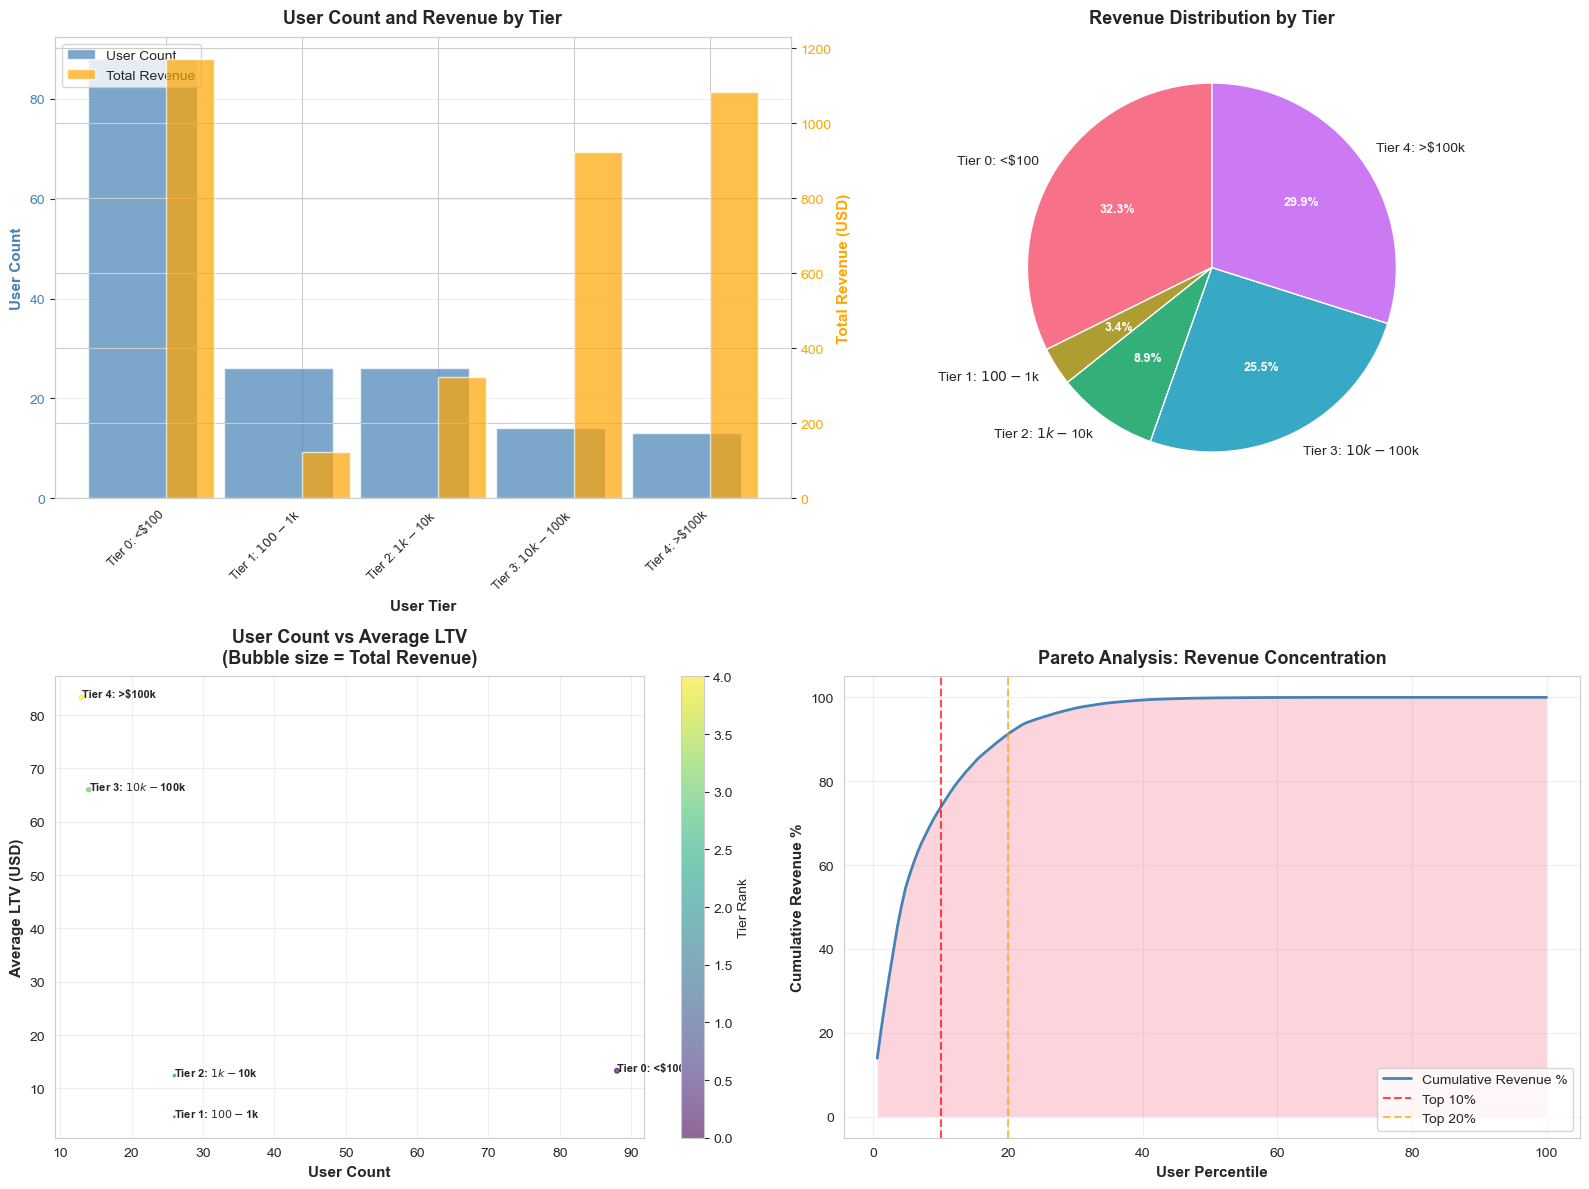

REVENUE PER USER SEGMENT (LTV ANALYSIS)

Tier Breakdown:
              tier  user_count  total_fees   avg_ltv  pct_of_total_revenue  avg_transactions_per_user
     Tier 0: <$100          88 1171.719924 13.314999                 32.33                   1.693182
  Tier 1: $100-$1k          26  121.952293  4.690473                  3.37                   3.153846
  Tier 2: $1k-$10k          26  322.497758 12.403760                  8.90                   2.192308
Tier 3: $10k-$100k          14  924.240823 66.017202                 25.51                   1.857143
    Tier 4: >$100k          13 1083.329048 83.333004                 29.90                   9.307692

Pareto Analysis:
  Top 10% of users generate 72.7% of revenue
  Top 20% of users generate 91.0% of revenue

✓ Low whale risk: Tier 4 (13 users) = 29.9% of revenue

Growth Opportunity:
  Tier 2 ($1k-$10k): 26 users = 8.9% of revenue
  Recommendation: Shift incentives from Tier 0 to Tier 2 for better ROI


In [22]:
# CELL 10: Revenue per User Segment (LTV Analysis)

user_col = 'from_address' if 'user_address' not in analysis_df.columns else 'user_address'

if user_col in analysis_df.columns:
    # Calculate lifetime metrics per user
    user_ltv = analysis_df.groupby(user_col).agg({
        'from_amount': ['sum', 'count', 'mean'],
        'fee_usd': 'sum'
    }).reset_index()
    user_ltv.columns = [user_col, 'lifetime_total_volume', 'transaction_count', 'avg_transaction_size', 'lifetime_total_fees']
    
    # Create user tiers based on lifetime volume
    def assign_tier(volume):
        if volume < 100:
            return 'Tier 0: <$100'
        elif volume < 1000:
            return 'Tier 1: $100-$1k'
        elif volume < 10000:
            return 'Tier 2: $1k-$10k'
        elif volume < 100000:
            return 'Tier 3: $10k-$100k'
        else:
            return 'Tier 4: >$100k'
    
    user_ltv['user_tier'] = user_ltv['lifetime_total_volume'].apply(assign_tier)
    
    # Aggregate by tier
    tier_analysis = user_ltv.groupby('user_tier').agg({
        user_col: 'count',
        'lifetime_total_volume': 'sum',
        'lifetime_total_fees': 'sum',
        'transaction_count': 'sum',
        'avg_transaction_size': 'mean'
    }).reset_index()
    tier_analysis.columns = ['tier', 'user_count', 'total_volume', 'total_fees', 'total_transactions', 'avg_transaction_size']
    
    # Calculate metrics
    total_fees_all = tier_analysis['total_fees'].sum()
    tier_analysis['avg_ltv'] = tier_analysis['total_fees'] / tier_analysis['user_count']
    tier_analysis['pct_of_total_revenue'] = (tier_analysis['total_fees'] / total_fees_all * 100).round(2)
    tier_analysis['avg_transactions_per_user'] = tier_analysis['total_transactions'] / tier_analysis['user_count']
    
    # Sort by tier order
    tier_order = ['Tier 0: <$100', 'Tier 1: $100-$1k', 'Tier 2: $1k-$10k', 'Tier 3: $10k-$100k', 'Tier 4: >$100k']
    tier_analysis['tier_num'] = tier_analysis['tier'].apply(lambda x: tier_order.index(x) if x in tier_order else 999)
    tier_analysis = tier_analysis.sort_values('tier_num').reset_index(drop=True)
    
    # Calculate Pareto analysis
    user_ltv_sorted = user_ltv.sort_values('lifetime_total_fees', ascending=False).reset_index(drop=True)
    user_ltv_sorted['cumulative_fees'] = user_ltv_sorted['lifetime_total_fees'].cumsum()
    user_ltv_sorted['cumulative_pct'] = (user_ltv_sorted['cumulative_fees'] / total_fees_all * 100)
    user_ltv_sorted['user_pct'] = ((user_ltv_sorted.index + 1) / len(user_ltv_sorted) * 100)
    
    top_10_pct_users = user_ltv_sorted[user_ltv_sorted['user_pct'] <= 10]
    top_20_pct_users = user_ltv_sorted[user_ltv_sorted['user_pct'] <= 20]
    
    top_10_revenue_pct = top_10_pct_users['lifetime_total_fees'].sum() / total_fees_all * 100 if len(top_10_pct_users) > 0 else 0
    top_20_revenue_pct = top_20_pct_users['lifetime_total_fees'].sum() / total_fees_all * 100 if len(top_20_pct_users) > 0 else 0
    
    # Create visualizations
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Top-left: Bar chart (tier vs user_count + revenue overlay)
    x_pos = range(len(tier_analysis))
    bars1 = ax1.bar(x_pos, tier_analysis['user_count'], alpha=0.7, label='User Count', color='steelblue')
    ax1_twin = ax1.twinx()
    bars2 = ax1_twin.bar([x + 0.35 for x in x_pos], tier_analysis['total_fees'], alpha=0.7, 
                         label='Total Revenue', color='orange', width=0.35)
    
    ax1.set_xlabel('User Tier', fontsize=11, fontweight='bold')
    ax1.set_ylabel('User Count', fontsize=11, fontweight='bold', color='steelblue')
    ax1_twin.set_ylabel('Total Revenue (USD)', fontsize=11, fontweight='bold', color='orange')
    ax1.set_title('User Count and Revenue by Tier', fontsize=13, fontweight='bold', pad=10)
    ax1.set_xticks([x + 0.175 for x in x_pos])
    ax1.set_xticklabels(tier_analysis['tier'], rotation=45, ha='right', fontsize=9)
    ax1.tick_params(axis='y', labelcolor='steelblue')
    ax1_twin.tick_params(axis='y', labelcolor='orange')
    ax1.grid(True, alpha=0.3, axis='y')
    
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax1_twin.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    # Top-right: Pie chart (% by tier)
    colors_pie = sns.color_palette("husl", len(tier_analysis))
    wedges, texts, autotexts = ax2.pie(tier_analysis['pct_of_total_revenue'], labels=tier_analysis['tier'], 
                                       autopct='%1.1f%%', colors=colors_pie, startangle=90)
    ax2.set_title('Revenue Distribution by Tier', fontsize=13, fontweight='bold', pad=10)
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(9)
    
    # Bottom-left: Scatter (user_count vs avg_ltv)
    scatter = ax3.scatter(tier_analysis['user_count'], tier_analysis['avg_ltv'], 
                         s=tier_analysis['total_fees']/100, alpha=0.6, c=range(len(tier_analysis)), cmap='viridis')
    for i, (idx, row) in enumerate(tier_analysis.iterrows()):
        ax3.annotate(row['tier'], (row['user_count'], row['avg_ltv']), 
                    fontsize=8, fontweight='bold')
    ax3.set_xlabel('User Count', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Average LTV (USD)', fontsize=11, fontweight='bold')
    ax3.set_title('User Count vs Average LTV\n(Bubble size = Total Revenue)', fontsize=13, fontweight='bold', pad=10)
    ax3.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax3, label='Tier Rank')
    
    # Bottom-right: Pareto chart
    ax4.plot(user_ltv_sorted['user_pct'], user_ltv_sorted['cumulative_pct'], 
            linewidth=2, color='steelblue', label='Cumulative Revenue %')
    ax4.axvline(x=10, color='red', linestyle='--', alpha=0.7, label='Top 10%')
    ax4.axvline(x=20, color='orange', linestyle='--', alpha=0.7, label='Top 20%')
    ax4.fill_between(user_ltv_sorted['user_pct'], 0, user_ltv_sorted['cumulative_pct'], alpha=0.3)
    ax4.set_xlabel('User Percentile', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Cumulative Revenue %', fontsize=11, fontweight='bold')
    ax4.set_title('Pareto Analysis: Revenue Concentration', fontsize=13, fontweight='bold', pad=10)
    ax4.grid(True, alpha=0.3)
    ax4.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("=" * 70)
    print("REVENUE PER USER SEGMENT (LTV ANALYSIS)")
    print("=" * 70)
    print("\nTier Breakdown:")
    print(tier_analysis[['tier', 'user_count', 'total_fees', 'avg_ltv', 'pct_of_total_revenue', 'avg_transactions_per_user']].to_string(index=False))
    
    print(f"\nPareto Analysis:")
    print(f"  Top 10% of users generate {top_10_revenue_pct:.1f}% of revenue")
    print(f"  Top 20% of users generate {top_20_revenue_pct:.1f}% of revenue")
    
    # Risk assessment
    tier_4_pct = tier_analysis[tier_analysis['tier'] == 'Tier 4: >$100k']['pct_of_total_revenue'].iloc[0] if len(tier_analysis[tier_analysis['tier'] == 'Tier 4: >$100k']) > 0 else 0
    tier_4_count = tier_analysis[tier_analysis['tier'] == 'Tier 4: >$100k']['user_count'].iloc[0] if len(tier_analysis[tier_analysis['tier'] == 'Tier 4: >$100k']) > 0 else 0
    
    if tier_4_pct > 50:
        risk_msg = f"⚠️ HIGH WHALE RISK: Tier 4 ({tier_4_count} users) = {tier_4_pct:.1f}% of revenue"
    elif tier_4_pct > 30:
        risk_msg = f"⚠️ MODERATE WHALE RISK: Tier 4 ({tier_4_count} users) = {tier_4_pct:.1f}% of revenue"
    else:
        risk_msg = f"✓ Low whale risk: Tier 4 ({tier_4_count} users) = {tier_4_pct:.1f}% of revenue"
    
    print(f"\n{risk_msg}")
    
    # Growth opportunity
    tier_2_pct = tier_analysis[tier_analysis['tier'] == 'Tier 2: $1k-$10k']['pct_of_total_revenue'].iloc[0] if len(tier_analysis[tier_analysis['tier'] == 'Tier 2: $1k-$10k']) > 0 else 0
    tier_2_count = tier_analysis[tier_analysis['tier'] == 'Tier 2: $1k-$10k']['user_count'].iloc[0] if len(tier_analysis[tier_analysis['tier'] == 'Tier 2: $1k-$10k']) > 0 else 0
    
    print(f"\nGrowth Opportunity:")
    print(f"  Tier 2 ($1k-$10k): {tier_2_count} users = {tier_2_pct:.1f}% of revenue")
    print(f"  Recommendation: Shift incentives from Tier 0 to Tier 2 for better ROI")
    print("=" * 70)
else:
    print("⚠ Missing required column: 'user_address' or 'from_address'")


### CELL 12: Fraud/Abuse Detection

**Business Impact:** How much volume is real? Are bots farming fees?

**Goal:** Identify suspicious trading patterns and potential fraudulent activity.


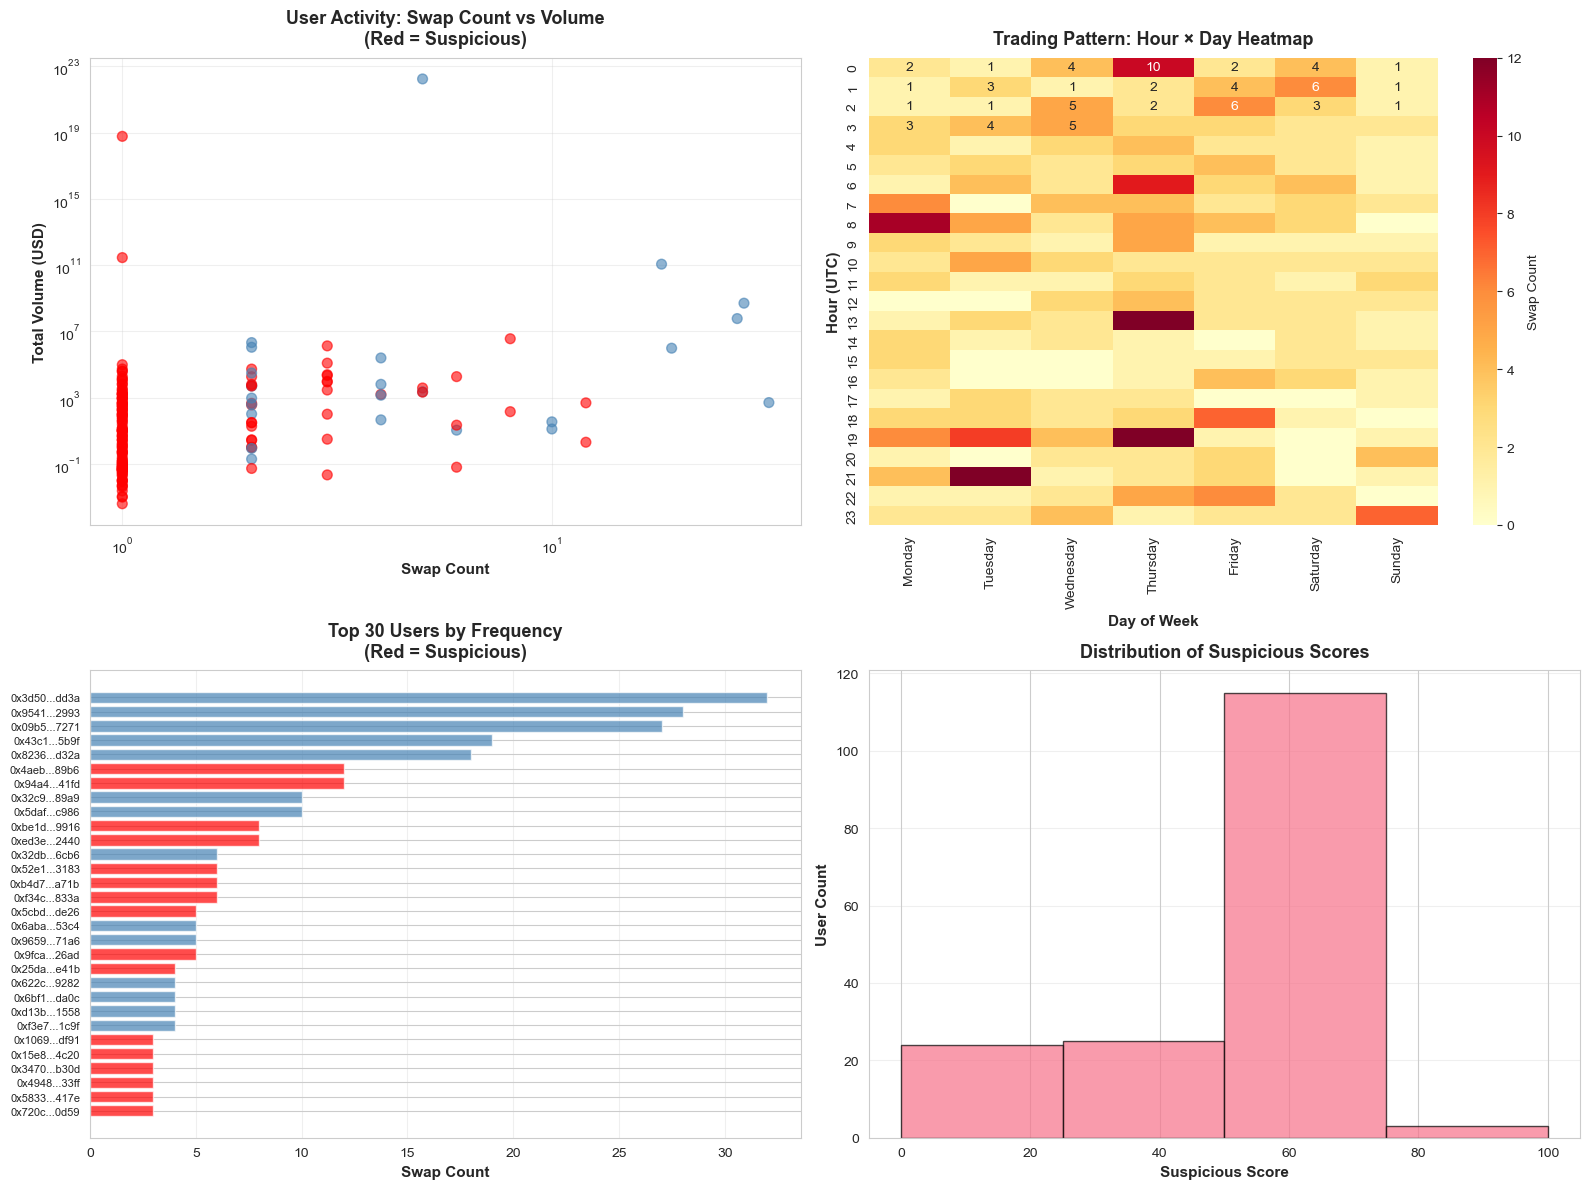

FRAUD/ABUSE DETECTION ANALYSIS
Users flagged as suspicious: 143 (85.6%)
Suspicious volume: $5,899,570,594,214,919,168.00 (0.0% of total)
Real volume: $17,175,593,150,924,906,823,680.00

Estimated fraudulent volume: $5,899,570,594,214,919,168.00
Estimated savings (if excluded): $17,698,711,782,644,758.00 in affiliate payments

Top 10 Suspicious Users:
  #1: 0xbe1d...9916 - Score: 75, Volume: $3,619,520.46, Swaps: 8
         Behaviors: High Frequency (>100 swaps/24h), Same Pair Repetition (>50%), Hour Clustering (>50% same hour)
  #2: 0xda3c...8acb - Score: 75, Volume: $31.16, Swaps: 2
         Behaviors: High Frequency (>100 swaps/24h), Same Pair Repetition (>50%), Hour Clustering (>50% same hour)
  #3: D3S6cb...3gwW - Score: 75, Volume: $18.92, Swaps: 2
         Behaviors: High Frequency (>100 swaps/24h), Same Pair Repetition (>50%), Hour Clustering (>50% same hour)
  #4: 0xba2c...39dc - Score: 50, Volume: $19,702.66, Swaps: 1
         Behaviors: Same Pair Repetition (>50%), Hour Clust

In [23]:
# CELL 12: Fraud/Abuse Detection

user_col = 'from_address' if 'user_address' not in analysis_df.columns else 'user_address'

if user_col in analysis_df.columns and 'timestamp' in analysis_df.columns:
    # Calculate user behavior metrics
    user_behavior = analysis_df.groupby(user_col).agg({
        'timestamp': ['min', 'max', 'count'],
        'from_amount': ['sum', 'mean'],
        'asset_pair': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else None,
        'to_amount': 'mean'
    }).reset_index()
    user_behavior.columns = [user_col, 'first_trade', 'last_trade', 'swap_count', 
                            'total_volume', 'avg_swap_size', 'most_common_pair', 'avg_to_amount']
    
    # Calculate time-based metrics
    user_behavior['time_span_hours'] = (user_behavior['last_trade'] - user_behavior['first_trade']).dt.total_seconds() / 3600
    user_behavior['swaps_per_hour'] = user_behavior['swap_count'] / user_behavior['time_span_hours'].replace(0, 1)
    
    # Flag suspicious patterns
    suspicious_flags = []
    
    # Flag 1: >100 swaps in 24h
    flag1 = user_behavior['swaps_per_hour'] > 100/24
    suspicious_flags.append(('High Frequency (>100 swaps/24h)', flag1))
    
    # Flag 2: Same pair 50+ times consecutively (check if most common pair is >50% of swaps)
    if 'asset_pair' in analysis_df.columns:
        pair_counts = analysis_df.groupby([user_col, 'asset_pair']).size().reset_index(name='pair_count')
        user_total_swaps = analysis_df.groupby(user_col).size().reset_index(name='total_swaps')
        pair_counts = pair_counts.merge(user_total_swaps, on=user_col)
        pair_counts['pair_pct'] = (pair_counts['pair_count'] / pair_counts['total_swaps'] * 100)
        flag2_users = pair_counts[pair_counts['pair_pct'] > 50]['from_address'].unique() if user_col == 'from_address' else pair_counts[pair_counts['pair_pct'] > 50][user_col].unique()
        flag2 = user_behavior[user_col].isin(flag2_users)
        suspicious_flags.append(('Same Pair Repetition (>50%)', flag2))
    else:
        flag2 = pd.Series([False] * len(user_behavior))
        suspicious_flags.append(('Same Pair Repetition (>50%)', flag2))
    
    # Flag 3: Unusually low slippage (<0.01%) - might indicate wash trading
    user_behavior['slippage_pct'] = abs((user_behavior['avg_swap_size'] - user_behavior['avg_to_amount']) / user_behavior['avg_swap_size'] * 100)
    flag3 = (user_behavior['slippage_pct'] < 0.01) & (user_behavior['swap_count'] > 10)
    suspicious_flags.append(('Suspiciously Low Slippage (<0.01%)', flag3))
    
    # Flag 4: >50% of swaps in same UTC hour (bot pattern)
    if 'timestamp' in analysis_df.columns:
        analysis_df['hour'] = pd.to_datetime(analysis_df['timestamp']).dt.hour
        hour_dist = analysis_df.groupby([user_col, 'hour']).size().reset_index(name='hour_count')
        user_hour_totals = analysis_df.groupby(user_col).size().reset_index(name='total')
        hour_dist = hour_dist.merge(user_hour_totals, on=user_col)
        hour_dist['hour_pct'] = (hour_dist['hour_count'] / hour_dist['total'] * 100)
        flag4_users = hour_dist[hour_dist['hour_pct'] > 50][user_col].unique()
        flag4 = user_behavior[user_col].isin(flag4_users)
        suspicious_flags.append(('Hour Clustering (>50% same hour)', flag4))
    else:
        flag4 = pd.Series([False] * len(user_behavior))
        suspicious_flags.append(('Hour Clustering (>50% same hour)', flag4))
    
    # Calculate confidence scores
    user_behavior['suspicious_score'] = 0
    user_behavior['behavior_types'] = ''
    
    for flag_name, flag_mask in suspicious_flags:
        user_behavior.loc[flag_mask, 'suspicious_score'] += 25
        user_behavior.loc[flag_mask, 'behavior_types'] = user_behavior.loc[flag_mask, 'behavior_types'].apply(
            lambda x: x + f", {flag_name}" if x else flag_name
        )
    
    # Mark suspicious users
    suspicious_users = user_behavior[user_behavior['suspicious_score'] >= 25].copy()
    suspicious_users = suspicious_users.sort_values('suspicious_score', ascending=False)
    
    # Calculate estimated fraudulent volume
    if len(suspicious_users) > 0:
        suspicious_volume = suspicious_users['total_volume'].sum()
        total_volume = user_behavior['total_volume'].sum()
        suspicious_pct = (suspicious_volume / total_volume * 100) if total_volume > 0 else 0
        
        # Estimate savings (assuming 0.3% affiliate fee)
        estimated_savings = suspicious_volume * 0.003
        
        # Create visualizations
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        # Top-left: Scatter (user vs swap_count, highlight suspicious)
        colors_scatter = ['red' if score >= 25 else 'steelblue' for score in user_behavior['suspicious_score']]
        ax1.scatter(user_behavior['swap_count'], user_behavior['total_volume'], 
                   c=colors_scatter, alpha=0.6, s=50)
        ax1.set_xlabel('Swap Count', fontsize=11, fontweight='bold')
        ax1.set_ylabel('Total Volume (USD)', fontsize=11, fontweight='bold')
        ax1.set_title('User Activity: Swap Count vs Volume\n(Red = Suspicious)', fontsize=13, fontweight='bold', pad=10)
        ax1.set_xscale('log')
        ax1.set_yscale('log')
        ax1.grid(True, alpha=0.3)
        
        # Top-right: Heatmap (hour × day_of_week showing clustering)
        if 'hour' in analysis_df.columns and 'day_of_week' in analysis_df.columns:
            time_cluster = analysis_df.groupby(['hour', 'day_of_week']).size().reset_index(name='count')
            time_pivot = time_cluster.pivot(index='hour', columns='day_of_week', values='count').fillna(0)
            day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
            time_pivot = time_pivot.reindex(columns=[d for d in day_order if d in time_pivot.columns], fill_value=0)
            sns.heatmap(time_pivot, annot=True, fmt='.0f', cmap='YlOrRd', ax=ax2, cbar_kws={'label': 'Swap Count'})
            ax2.set_xlabel('Day of Week', fontsize=11, fontweight='bold')
            ax2.set_ylabel('Hour (UTC)', fontsize=11, fontweight='bold')
            ax2.set_title('Trading Pattern: Hour × Day Heatmap', fontsize=13, fontweight='bold', pad=10)
        else:
            ax2.text(0.5, 0.5, 'Time data not available', ha='center', va='center', transform=ax2.transAxes)
            ax2.set_title('Trading Pattern: Hour × Day Heatmap', fontsize=13, fontweight='bold')
        
        # Bottom-left: Bar (top 30 users by frequency, highlight suspicious)
        top_30 = user_behavior.nlargest(30, 'swap_count')
        colors_bars = ['red' if score >= 25 else 'steelblue' for score in top_30['suspicious_score']]
        bars = ax3.barh(range(len(top_30)), top_30['swap_count'], color=colors_bars, alpha=0.7)
        ax3.set_yticks(range(len(top_30)))
        # Anonymize addresses
        top_30['user_id'] = top_30[user_col].apply(lambda x: f"{str(x)[:6]}...{str(x)[-4:]}" if len(str(x)) > 10 else str(x))
        ax3.set_yticklabels(top_30['user_id'], fontsize=8)
        ax3.set_xlabel('Swap Count', fontsize=11, fontweight='bold')
        ax3.set_title('Top 30 Users by Frequency\n(Red = Suspicious)', fontsize=13, fontweight='bold', pad=10)
        ax3.invert_yaxis()
        ax3.grid(True, alpha=0.3, axis='x')
        
        # Bottom-right: Suspicious score distribution
        ax4.hist(user_behavior['suspicious_score'], bins=range(0, 125, 25), edgecolor='black', alpha=0.7)
        ax4.set_xlabel('Suspicious Score', fontsize=11, fontweight='bold')
        ax4.set_ylabel('User Count', fontsize=11, fontweight='bold')
        ax4.set_title('Distribution of Suspicious Scores', fontsize=13, fontweight='bold', pad=10)
        ax4.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.show()
        
        # Print summary
        print("=" * 70)
        print("FRAUD/ABUSE DETECTION ANALYSIS")
        print("=" * 70)
        print(f"Users flagged as suspicious: {len(suspicious_users):,} ({len(suspicious_users)/len(user_behavior)*100:.1f}%)")
        print(f"Suspicious volume: ${suspicious_volume:,.2f} ({suspicious_pct:.1f}% of total)")
        print(f"Real volume: ${total_volume - suspicious_volume:,.2f}")
        print(f"\nEstimated fraudulent volume: ${suspicious_volume:,.2f}")
        print(f"Estimated savings (if excluded): ${estimated_savings:,.2f} in affiliate payments")
        
        print(f"\nTop 10 Suspicious Users:")
        for i, (idx, row) in enumerate(suspicious_users.head(10).iterrows()):
            user_id = f"{str(row[user_col])[:6]}...{str(row[user_col])[-4:]}" if len(str(row[user_col])) > 10 else str(row[user_col])
            print(f"  #{i+1}: {user_id} - Score: {row['suspicious_score']}, Volume: ${row['total_volume']:,.2f}, Swaps: {row['swap_count']}")
            print(f"         Behaviors: {row['behavior_types']}")
        
        print("=" * 70)
    else:
        print("✓ No suspicious users detected")
else:
    print("⚠ Missing required columns: 'user_address'/'from_address' and/or 'timestamp'")


### CELL 8: User Acquisition & Cohort Retention

**Business Impact:** Is the channel sustainable?

**Goal:** Perform cohort retention analysis to show user engagement over time.


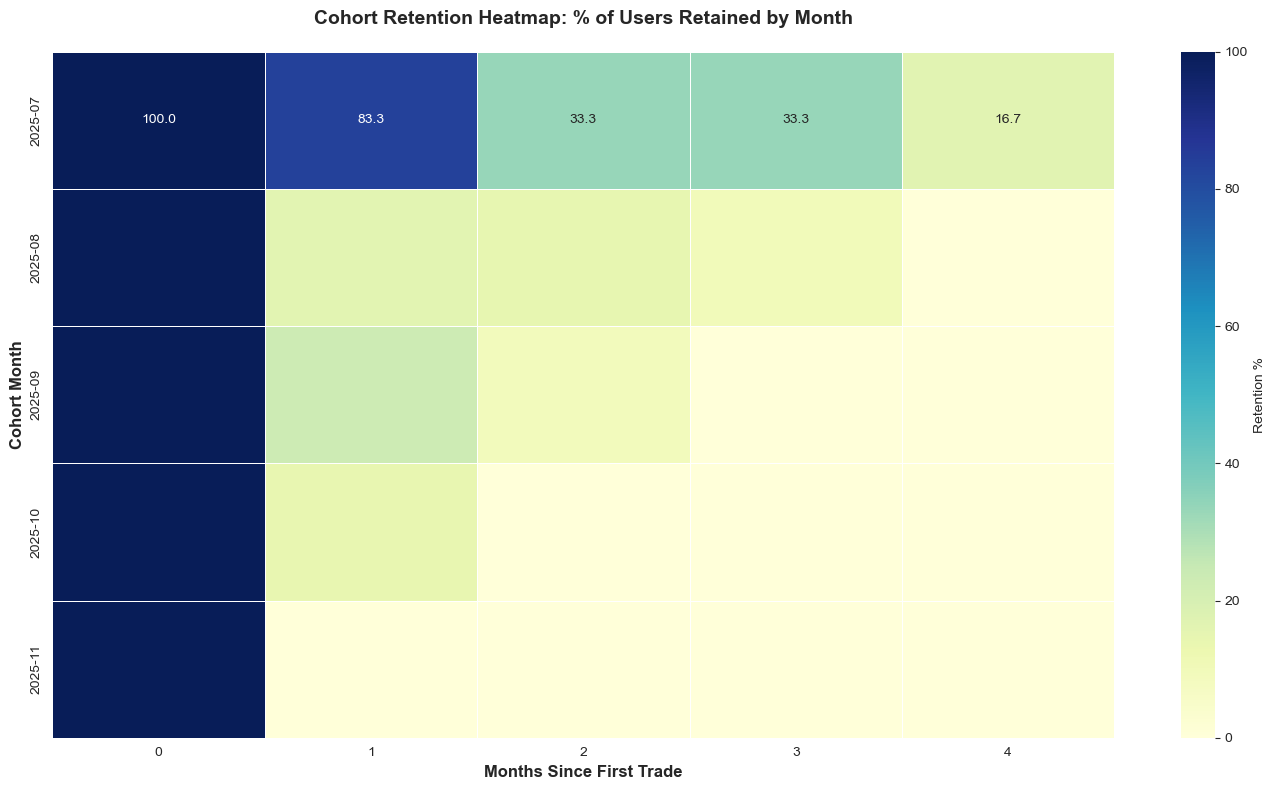

USER ACQUISITION & COHORT RETENTION ANALYSIS

2025-07 cohort:
  First month cohort size: 6 users
  Month 2 retention: 5 users (83.3% retained)

2025-08 cohort:
  First month cohort size: 61 users
  Month 2 retention: 10 users (16.4% retained)

2025-09 cohort:
  First month cohort size: 43 users
  Month 2 retention: 10 users (23.3% retained)

2025-10 cohort:
  First month cohort size: 28 users
  Month 2 retention: 4 users (14.3% retained)

2025-11 cohort:
  First month cohort size: 29 users
  Month 2 retention: No data

Overall Statistics:
  Average Month 2 retention: 34.3%
  Average Month 3+ retention: 19.5%

Trend: Month 2 retention is declining (14.3% → 0.0%)


In [24]:
# CELL 8: User Acquisition & Cohort Retention

user_col = 'from_address' if 'user_address' not in analysis_df.columns else 'user_address'

if user_col in analysis_df.columns and 'timestamp' in analysis_df.columns:
    # Filter to valid timestamps
    retention_df = analysis_df[analysis_df['timestamp'].notna()].copy()
    
    if len(retention_df) > 0:
        # Calculate first trade date per user (cohort month)
        user_first_trade = retention_df.groupby(user_col)['timestamp'].min().reset_index()
        user_first_trade.columns = [user_col, 'first_trade_date']
        user_first_trade['cohort_month'] = pd.to_datetime(user_first_trade['first_trade_date']).dt.to_period('M').astype(str)
        
        # Merge back to main dataframe
        retention_df = retention_df.merge(user_first_trade, on=user_col, how='left')
        retention_df['trade_month'] = pd.to_datetime(retention_df['timestamp']).dt.to_period('M').astype(str)
        
        # Calculate months since first trade
        def calculate_months_diff(row):
            """Calculate months difference between two period strings"""
            try:
                if pd.isna(row['trade_month']) or pd.isna(row['cohort_month']):
                    return 0
                trade_period = pd.Period(row['trade_month'])
                cohort_period = pd.Period(row['cohort_month'])
                return (trade_period - cohort_period).n
            except:
                return 0
        
        retention_df['months_since_first'] = retention_df.apply(calculate_months_diff, axis=1)
        
        # Create cohort retention table
        cohort_retention = retention_df.groupby(['cohort_month', 'months_since_first'])[user_col].nunique().reset_index()
        cohort_retention.columns = ['cohort_month', 'months_since_first', 'user_count']
        
        # Get first month cohort size for each cohort
        first_month_size = cohort_retention[cohort_retention['months_since_first'] == 0].set_index('cohort_month')['user_count']
        
        # Calculate retention percentage
        cohort_retention = cohort_retention.merge(first_month_size.reset_index(), on='cohort_month', how='left', suffixes=('', '_first'))
        cohort_retention.columns = ['cohort_month', 'months_since_first', 'user_count', 'first_month_size']
        cohort_retention['retention_pct'] = (cohort_retention['user_count'] / cohort_retention['first_month_size'] * 100).round(1)
        
        # Pivot for heatmap
        cohort_pivot = cohort_retention.pivot(index='cohort_month', columns='months_since_first', values='retention_pct').fillna(0)
        
        # Create visualization
        fig, ax = plt.subplots(figsize=(14, 8))
        
        # Create heatmap with retention percentages
        sns.heatmap(cohort_pivot, annot=True, fmt='.1f', cmap='YlGnBu', 
                    cbar_kws={'label': 'Retention %'}, ax=ax, linewidths=0.5, vmin=0, vmax=100)
        ax.set_xlabel('Months Since First Trade', fontsize=12, fontweight='bold')
        ax.set_ylabel('Cohort Month', fontsize=12, fontweight='bold')
        ax.set_title('Cohort Retention Heatmap: % of Users Retained by Month', 
                    fontsize=14, fontweight='bold', pad=20)
        
        plt.tight_layout()
        plt.show()
        
        # Calculate summary statistics
        month_2_retention = cohort_retention[cohort_retention['months_since_first'] == 1]['retention_pct'].mean()
        month_3_plus_retention = cohort_retention[cohort_retention['months_since_first'] >= 2]['retention_pct'].mean()
        
        # Print summary
        print("=" * 70)
        print("USER ACQUISITION & COHORT RETENTION ANALYSIS")
        print("=" * 70)
        
        # Show cohort breakdown
        for cohort in sorted(cohort_retention['cohort_month'].unique()):
            cohort_data = cohort_retention[cohort_retention['cohort_month'] == cohort].sort_values('months_since_first')
            first_month_size = cohort_data[cohort_data['months_since_first'] == 0]['user_count'].iloc[0] if len(cohort_data[cohort_data['months_since_first'] == 0]) > 0 else 0
            
            if first_month_size > 0:
                month_2_data = cohort_data[cohort_data['months_since_first'] == 1]
                month_2_count = month_2_data['user_count'].iloc[0] if len(month_2_data) > 0 else 0
                month_2_pct = month_2_data['retention_pct'].iloc[0] if len(month_2_data) > 0 else 0
                
                print(f"\n{cohort} cohort:")
                print(f"  First month cohort size: {first_month_size:,} users")
                if month_2_count > 0:
                    print(f"  Month 2 retention: {month_2_count:,} users ({month_2_pct:.1f}% retained)")
                else:
                    print(f"  Month 2 retention: No data")
        
        print(f"\nOverall Statistics:")
        print(f"  Average Month 2 retention: {month_2_retention:.1f}%")
        print(f"  Average Month 3+ retention: {month_3_plus_retention:.1f}%")
        
        # Trend analysis
        if len(cohort_pivot) >= 2:
            recent_cohorts = cohort_pivot.tail(2)
            if len(recent_cohorts.columns) >= 2:
                recent_month2 = recent_cohorts.iloc[-1].get(1, 0)
                prev_month2 = recent_cohorts.iloc[-2].get(1, 0) if len(recent_cohorts) >= 2 else 0
                if prev_month2 > 0:
                    trend = "improving" if recent_month2 > prev_month2 else "declining"
                    print(f"\nTrend: Month 2 retention is {trend} ({prev_month2:.1f}% → {recent_month2:.1f}%)")
        
        print("=" * 70)
    else:
        print("⚠ No valid timestamp data available for retention analysis")
else:
    print("⚠ Missing required columns: 'user_address'/'from_address' and/or 'timestamp'")


### CELL 9: Slippage & Execution Quality Analysis

**Business Impact:** Is execution competitive? Are users getting good prices?

**Goal:** Analyze swap execution quality and slippage to assess competitiveness.


⚠ WARNING: USD values not available. Attempting fallback calculation...
⚠ NOTE: This calculation may be inaccurate if amounts are in different asset units
⚠ Using raw amounts (median: $19) - assuming USD values
✓ Analyzing 433 transactions with valid slippage data


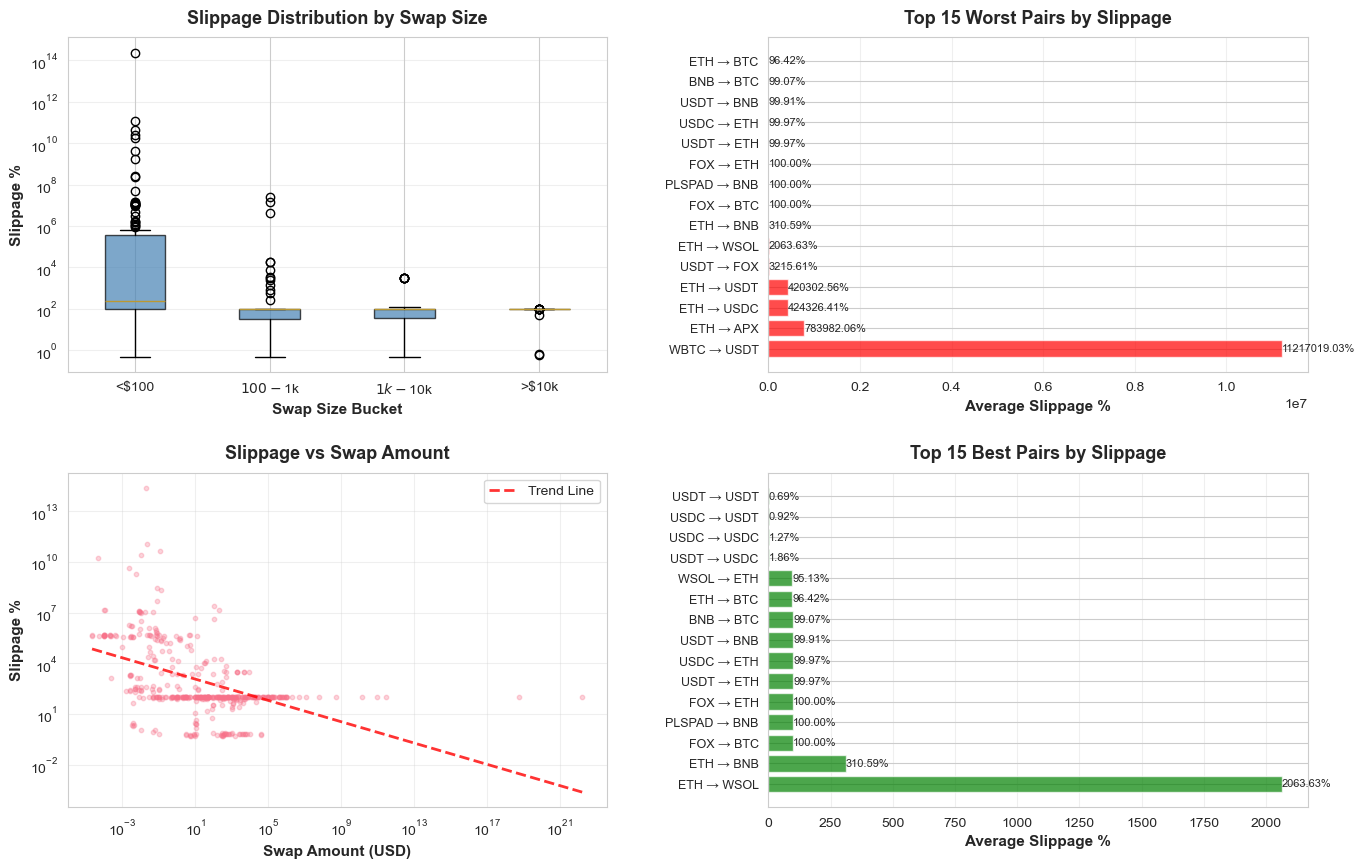

SLIPPAGE & EXECUTION QUALITY ANALYSIS

Total transactions analyzed: 433
Transactions excluded (invalid slippage): 0

Slippage by Swap Size (with transaction counts):
  Bucket  Transactions  Median Slippage %  Mean Slippage %    Std Dev %
$1k-$10k            53          98.312650     4.180537e+02 9.956342e+02
$100-$1k            66          99.913632     6.503790e+05 3.472083e+06
   >$10k            58          99.993913     9.554105e+01 1.921695e+01
   <$100           256         249.696534     9.426279e+11 1.506906e+13

Overall Statistics:
  Median slippage: 99.99%
  Mean slippage: 557304382329.35%
  Large orders (>$10k) slippage: 99.99% (58 transactions)

Most volatile pair: WBTC → USDT (avg slippage: 11217019.03%, 5 transactions)
Most stable pair: USDT → USDT (avg slippage: 0.69%, 8 transactions)


In [25]:
# CELL 9: Slippage & Execution Quality Analysis

# IMPORTANT: Slippage must be calculated using USD values, not raw asset amounts
# Raw amounts are different assets (e.g., 1 ETH vs 0.05 BTC) and cannot be directly compared

if 'from_amount' in analysis_df.columns and 'to_amount' in analysis_df.columns:
    slippage_df = analysis_df[(analysis_df['from_amount'] > 0) & (analysis_df['to_amount'] > 0)].copy()
    
    # Check if USD values are available
    has_usd_values = 'from_amount_usd' in slippage_df.columns and 'to_amount_usd' in slippage_df.columns
    
    if has_usd_values:
        # Use USD values for accurate slippage calculation
        # Slippage = (input_value_usd - output_value_usd) / input_value_usd * 100
        # This represents the total "cost" including fees and price impact
        slippage_df['slippage_pct'] = abs(
            (slippage_df['from_amount_usd'] - slippage_df['to_amount_usd']) / 
            slippage_df['from_amount_usd'] * 100
        )
        print("✓ Using USD values for slippage calculation")
    else:
        # Fallback: Try to estimate using from_amount if it's already in USD
        # This is less accurate but better than comparing different assets
        print("⚠ WARNING: USD values not available. Attempting fallback calculation...")
        print("⚠ NOTE: This calculation may be inaccurate if amounts are in different asset units")
        
        # Check if from_amount appears to be in USD (reasonable range)
        # If most values are > 1 and < 10M, likely USD
        median_amount = slippage_df['from_amount'].median()
        if 1 < median_amount < 10_000_000:
            slippage_df['slippage_pct'] = abs(
                (slippage_df['from_amount'] - slippage_df['to_amount']) / 
                slippage_df['from_amount'] * 100
            )
            print(f"⚠ Using raw amounts (median: ${median_amount:,.0f}) - assuming USD values")
        else:
            print("✗ ERROR: Cannot calculate slippage - amounts appear to be in different asset units")
            print("✗ Please ensure 'from_amount_usd' and 'to_amount_usd' columns are available")
            slippage_df['slippage_pct'] = np.nan
    
    # Create swap size buckets
    def assign_size_bucket(amount):
        if amount < 100:
            return '<$100'
        elif amount < 1000:
            return '$100-$1k'
        elif amount < 10000:
            return '$1k-$10k'
        else:
            return '>$10k'
    
    # Use USD amount for bucket assignment if available
    amount_col = 'from_amount_usd' if has_usd_values and 'from_amount_usd' in slippage_df.columns else 'from_amount'
    slippage_df['swap_size_bucket'] = slippage_df[amount_col].apply(assign_size_bucket)
    
    # Filter out invalid slippage values (NaN)
    valid_slippage_df = slippage_df[slippage_df['slippage_pct'].notna()].copy()
    
    if len(valid_slippage_df) == 0:
        print("✗ ERROR: No valid slippage values calculated. Cannot proceed with analysis.")
        print("✗ Please check that USD values are available or amounts are in consistent units.")
    else:
        print(f"✓ Analyzing {len(valid_slippage_df):,} transactions with valid slippage data")
        
        # Analyze by bucket
        bucket_analysis = valid_slippage_df.groupby('swap_size_bucket').agg({
            'slippage_pct': ['median', 'mean', 'std', 'count']
        }).reset_index()
        bucket_analysis.columns = ['bucket', 'median_slippage', 'mean_slippage', 'std_slippage', 'transaction_count']
        bucket_analysis = bucket_analysis.sort_values('median_slippage')
    
        # Analyze by asset pair if available
        if 'asset_pair' in valid_slippage_df.columns:
            pair_slippage = valid_slippage_df.groupby('asset_pair').agg({
                'slippage_pct': 'mean',
                'from_amount': 'count'
            }).reset_index()
            pair_slippage.columns = ['asset_pair', 'avg_slippage', 'transaction_count']
            pair_slippage = pair_slippage[pair_slippage['transaction_count'] >= 5]  # Min 5 swaps for reliability
            pair_slippage = pair_slippage.sort_values('avg_slippage')
            
            worst_pairs = pair_slippage.tail(15)
            best_pairs = pair_slippage.head(15)
        else:
            worst_pairs = pd.DataFrame()
            best_pairs = pd.DataFrame()
        
        # Create visualizations
        fig = plt.figure(figsize=(16, 10))
        gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)
        
        # Top-left: Box plot (size vs slippage)
        ax1 = fig.add_subplot(gs[0, 0])
        bucket_order = ['<$100', '$100-$1k', '$1k-$10k', '>$10k']
        bucket_data = [valid_slippage_df[valid_slippage_df['swap_size_bucket'] == b]['slippage_pct'].values for b in bucket_order if b in valid_slippage_df['swap_size_bucket'].values]
        bucket_labels = [b for b in bucket_order if b in valid_slippage_df['swap_size_bucket'].values]
        bp = ax1.boxplot(bucket_data, labels=bucket_labels, patch_artist=True)
        for patch in bp['boxes']:
            patch.set_facecolor('steelblue')
            patch.set_alpha(0.7)
        ax1.set_xlabel('Swap Size Bucket', fontsize=11, fontweight='bold')
        ax1.set_ylabel('Slippage %', fontsize=11, fontweight='bold')
        ax1.set_title('Slippage Distribution by Swap Size', fontsize=13, fontweight='bold', pad=10)
        ax1.grid(True, alpha=0.3, axis='y')
        ax1.set_yscale('log')
        
        # Top-right: Bar chart (worst pairs)
        ax2 = fig.add_subplot(gs[0, 1])
        if len(worst_pairs) > 0:
            bars = ax2.barh(range(len(worst_pairs)), worst_pairs['avg_slippage'], color='red', alpha=0.7)
            ax2.set_yticks(range(len(worst_pairs)))
            ax2.set_yticklabels(worst_pairs['asset_pair'], fontsize=9)
            ax2.set_xlabel('Average Slippage %', fontsize=11, fontweight='bold')
            ax2.set_title('Top 15 Worst Pairs by Slippage', fontsize=13, fontweight='bold', pad=10)
            ax2.invert_yaxis()
            ax2.grid(True, alpha=0.3, axis='x')
            
            # Add value labels
            for i, (idx, row) in enumerate(worst_pairs.iterrows()):
                ax2.text(row['avg_slippage'], i, f'{row["avg_slippage"]:.2f}%', 
                        va='center', ha='left', fontsize=8)
        else:
            ax2.text(0.5, 0.5, 'Insufficient pair data', ha='center', va='center', transform=ax2.transAxes)
            ax2.set_title('Top 15 Worst Pairs by Slippage', fontsize=13, fontweight='bold')
    
        # Bottom-left: Scatter (amount vs slippage with trend)
        ax3 = fig.add_subplot(gs[1, 0])
        sample_size = min(1000, len(valid_slippage_df))
        sample_df = valid_slippage_df.sample(n=sample_size, random_state=42) if len(valid_slippage_df) > sample_size else valid_slippage_df
        scatter_amount_col = amount_col
        ax3.scatter(sample_df[scatter_amount_col], sample_df['slippage_pct'], alpha=0.3, s=10)
        
        # Add trend line
        if len(sample_df) > 10:
            z = np.polyfit(np.log(sample_df[scatter_amount_col] + 1), np.log(sample_df['slippage_pct'] + 0.01), 1)
            p = np.poly1d(z)
            x_trend = np.logspace(np.log10(sample_df[scatter_amount_col].min()), np.log10(sample_df[scatter_amount_col].max()), 100)
            y_trend = np.exp(p(np.log(x_trend)))
            ax3.plot(x_trend, y_trend, "r--", alpha=0.8, linewidth=2, label='Trend Line')
        
        ax3.set_xlabel('Swap Amount (USD)', fontsize=11, fontweight='bold')
        ax3.set_ylabel('Slippage %', fontsize=11, fontweight='bold')
        ax3.set_title('Slippage vs Swap Amount', fontsize=13, fontweight='bold', pad=10)
        ax3.set_xscale('log')
        ax3.set_yscale('log')
        ax3.grid(True, alpha=0.3)
        ax3.legend()
    
        # Bottom-right: Best pairs
        ax4 = fig.add_subplot(gs[1, 1])
        if len(best_pairs) > 0:
            bars = ax4.barh(range(len(best_pairs)), best_pairs['avg_slippage'], color='green', alpha=0.7)
            ax4.set_yticks(range(len(best_pairs)))
            ax4.set_yticklabels(best_pairs['asset_pair'], fontsize=9)
            ax4.set_xlabel('Average Slippage %', fontsize=11, fontweight='bold')
            ax4.set_title('Top 15 Best Pairs by Slippage', fontsize=13, fontweight='bold', pad=10)
            ax4.invert_yaxis()
            ax4.grid(True, alpha=0.3, axis='x')
            
            # Add value labels
            for i, (idx, row) in enumerate(best_pairs.iterrows()):
                ax4.text(row['avg_slippage'], i, f'{row["avg_slippage"]:.2f}%', 
                        va='center', ha='left', fontsize=8)
        else:
            ax4.text(0.5, 0.5, 'Insufficient pair data', ha='center', va='center', transform=ax4.transAxes)
            ax4.set_title('Top 15 Best Pairs by Slippage', fontsize=13, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
    
        # Print summary
        print("=" * 70)
        print("SLIPPAGE & EXECUTION QUALITY ANALYSIS")
        print("=" * 70)
        
        print(f"\nTotal transactions analyzed: {len(valid_slippage_df):,}")
        print(f"Transactions excluded (invalid slippage): {len(slippage_df) - len(valid_slippage_df):,}")
        
        print("\nSlippage by Swap Size (with transaction counts):")
        display_bucket = bucket_analysis[['bucket', 'transaction_count', 'median_slippage', 'mean_slippage', 'std_slippage']].copy()
        display_bucket.columns = ['Bucket', 'Transactions', 'Median Slippage %', 'Mean Slippage %', 'Std Dev %']
        print(display_bucket.to_string(index=False))
        
        overall_median = valid_slippage_df['slippage_pct'].median()
        overall_mean = valid_slippage_df['slippage_pct'].mean()
        large_order_data = valid_slippage_df[valid_slippage_df['swap_size_bucket'] == '>$10k']
        large_order_slippage = large_order_data['slippage_pct'].median() if len(large_order_data) > 0 else None
        large_order_count = len(large_order_data)
        
        print(f"\nOverall Statistics:")
        print(f"  Median slippage: {overall_median:.2f}%")
        print(f"  Mean slippage: {overall_mean:.2f}%")
        if large_order_slippage is not None:
            print(f"  Large orders (>$10k) slippage: {large_order_slippage:.2f}% ({large_order_count:,} transactions)")
        
        if len(worst_pairs) > 0:
            worst_pair = worst_pairs.iloc[-1]
            print(f"\nMost volatile pair: {worst_pair['asset_pair']} (avg slippage: {worst_pair['avg_slippage']:.2f}%, {worst_pair['transaction_count']:.0f} transactions)")
        
        if len(best_pairs) > 0:
            best_pair = best_pairs.iloc[0]
            print(f"Most stable pair: {best_pair['asset_pair']} (avg slippage: {best_pair['avg_slippage']:.2f}%, {best_pair['transaction_count']:.0f} transactions)")
        
        print("=" * 70)
else:
    print("⚠ Missing required columns: 'from_amount' and/or 'to_amount'")


### CELL 11: Competitor Partner Benchmarking

**Business Impact:** How do we compare to CoW Swap, Relay, 1inch?

**Goal:** Compare THORChain performance against other affiliate partners.


In [26]:
# CELL 11: Competitor Partner Benchmarking

# Check if partner_name exists, otherwise use source_file as proxy
if 'partner_name' in analysis_df.columns:
    partner_col = 'partner_name'
elif 'source_file' in analysis_df.columns:
    # Extract partner from source_file if it contains partner info
    analysis_df['partner_name'] = 'THORChain'  # Default to THORChain
    partner_col = 'partner_name'
    print("⚠ Using default partner_name='THORChain'. Add 'partner_name' column for multi-partner comparison.")
else:
    partner_col = None
    print("⚠ No partner_name or source_file column found. Creating single-partner analysis.")

if partner_col and partner_col in analysis_df.columns:
    user_col = 'from_address' if 'user_address' not in analysis_df.columns else 'user_address'
    
    # Group by partner and calculate metrics
    partner_stats = analysis_df.groupby(partner_col).agg({
        'from_amount': ['sum', 'count', 'mean'],
        'fee_usd': 'sum',
        user_col: 'nunique' if user_col in analysis_df.columns else 'count'
    }).reset_index()
    
    partner_stats.columns = [partner_col, 'total_volume', 'transaction_count', 'avg_transaction_size', 
                            'total_fees', 'user_count']
    
    # Calculate additional metrics
    partner_stats['avg_revenue_per_user'] = partner_stats['total_fees'] / partner_stats['user_count'].replace(0, 1)
    partner_stats['transactions_per_user'] = partner_stats['transaction_count'] / partner_stats['user_count'].replace(0, 1)
    
    # Calculate market share
    total_volume_all = partner_stats['total_volume'].sum()
    total_fees_all = partner_stats['total_fees'].sum()
    partner_stats['volume_market_share'] = (partner_stats['total_volume'] / total_volume_all * 100).round(2)
    partner_stats['fees_market_share'] = (partner_stats['total_fees'] / total_fees_all * 100).round(2)
    
    # Rank partners by each metric
    partner_stats['rank_by_volume'] = partner_stats['total_volume'].rank(ascending=False, method='min').astype(int)
    partner_stats['rank_by_fees'] = partner_stats['total_fees'].rank(ascending=False, method='min').astype(int)
    partner_stats['rank_by_ltv'] = partner_stats['avg_revenue_per_user'].rank(ascending=False, method='min').astype(int)
    partner_stats['rank_by_users'] = partner_stats['user_count'].rank(ascending=False, method='min').astype(int)
    
    partner_stats = partner_stats.sort_values('total_volume', ascending=False)
    
    # Create visualizations
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Top-left: Bar chart (partner vs total_volume)
    bars1 = ax1.bar(range(len(partner_stats)), partner_stats['total_volume'], 
                    color=sns.color_palette("husl", len(partner_stats)), alpha=0.7)
    ax1.set_xlabel('Partner', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Total Volume (USD)', fontsize=11, fontweight='bold')
    ax1.set_title('Partner Comparison: Total Volume', fontsize=13, fontweight='bold', pad=10)
    ax1.set_xticks(range(len(partner_stats)))
    ax1.set_xticklabels(partner_stats[partner_col], rotation=45, ha='right', fontsize=9)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, (idx, row) in enumerate(partner_stats.iterrows()):
        ax1.text(i, row['total_volume'], f'${row["total_volume"]/1e6:.1f}M', 
                ha='center', va='bottom', fontsize=8)
    
    # Top-right: Bar chart (partner vs avg_revenue_per_user)
    bars2 = ax2.bar(range(len(partner_stats)), partner_stats['avg_revenue_per_user'], 
                    color=sns.color_palette("husl", len(partner_stats)), alpha=0.7)
    ax2.set_xlabel('Partner', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Avg Revenue per User (USD)', fontsize=11, fontweight='bold')
    ax2.set_title('Partner Comparison: Average LTV', fontsize=13, fontweight='bold', pad=10)
    ax2.set_xticks(range(len(partner_stats)))
    ax2.set_xticklabels(partner_stats[partner_col], rotation=45, ha='right', fontsize=9)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, (idx, row) in enumerate(partner_stats.iterrows()):
        ax2.text(i, row['avg_revenue_per_user'], f'${row["avg_revenue_per_user"]:.0f}', 
                ha='center', va='bottom', fontsize=8)
    
    # Bottom-left: Heatmap (partner × metrics)
    metrics_for_heatmap = partner_stats[['total_volume', 'user_count', 'avg_revenue_per_user', 'transactions_per_user']].copy()
    # Normalize for heatmap
    metrics_normalized = (metrics_for_heatmap - metrics_for_heatmap.min()) / (metrics_for_heatmap.max() - metrics_for_heatmap.min())
    metrics_normalized.index = partner_stats[partner_col]
    metrics_normalized.columns = ['Volume', 'Users', 'LTV', 'Tx/User']
    
    sns.heatmap(metrics_normalized.T, annot=True, fmt='.2f', cmap='YlGnBu', ax=ax3, 
                cbar_kws={'label': 'Normalized Score'}, linewidths=0.5)
    ax3.set_xlabel('Partner', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Metric', fontsize=11, fontweight='bold')
    ax3.set_title('Partner Performance Heatmap', fontsize=13, fontweight='bold', pad=10)
    
    # Bottom-right: Pie chart (market share)
    colors_pie = sns.color_palette("husl", len(partner_stats))
    wedges, texts, autotexts = ax4.pie(partner_stats['volume_market_share'], labels=partner_stats[partner_col], 
                                       autopct='%1.1f%%', colors=colors_pie, startangle=90)
    ax4.set_title('Market Share by Volume', fontsize=13, fontweight='bold', pad=10)
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(10)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("=" * 70)
    print("COMPETITOR PARTNER BENCHMARKING")
    print("=" * 70)
    
    print("\nPartner Performance Table:")
    display_cols = [partner_col, 'total_volume', 'user_count', 'total_fees', 'avg_revenue_per_user', 
                   'transactions_per_user', 'rank_by_volume', 'rank_by_ltv']
    print(partner_stats[display_cols].to_string(index=False))
    
    # Find THORChain ranking
    thorchain_data = partner_stats[partner_stats[partner_col].str.contains('THORChain', case=False, na=False)]
    if len(thorchain_data) > 0:
        thorchain = thorchain_data.iloc[0]
        print(f"\nTHORChain Performance:")
        print(f"  Rank by volume: #{thorchain['rank_by_volume']}")
        print(f"  Rank by LTV: #{thorchain['rank_by_ltv']}")
        print(f"  Rank by users: #{thorchain['rank_by_users']}")
        print(f"  Market share: {thorchain['volume_market_share']:.1f}%")
        print(f"  Avg revenue per user: ${thorchain['avg_revenue_per_user']:.2f}")
        
        # Comparison insights
        if thorchain['rank_by_volume'] <= 2:
            print(f"  ✓ Strong volume performance (top 2)")
        else:
            print(f"  ⚠ Volume ranking could be improved")
        
        if thorchain['rank_by_ltv'] <= 2:
            print(f"  ✓ Strong user quality (top 2)")
        else:
            print(f"  ⚠ User quality ranking could be improved")
    else:
        print("\n⚠ THORChain data not found in partner comparison")
    
    print("=" * 70)
else:
    print("⚠ Partner comparison requires 'partner_name' column or partner identification in source_file")


⚠ No partner_name or source_file column found. Creating single-partner analysis.
⚠ Partner comparison requires 'partner_name' column or partner identification in source_file


### CELL 15: User Engagement Lifecycle

**Business Impact:** When do users churn? Can we re-engage them?

**Goal:** Map user lifecycle stages and calculate engagement decay.


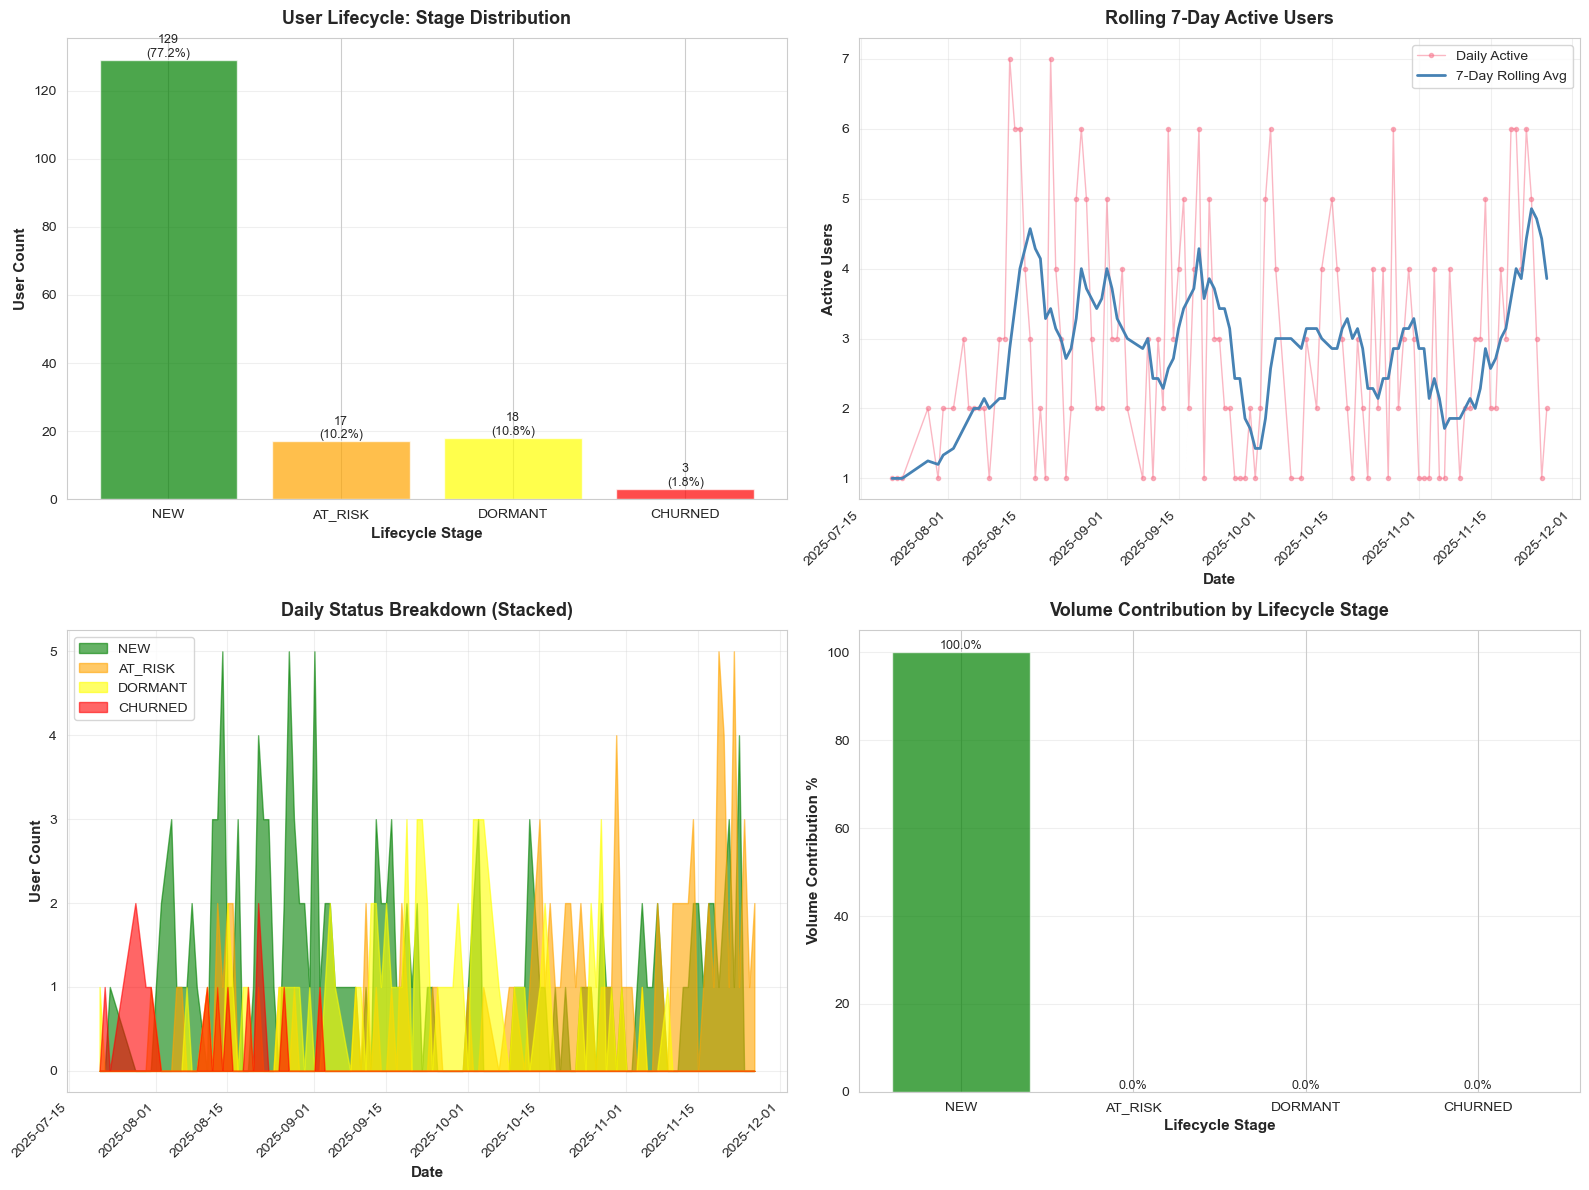

USER ENGAGEMENT LIFECYCLE ANALYSIS

Lifecycle Stage Breakdown:
  stage  user_count  pct_of_total  total_volume  volume_contribution_pct  avg_transactions  avg_days_active
    NEW         129         77.25  1.718149e+22                    100.0          1.279070         0.224806
AT_RISK          17         10.18  1.143960e+11                      0.0          8.000000        53.882353
DORMANT          18         10.78  5.101717e+08                      0.0          6.222222        41.222222
CHURNED           3          1.80  5.927270e+01                      0.0          7.333333        25.666667

Key Metrics:
  Median user lifetime: 0 days
  Median days to churn: 109 days
  Re-activation rate: 0.0%

⚠️ INTERVENTION ZONE:
  At-Risk users: 17 (10.2% of total)
  Volume contribution: 0.0%
  Recommendation: Target re-engagement campaigns for At-Risk segment


In [27]:
# CELL 15: User Engagement Lifecycle

user_col = 'from_address' if 'user_address' not in analysis_df.columns else 'user_address'

if user_col in analysis_df.columns and 'timestamp' in analysis_df.columns:
    # Filter to valid timestamps
    lifecycle_df = analysis_df[analysis_df['timestamp'].notna()].copy()
    
    if len(lifecycle_df) > 0:
        # Calculate user lifecycle metrics
        user_lifecycle = lifecycle_df.groupby(user_col).agg({
            'timestamp': ['min', 'max', 'count'],
            'from_amount': 'sum'
        }).reset_index()
        user_lifecycle.columns = [user_col, 'first_trade_date', 'last_trade_date', 'transaction_count', 'total_volume']
        
        # Calculate time metrics
        now = pd.Timestamp.now()
        user_lifecycle['days_active'] = (user_lifecycle['last_trade_date'] - user_lifecycle['first_trade_date']).dt.days
        user_lifecycle['days_since_last_trade'] = (now - user_lifecycle['last_trade_date']).dt.days
        
        # Classify users by lifecycle stage
        def classify_lifecycle_stage(row):
            days_since_last = row['days_since_last_trade']
            days_active = row['days_active']
            
            if days_active < 7:
                return 'NEW'
            elif days_since_last < 7:
                return 'ACTIVE'
            elif days_since_last < 30:
                return 'AT_RISK'
            elif days_since_last < 90:
                return 'DORMANT'
            else:
                return 'CHURNED'
        
        user_lifecycle['lifecycle_stage'] = user_lifecycle.apply(classify_lifecycle_stage, axis=1)
        
        # Aggregate by stage
        stage_analysis = user_lifecycle.groupby('lifecycle_stage').agg({
            user_col: 'count',
            'total_volume': 'sum',
            'transaction_count': 'sum',
            'days_since_last_trade': 'mean',
            'days_active': 'mean'
        }).reset_index()
        stage_analysis.columns = ['stage', 'user_count', 'total_volume', 'total_transactions', 
                                 'avg_days_since_last', 'avg_days_active']
        
        total_users = user_lifecycle[user_col].nunique()
        stage_analysis['pct_of_total'] = (stage_analysis['user_count'] / total_users * 100).round(2)
        stage_analysis['volume_contribution_pct'] = (stage_analysis['total_volume'] / user_lifecycle['total_volume'].sum() * 100).round(2)
        stage_analysis['avg_transactions'] = stage_analysis['total_transactions'] / stage_analysis['user_count']
        
        # Calculate re-activation rate (users who moved from CHURNED back to ACTIVE)
        # This is simplified - would need historical tracking for accurate measurement
        churned_users = set(user_lifecycle[user_lifecycle['lifecycle_stage'] == 'CHURNED'][user_col])
        active_users = set(user_lifecycle[user_lifecycle['lifecycle_stage'] == 'ACTIVE'][user_col])
        reactivated = len(churned_users & active_users)  # Users in both sets
        reactivation_rate = (reactivated / len(churned_users) * 100) if len(churned_users) > 0 else 0
        
        # Sort by stage order
        stage_order = ['NEW', 'ACTIVE', 'AT_RISK', 'DORMANT', 'CHURNED']
        stage_analysis['stage_num'] = stage_analysis['stage'].apply(lambda x: stage_order.index(x) if x in stage_order else 999)
        stage_analysis = stage_analysis.sort_values('stage_num').reset_index(drop=True)
        
        # Create visualizations
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        # Top-left: Waterfall chart (NEW → ACTIVE → AT_RISK → DORMANT → CHURNED)
        x_pos = range(len(stage_analysis))
        colors_waterfall = {'NEW': 'green', 'ACTIVE': 'blue', 'AT_RISK': 'orange', 'DORMANT': 'yellow', 'CHURNED': 'red'}
        stage_colors = [colors_waterfall.get(stage, 'gray') for stage in stage_analysis['stage']]
        
        bars = ax1.bar(x_pos, stage_analysis['user_count'], color=stage_colors, alpha=0.7)
        ax1.set_xlabel('Lifecycle Stage', fontsize=11, fontweight='bold')
        ax1.set_ylabel('User Count', fontsize=11, fontweight='bold')
        ax1.set_title('User Lifecycle: Stage Distribution', fontsize=13, fontweight='bold', pad=10)
        ax1.set_xticks(x_pos)
        ax1.set_xticklabels(stage_analysis['stage'], fontsize=10)
        ax1.grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for i, (idx, row) in enumerate(stage_analysis.iterrows()):
            ax1.text(i, row['user_count'], f"{row['user_count']:,}\n({row['pct_of_total']:.1f}%)", 
                    ha='center', va='bottom', fontsize=9)
        
        # Top-right: Line chart (rolling 7-day active users)
        if 'timestamp' in lifecycle_df.columns:
            lifecycle_df['date'] = pd.to_datetime(lifecycle_df['timestamp']).dt.date
            daily_active = lifecycle_df.groupby('date')[user_col].nunique().reset_index()
            daily_active.columns = ['date', 'active_users']
            daily_active['date'] = pd.to_datetime(daily_active['date'])
            daily_active = daily_active.sort_values('date')
            daily_active['rolling_7d'] = daily_active['active_users'].rolling(window=7, min_periods=1).mean()
            
            ax2.plot(daily_active['date'], daily_active['active_users'], 'o-', alpha=0.5, label='Daily Active', linewidth=1, markersize=3)
            ax2.plot(daily_active['date'], daily_active['rolling_7d'], '-', linewidth=2, label='7-Day Rolling Avg', color='steelblue')
            ax2.set_xlabel('Date', fontsize=11, fontweight='bold')
            ax2.set_ylabel('Active Users', fontsize=11, fontweight='bold')
            ax2.set_title('Rolling 7-Day Active Users', fontsize=13, fontweight='bold', pad=10)
            ax2.legend()
            ax2.grid(True, alpha=0.3)
            plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
        else:
            ax2.text(0.5, 0.5, 'Timestamp data not available', ha='center', va='center', transform=ax2.transAxes)
            ax2.set_title('Rolling 7-Day Active Users', fontsize=13, fontweight='bold')
        
        # Bottom-left: Stacked area (daily status breakdown)
        if 'timestamp' in lifecycle_df.columns:
            # Calculate daily status counts
            lifecycle_df['date'] = pd.to_datetime(lifecycle_df['timestamp']).dt.date
            daily_status = []
            for date in sorted(lifecycle_df['date'].unique()):
                date_users = lifecycle_df[lifecycle_df['date'] == date][user_col].unique()
                date_lifecycle = user_lifecycle[user_lifecycle[user_col].isin(date_users)]
                status_counts = date_lifecycle['lifecycle_stage'].value_counts().to_dict()
                status_counts['date'] = date
                daily_status.append(status_counts)
            
            daily_status_df = pd.DataFrame(daily_status).fillna(0)
            daily_status_df['date'] = pd.to_datetime(daily_status_df['date'])
            daily_status_df = daily_status_df.sort_values('date')
            
            for stage in stage_order:
                if stage in daily_status_df.columns:
                    ax3.fill_between(daily_status_df['date'], 0, daily_status_df[stage], 
                                   label=stage, alpha=0.6, color=colors_waterfall.get(stage, 'gray'))
            
            ax3.set_xlabel('Date', fontsize=11, fontweight='bold')
            ax3.set_ylabel('User Count', fontsize=11, fontweight='bold')
            ax3.set_title('Daily Status Breakdown (Stacked)', fontsize=13, fontweight='bold', pad=10)
            ax3.legend(loc='upper left')
            ax3.grid(True, alpha=0.3)
            plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')
        else:
            ax3.text(0.5, 0.5, 'Timestamp data not available', ha='center', va='center', transform=ax3.transAxes)
            ax3.set_title('Daily Status Breakdown', fontsize=13, fontweight='bold')
        
        # Bottom-right: Volume contribution by stage
        ax4.bar(x_pos, stage_analysis['volume_contribution_pct'], color=stage_colors, alpha=0.7)
        ax4.set_xlabel('Lifecycle Stage', fontsize=11, fontweight='bold')
        ax4.set_ylabel('Volume Contribution %', fontsize=11, fontweight='bold')
        ax4.set_title('Volume Contribution by Lifecycle Stage', fontsize=13, fontweight='bold', pad=10)
        ax4.set_xticks(x_pos)
        ax4.set_xticklabels(stage_analysis['stage'], fontsize=10)
        ax4.grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for i, (idx, row) in enumerate(stage_analysis.iterrows()):
            ax4.text(i, row['volume_contribution_pct'], f"{row['volume_contribution_pct']:.1f}%", 
                    ha='center', va='bottom', fontsize=9)
        
        plt.tight_layout()
        plt.show()
        
        # Print summary
        print("=" * 70)
        print("USER ENGAGEMENT LIFECYCLE ANALYSIS")
        print("=" * 70)
        
        print("\nLifecycle Stage Breakdown:")
        display_cols = ['stage', 'user_count', 'pct_of_total', 'total_volume', 'volume_contribution_pct', 
                       'avg_transactions', 'avg_days_active']
        print(stage_analysis[display_cols].to_string(index=False))
        
        # Calculate median metrics
        median_lifetime = user_lifecycle['days_active'].median()
        churned_users_data = user_lifecycle[user_lifecycle['lifecycle_stage'] == 'CHURNED']
        median_days_to_churn = churned_users_data['days_since_last_trade'].median() if len(churned_users_data) > 0 else None
        
        print(f"\nKey Metrics:")
        print(f"  Median user lifetime: {median_lifetime:.0f} days")
        if median_days_to_churn is not None:
            print(f"  Median days to churn: {median_days_to_churn:.0f} days")
        print(f"  Re-activation rate: {reactivation_rate:.1f}%")
        
        # Identify intervention zone
        at_risk_data = stage_analysis[stage_analysis['stage'] == 'AT_RISK']
        if len(at_risk_data) > 0:
            at_risk = at_risk_data.iloc[0]
            print(f"\n⚠️ INTERVENTION ZONE:")
            print(f"  At-Risk users: {at_risk['user_count']:,} ({at_risk['pct_of_total']:.1f}% of total)")
            print(f"  Volume contribution: {at_risk['volume_contribution_pct']:.1f}%")
            print(f"  Recommendation: Target re-engagement campaigns for At-Risk segment")
        
        print("=" * 70)
    else:
        print("⚠ No valid timestamp data available for lifecycle analysis")
else:
    print("⚠ Missing required columns: 'user_address'/'from_address' and/or 'timestamp'")


### CELL 16: Comparative Pair Performance (Stability × Volume)

**Business Impact:** Which pairs to promote vs avoid?

**Goal:** Classify asset pairs into performance quadrants based on volume and stability.


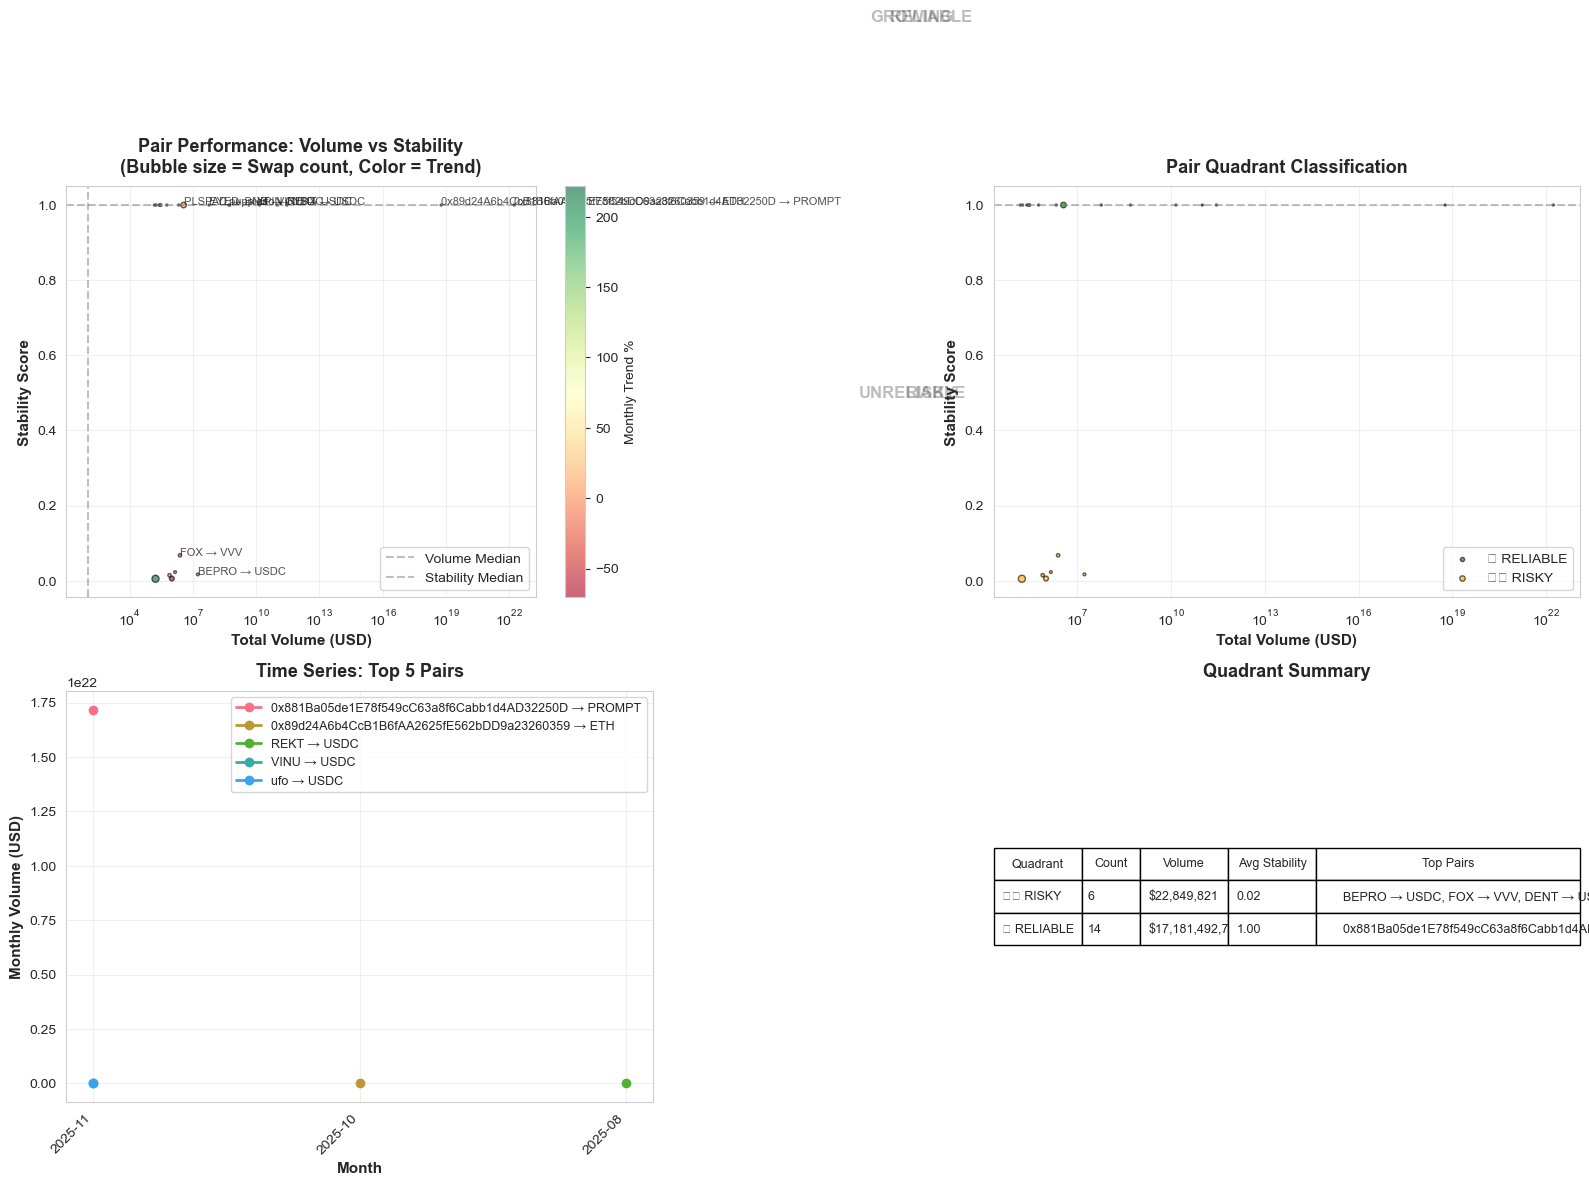

COMPARATIVE PAIR PERFORMANCE (STABILITY × VOLUME)

✓ RELIABLE:
  1. 0x881Ba05de1E78f549cC63a8f6Cabb1d4AD32250D → PROMPT: $17,175,593,150,809,999,671,296 volume, 1.00 stability, +0.0% MoM
  2. 0x89d24A6b4CcB1B6fAA2625fE562bDD9a23260359 → ETH: $5,899,570,310,000,000,000 volume, 1.00 stability, +0.0% MoM
  3. REKT → USDC: $284,209,329,645 volume, 1.00 stability, +0.0% MoM
  4. VINU → USDC: $100,000,000,000 volume, 1.00 stability, +0.0% MoM
  5. ufo → USDC: $14,316,465,517 volume, 1.00 stability, +0.0% MoM

⚠️ RISKY:
  1. BEPRO → USDC: $17,018,834 volume, 0.02 stability, +0.0% MoM
  2. FOX → VVV: $2,445,774 volume, 0.07 stability, -17.7% MoM
  3. DENT → USDC: $1,429,492 volume, 0.02 stability, +0.0% MoM
  4. FOX → BTC: $1,002,882 volume, 0.01 stability, -70.6% MoM
  5. BAS → BNB: $783,637 volume, 0.01 stability, +0.0% MoM

~ GROWING:
  1. AAVE → ASTER: $101 volume, 1.00 stability, +0.0% MoM
  2. MASK → USDC: $100 volume, 1.00 stability, +0.0% MoM
  3. WLFI → XRP: $100 volume, 1.00 stabilit

In [28]:
# CELL 16: Comparative Pair Performance (Stability × Volume)

if 'asset_pair' in analysis_df.columns and 'timestamp' in analysis_df.columns:
    pair_df = analysis_df[analysis_df['timestamp'].notna()].copy()
    
    if len(pair_df) > 0:
        # Calculate pair metrics
        pair_metrics = pair_df.groupby('asset_pair').agg({
            'from_amount': ['sum', 'count', 'mean'],
            'timestamp': lambda x: (x.max() - x.min()).days
        }).reset_index()
        pair_metrics.columns = ['asset_pair', 'total_volume', 'swap_count', 'avg_swap_size', 'days_active']
        
        # Calculate daily volume volatility
        pair_df['date'] = pd.to_datetime(pair_df['timestamp']).dt.date
        daily_volume = pair_df.groupby(['asset_pair', 'date'])['from_amount'].sum().reset_index()
        daily_volume.columns = ['asset_pair', 'date', 'daily_volume']
        
        daily_volatility = daily_volume.groupby('asset_pair')['daily_volume'].agg(['std', 'mean']).reset_index()
        daily_volatility.columns = ['asset_pair', 'volatility', 'mean_daily_volume']
        daily_volatility['volatility_pct'] = (daily_volatility['volatility'] / daily_volatility['mean_daily_volume'] * 100).fillna(0)
        
        # Merge metrics
        pair_analysis = pair_metrics.merge(daily_volatility[['asset_pair', 'volatility_pct']], on='asset_pair', how='left')
        pair_analysis['volatility_pct'] = pair_analysis['volatility_pct'].fillna(0)
        
        # Calculate stability score (inverse of volatility)
        pair_analysis['stability_score'] = 1 / (1 + pair_analysis['volatility_pct'])
        
        # Calculate monthly trend (current month vs previous month)
        pair_df['year_month'] = pd.to_datetime(pair_df['timestamp']).dt.to_period('M').astype(str)
        monthly_volume = pair_df.groupby(['asset_pair', 'year_month'])['from_amount'].sum().reset_index()
        monthly_volume.columns = ['asset_pair', 'year_month', 'monthly_volume']
        monthly_volume = monthly_volume.sort_values(['asset_pair', 'year_month'])
        
        monthly_volume['prev_month_volume'] = monthly_volume.groupby('asset_pair')['monthly_volume'].shift(1)
        monthly_volume['monthly_trend'] = ((monthly_volume['monthly_volume'] - monthly_volume['prev_month_volume']) / monthly_volume['prev_month_volume'] * 100).fillna(0)
        
        # Get latest month trend
        latest_month = monthly_volume.groupby('asset_pair').tail(1)[['asset_pair', 'monthly_trend']]
        pair_analysis = pair_analysis.merge(latest_month, on='asset_pair', how='left')
        pair_analysis['monthly_trend'] = pair_analysis['monthly_trend'].fillna(0)
        
        # Classify into quadrants
        volume_median = pair_analysis['total_volume'].median()
        stability_median = pair_analysis['stability_score'].median()
        
        def classify_quadrant(row):
            high_vol = row['total_volume'] >= volume_median
            high_stability = row['stability_score'] >= stability_median
            
            if high_vol and high_stability:
                return '✓ RELIABLE'
            elif high_vol and not high_stability:
                return '⚠️ RISKY'
            elif not high_vol and high_stability:
                return '~ GROWING'
            else:
                return '✗ UNRELIABLE'
        
        pair_analysis['quadrant'] = pair_analysis.apply(classify_quadrant, axis=1)
        
        # Filter to top pairs for analysis
        top_pairs = pair_analysis.nlargest(20, 'total_volume')
        
        # Create visualizations
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        # Top-left: Bubble chart (x=volume, y=stability, size=count, color=trend)
        scatter = ax1.scatter(top_pairs['total_volume'], top_pairs['stability_score'], 
                            s=top_pairs['swap_count']*2, c=top_pairs['monthly_trend'], 
                            cmap='RdYlGn', alpha=0.6, edgecolors='black', linewidth=1)
        
        # Add quadrant lines
        ax1.axvline(x=volume_median, color='gray', linestyle='--', alpha=0.5, label='Volume Median')
        ax1.axhline(y=stability_median, color='gray', linestyle='--', alpha=0.5, label='Stability Median')
        
        # Add labels for top pairs
        for i, (idx, row) in enumerate(top_pairs.iterrows()):
            if i < 10:  # Label top 10
                ax1.annotate(row['asset_pair'], (row['total_volume'], row['stability_score']), 
                           fontsize=8, alpha=0.8)
        
        ax1.set_xlabel('Total Volume (USD)', fontsize=11, fontweight='bold')
        ax1.set_ylabel('Stability Score', fontsize=11, fontweight='bold')
        ax1.set_title('Pair Performance: Volume vs Stability\n(Bubble size = Swap count, Color = Trend)', 
                      fontsize=13, fontweight='bold', pad=10)
        ax1.set_xscale('log')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        plt.colorbar(scatter, ax=ax1, label='Monthly Trend %')
        
        # Top-right: Quadrant plot (label top 10 pairs)
        quadrant_colors = {'✓ RELIABLE': 'green', '⚠️ RISKY': 'orange', '~ GROWING': 'blue', '✗ UNRELIABLE': 'red'}
        for quadrant in quadrant_colors.keys():
            quadrant_data = top_pairs[top_pairs['quadrant'] == quadrant]
            if len(quadrant_data) > 0:
                ax2.scatter(quadrant_data['total_volume'], quadrant_data['stability_score'], 
                          s=quadrant_data['swap_count']*2, c=quadrant_colors[quadrant], 
                          alpha=0.6, label=quadrant, edgecolors='black', linewidth=1)
        
        ax2.axvline(x=volume_median, color='gray', linestyle='--', alpha=0.5)
        ax2.axhline(y=stability_median, color='gray', linestyle='--', alpha=0.5)
        
        # Add quadrant labels
        ax2.text(volume_median * 0.5, stability_median * 1.5, 'GROWING', ha='center', va='center', 
               fontsize=12, fontweight='bold', alpha=0.3)
        ax2.text(volume_median * 2, stability_median * 1.5, 'RELIABLE', ha='center', va='center', 
               fontsize=12, fontweight='bold', alpha=0.3)
        ax2.text(volume_median * 0.5, stability_median * 0.5, 'UNRELIABLE', ha='center', va='center', 
               fontsize=12, fontweight='bold', alpha=0.3)
        ax2.text(volume_median * 2, stability_median * 0.5, 'RISKY', ha='center', va='center', 
               fontsize=12, fontweight='bold', alpha=0.3)
        
        ax2.set_xlabel('Total Volume (USD)', fontsize=11, fontweight='bold')
        ax2.set_ylabel('Stability Score', fontsize=11, fontweight='bold')
        ax2.set_title('Pair Quadrant Classification', fontsize=13, fontweight='bold', pad=10)
        ax2.set_xscale('log')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        
        # Bottom-left: Line charts (time series for top 5 pairs)
        top_5_pairs = top_pairs.head(5)['asset_pair'].tolist()
        for pair in top_5_pairs:
            pair_timeseries = monthly_volume[monthly_volume['asset_pair'] == pair].sort_values('year_month')
            if len(pair_timeseries) > 0:
                ax3.plot(pair_timeseries['year_month'], pair_timeseries['monthly_volume'], 
                        'o-', label=pair, linewidth=2, markersize=6)
        
        ax3.set_xlabel('Month', fontsize=11, fontweight='bold')
        ax3.set_ylabel('Monthly Volume (USD)', fontsize=11, fontweight='bold')
        ax3.set_title('Time Series: Top 5 Pairs', fontsize=13, fontweight='bold', pad=10)
        ax3.legend(loc='best', fontsize=9)
        ax3.grid(True, alpha=0.3)
        plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        # Bottom-right: Summary table visualization
        ax4.axis('off')
        quadrant_summary = top_pairs.groupby('quadrant').agg({
            'asset_pair': 'count',
            'total_volume': 'sum',
            'stability_score': 'mean'
        }).reset_index()
        quadrant_summary.columns = ['Quadrant', 'Pair Count', 'Total Volume', 'Avg Stability']
        
        table_data = []
        for _, row in quadrant_summary.iterrows():
            pairs_in_quadrant = top_pairs[top_pairs['quadrant'] == row['Quadrant']]['asset_pair'].tolist()[:5]
            table_data.append([
                row['Quadrant'],
                f"{row['Pair Count']}",
                f"${row['Total Volume']:,.0f}",
                f"{row['Avg Stability']:.2f}",
                ', '.join(pairs_in_quadrant)
            ])
        
        table = ax4.table(cellText=table_data,
                         colLabels=['Quadrant', 'Count', 'Volume', 'Avg Stability', 'Top Pairs'],
                         cellLoc='left',
                         loc='center',
                         colWidths=[0.15, 0.1, 0.15, 0.15, 0.45])
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1, 2)
        ax4.set_title('Quadrant Summary', fontsize=13, fontweight='bold', pad=10)
        
        plt.tight_layout()
        plt.show()
        
        # Print summary
        print("=" * 70)
        print("COMPARATIVE PAIR PERFORMANCE (STABILITY × VOLUME)")
        print("=" * 70)
        
        for quadrant in ['✓ RELIABLE', '⚠️ RISKY', '~ GROWING', '✗ UNRELIABLE']:
            quadrant_pairs = pair_analysis[pair_analysis['quadrant'] == quadrant].sort_values('total_volume', ascending=False)
            if len(quadrant_pairs) > 0:
                print(f"\n{quadrant}:")
                top_5 = quadrant_pairs.head(5)
                for i, (idx, row) in enumerate(top_5.iterrows()):
                    print(f"  {i+1}. {row['asset_pair']}: ${row['total_volume']:,.0f} volume, "
                         f"{row['stability_score']:.2f} stability, {row['monthly_trend']:+.1f}% MoM")
        
        print(f"\nRecommendations:")
        reliable_pairs = pair_analysis[pair_analysis['quadrant'] == '✓ RELIABLE'].head(5)['asset_pair'].tolist()
        growing_pairs = pair_analysis[pair_analysis['quadrant'] == '~ GROWING'].head(5)['asset_pair'].tolist()
        
        if reliable_pairs:
            print(f"  Top reliable pairs to promote: {', '.join(reliable_pairs)}")
        if growing_pairs:
            print(f"  Growing pairs to watch: {', '.join(growing_pairs)}")
        
        risky_pairs = pair_analysis[pair_analysis['quadrant'] == '⚠️ RISKY'].head(5)['asset_pair'].tolist()
        if risky_pairs:
            print(f"  Risky pairs to monitor: {', '.join(risky_pairs)}")
        
        print("=" * 70)
    else:
        print("⚠ No valid timestamp data available for pair analysis")
else:
    print("⚠ Missing required columns: 'asset_pair' and/or 'timestamp'")


### CELL 17: Time Zone / Geographic Trading Patterns

**Business Impact:** When should we run campaigns?

**Goal:** Analyze trading patterns by time and geographic region to optimize campaign timing.


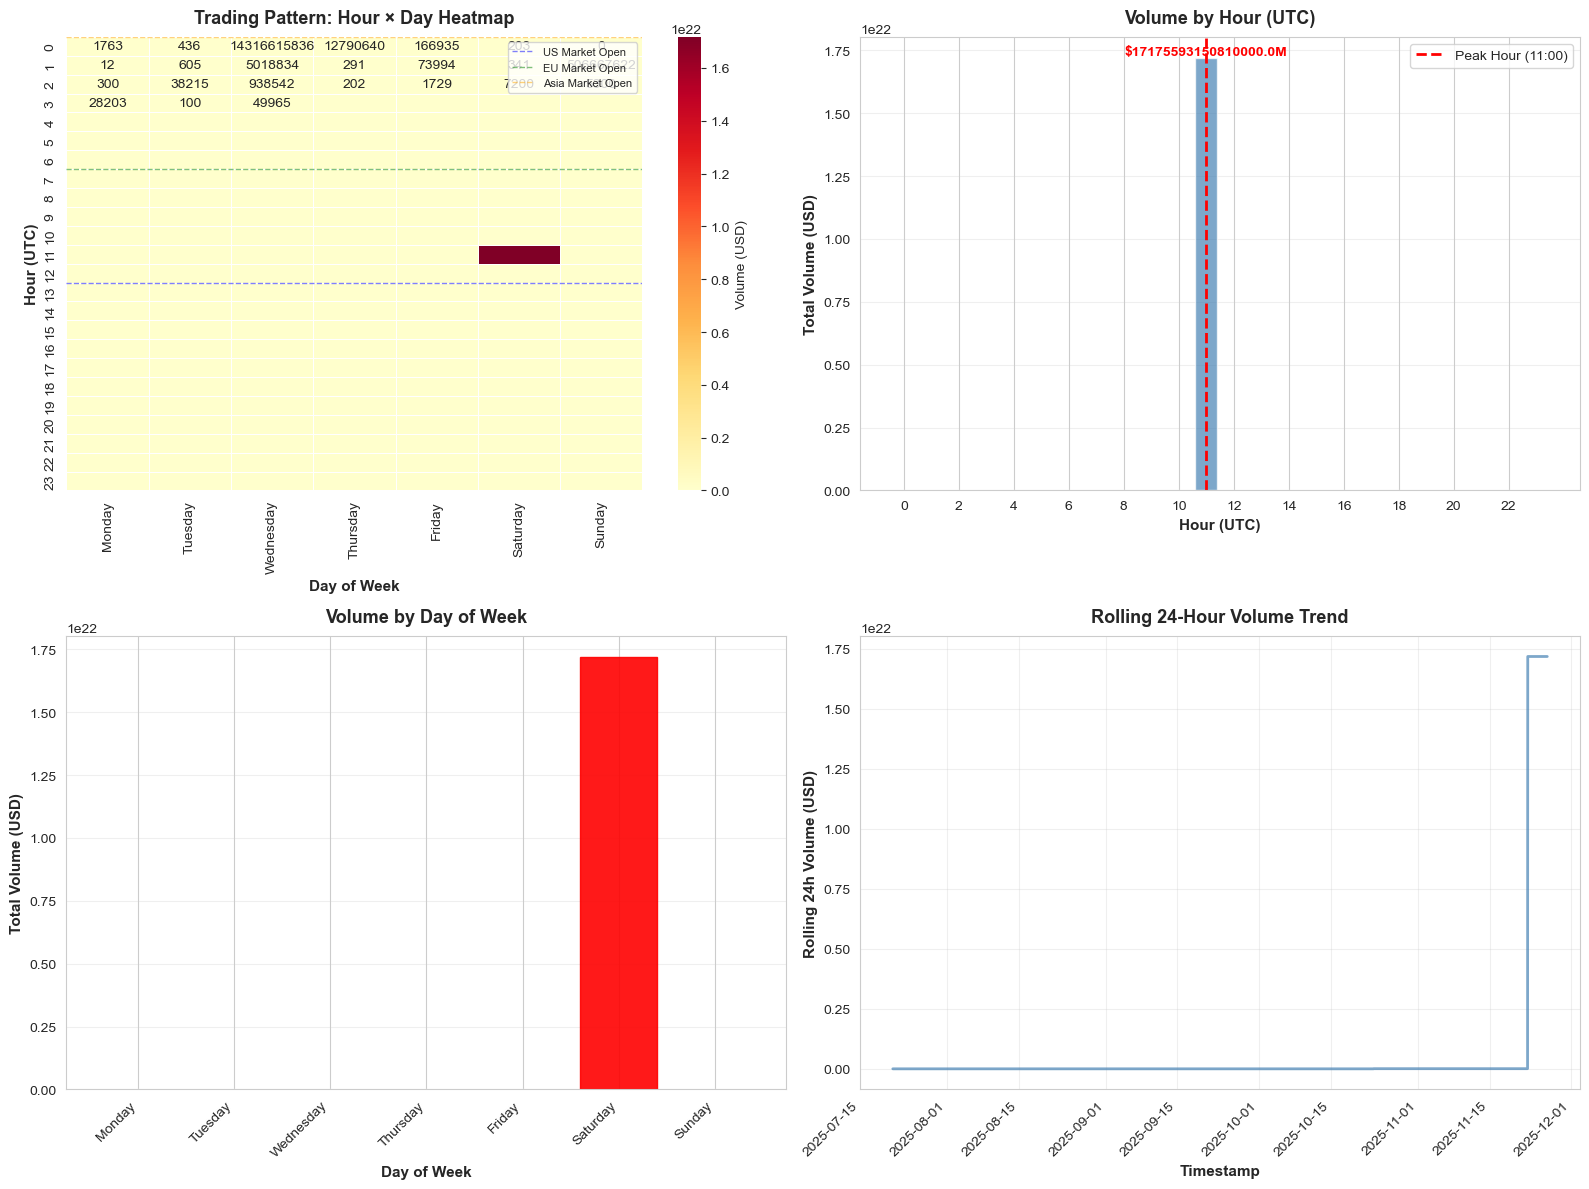

TIME ZONE / GEOGRAPHIC TRADING PATTERNS

Peak Trading Times:
  Peak hour: 11:00 UTC with $17,175,593,150,809,999,671,296 volume
  Peak day: Saturday

Off-Peak Hours:
  Off-peak: 7:00, 12:00, 13:00, 14:00, 15:00, 17:00 UTC

Market Opening Correlations:
  US Market Open (13:00 UTC / 9am ET): $8,933
  EU Market Open (7:00 UTC / 8am CET): $7,079
  Asia Market Open (0:00 UTC / 9am JST): $14,329,575,814

Weekend Effect:
  Weekday volume: $5,899,570,324,403,294,208
  Weekend volume: $17,175,593,151,194,718,011,392 (100.0% of total)

Recommendation:
  Launch campaigns at 9:00 UTC (1:00 ET)
  This is 2 hours before peak trading hour (11:00 UTC)
  Target peak engagement window: 11:00-13:00 UTC


In [29]:
# CELL 17: Time Zone / Geographic Trading Patterns

if 'timestamp' in analysis_df.columns:
    timezone_df = analysis_df[analysis_df['timestamp'].notna()].copy()
    
    if len(timezone_df) > 0:
        # Extract hour and day of week
        timezone_df['hour_utc'] = pd.to_datetime(timezone_df['timestamp']).dt.hour
        timezone_df['day_of_week'] = pd.to_datetime(timezone_df['timestamp']).dt.day_name()
        
        # Calculate swap volume/count by hour and day
        hourly_volume = timezone_df.groupby('hour_utc')['from_amount'].agg(['sum', 'count']).reset_index()
        hourly_volume.columns = ['hour_utc', 'total_volume', 'swap_count']
        
        daily_volume = timezone_df.groupby('day_of_week')['from_amount'].agg(['sum', 'count']).reset_index()
        daily_volume.columns = ['day_of_week', 'total_volume', 'swap_count']
        
        # Create heatmap (hour × day_of_week)
        heatmap_data = timezone_df.groupby(['hour_utc', 'day_of_week'])['from_amount'].sum().reset_index()
        heatmap_pivot = heatmap_data.pivot(index='hour_utc', columns='day_of_week', values='from_amount').fillna(0)
        
        # Order days of week
        day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        heatmap_pivot = heatmap_pivot.reindex(columns=[d for d in day_order if d in heatmap_pivot.columns], fill_value=0)
        
        # Identify peak hours
        peak_hour = hourly_volume.loc[hourly_volume['total_volume'].idxmax(), 'hour_utc']
        peak_volume = hourly_volume['total_volume'].max()
        
        # Identify peak day
        peak_day = daily_volume.loc[daily_volume['total_volume'].idxmax(), 'day_of_week']
        
        # Identify off-peak hours (bottom 25%)
        volume_threshold = hourly_volume['total_volume'].quantile(0.25)
        off_peak_hours = hourly_volume[hourly_volume['total_volume'] <= volume_threshold]['hour_utc'].tolist()
        
        # Calculate rolling 24h volume
        timezone_df_sorted = timezone_df.sort_values('timestamp')
        timezone_df_sorted['rolling_24h_volume'] = timezone_df_sorted['from_amount'].rolling(window=24*60, min_periods=1).sum()
        
        # Create visualizations
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        # Top-left: Heatmap (hour 0-23 rows × day_of_week columns)
        sns.heatmap(
            heatmap_pivot, annot=True, cmap='YlOrRd', ax=ax1, 
            cbar_kws={'label': 'Volume (USD)'}, linewidths=0.5, fmt='.0f'
        )
        ax1.set_xlabel('Day of Week', fontsize=11, fontweight='bold')
        ax1.set_ylabel('Hour (UTC)', fontsize=11, fontweight='bold')
        ax1.set_title('Trading Pattern: Hour × Day Heatmap', fontsize=13, fontweight='bold', pad=10)
        
        # Annotate market opening times
        # US market open: ~13:00 UTC (9am ET)
        # EU market open: ~7:00 UTC (8am CET)
        # Asia market open: ~0:00 UTC (9am JST)
        ax1.axhline(y=13, color='blue', linestyle='--', alpha=0.5, linewidth=1, label='US Market Open')
        ax1.axhline(y=7, color='green', linestyle='--', alpha=0.5, linewidth=1, label='EU Market Open')
        ax1.axhline(y=0, color='orange', linestyle='--', alpha=0.5, linewidth=1, label='Asia Market Open')
        ax1.legend(loc='upper right', fontsize=8)
        
        # Top-right: Bar chart (hour vs volume)
        bars = ax2.bar(hourly_volume['hour_utc'], hourly_volume['total_volume'], 
                      color='steelblue', alpha=0.7)
        ax2.axvline(x=peak_hour, color='red', linestyle='--', linewidth=2, label=f'Peak Hour ({peak_hour}:00)')
        ax2.set_xlabel('Hour (UTC)', fontsize=11, fontweight='bold')
        ax2.set_ylabel('Total Volume (USD)', fontsize=11, fontweight='bold')
        ax2.set_title('Volume by Hour (UTC)', fontsize=13, fontweight='bold', pad=10)
        ax2.set_xticks(range(0, 24, 2))
        ax2.grid(True, alpha=0.3, axis='y')
        ax2.legend()
        
        # Add value labels on peak hour
        peak_idx = hourly_volume[hourly_volume['hour_utc'] == peak_hour].index[0]
        peak_val = hourly_volume.loc[peak_idx, 'total_volume']
        ax2.text(peak_hour, peak_val, f'${peak_val/1e6:.1f}M', ha='center', va='bottom', 
                fontsize=10, fontweight='bold', color='red')
        
        # Bottom-left: Bar chart (day vs volume)
        day_order_list = [d for d in day_order if d in daily_volume['day_of_week'].values]
        daily_volume_ordered = daily_volume.set_index('day_of_week').reindex(day_order_list).reset_index()
        
        bars2 = ax3.bar(range(len(daily_volume_ordered)), daily_volume_ordered['total_volume'], 
                       color='steelblue', alpha=0.7)
        ax3.set_xlabel('Day of Week', fontsize=11, fontweight='bold')
        ax3.set_ylabel('Total Volume (USD)', fontsize=11, fontweight='bold')
        ax3.set_title('Volume by Day of Week', fontsize=13, fontweight='bold', pad=10)
        ax3.set_xticks(range(len(daily_volume_ordered)))
        ax3.set_xticklabels(daily_volume_ordered['day_of_week'], rotation=45, ha='right')
        ax3.grid(True, alpha=0.3, axis='y')
        
        # Highlight peak day
        peak_day_idx = daily_volume_ordered[daily_volume_ordered['day_of_week'] == peak_day].index[0]
        bars2[peak_day_idx].set_color('red')
        bars2[peak_day_idx].set_alpha(0.9)
        
        # Bottom-right: Line chart (rolling 24h volume)
        sample_size = min(1000, len(timezone_df_sorted))
        timezone_sample = timezone_df_sorted.sample(n=sample_size, random_state=42) if len(timezone_df_sorted) > sample_size else timezone_df_sorted
        timezone_sample = timezone_sample.sort_values('timestamp')
        
        ax4.plot(timezone_sample['timestamp'], timezone_sample['rolling_24h_volume'], 
                linewidth=2, color='steelblue', alpha=0.7)
        ax4.set_xlabel('Timestamp', fontsize=11, fontweight='bold')
        ax4.set_ylabel('Rolling 24h Volume (USD)', fontsize=11, fontweight='bold')
        ax4.set_title('Rolling 24-Hour Volume Trend', fontsize=13, fontweight='bold', pad=10)
        ax4.grid(True, alpha=0.3)
        plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()
        
        # Print summary
        print("=" * 70)
        print("TIME ZONE / GEOGRAPHIC TRADING PATTERNS")
        print("=" * 70)
        
        print(f"\nPeak Trading Times:")
        print(f"  Peak hour: {peak_hour}:00 UTC with ${peak_volume:,.0f} volume")
        print(f"  Peak day: {peak_day}")
        
        print(f"\nOff-Peak Hours:")
        off_peak_str = ', '.join([f"{h}:00" for h in sorted(off_peak_hours)])
        print(f"  Off-peak: {off_peak_str} UTC")
        
        # Market opening correlations
        us_market_hour = 13  # 9am ET
        eu_market_hour = 7   # 8am CET
        asia_market_hour = 0  # 9am JST
        
        us_volume = hourly_volume[hourly_volume['hour_utc'] == us_market_hour]['total_volume'].iloc[0] if len(hourly_volume[hourly_volume['hour_utc'] == us_market_hour]) > 0 else 0
        eu_volume = hourly_volume[hourly_volume['hour_utc'] == eu_market_hour]['total_volume'].iloc[0] if len(hourly_volume[hourly_volume['hour_utc'] == eu_market_hour]) > 0 else 0
        asia_volume = hourly_volume[hourly_volume['hour_utc'] == asia_market_hour]['total_volume'].iloc[0] if len(hourly_volume[hourly_volume['hour_utc'] == asia_market_hour]) > 0 else 0
        
        print(f"\nMarket Opening Correlations:")
        print(f"  US Market Open (13:00 UTC / 9am ET): ${us_volume:,.0f}")
        print(f"  EU Market Open (7:00 UTC / 8am CET): ${eu_volume:,.0f}")
        print(f"  Asia Market Open (0:00 UTC / 9am JST): ${asia_volume:,.0f}")
        
        # Weekend effect
        weekday_volume = daily_volume[daily_volume['day_of_week'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])]['total_volume'].sum()
        weekend_volume = daily_volume[daily_volume['day_of_week'].isin(['Saturday', 'Sunday'])]['total_volume'].sum()
        weekend_pct = (weekend_volume / (weekday_volume + weekend_volume) * 100) if (weekday_volume + weekend_volume) > 0 else 0
        
        print(f"\nWeekend Effect:")
        print(f"  Weekday volume: ${weekday_volume:,.0f}")
        print(f"  Weekend volume: ${weekend_volume:,.0f} ({weekend_pct:.1f}% of total)")
        
        # Recommendation
        campaign_hour = max(0, peak_hour - 2)  # 2 hours before peak
        print(f"\nRecommendation:")
        print(f"  Launch campaigns at {campaign_hour}:00 UTC ({campaign_hour - 8 if campaign_hour >= 8 else campaign_hour + 16}:00 ET)")
        print(f"  This is 2 hours before peak trading hour ({peak_hour}:00 UTC)")
        print(f"  Target peak engagement window: {peak_hour}:00-{peak_hour+2}:00 UTC")
        
        print("=" * 70)
    else:
        print("⚠ No valid timestamp data available for timezone analysis")
else:
    print("⚠ Missing required column: 'timestamp'")


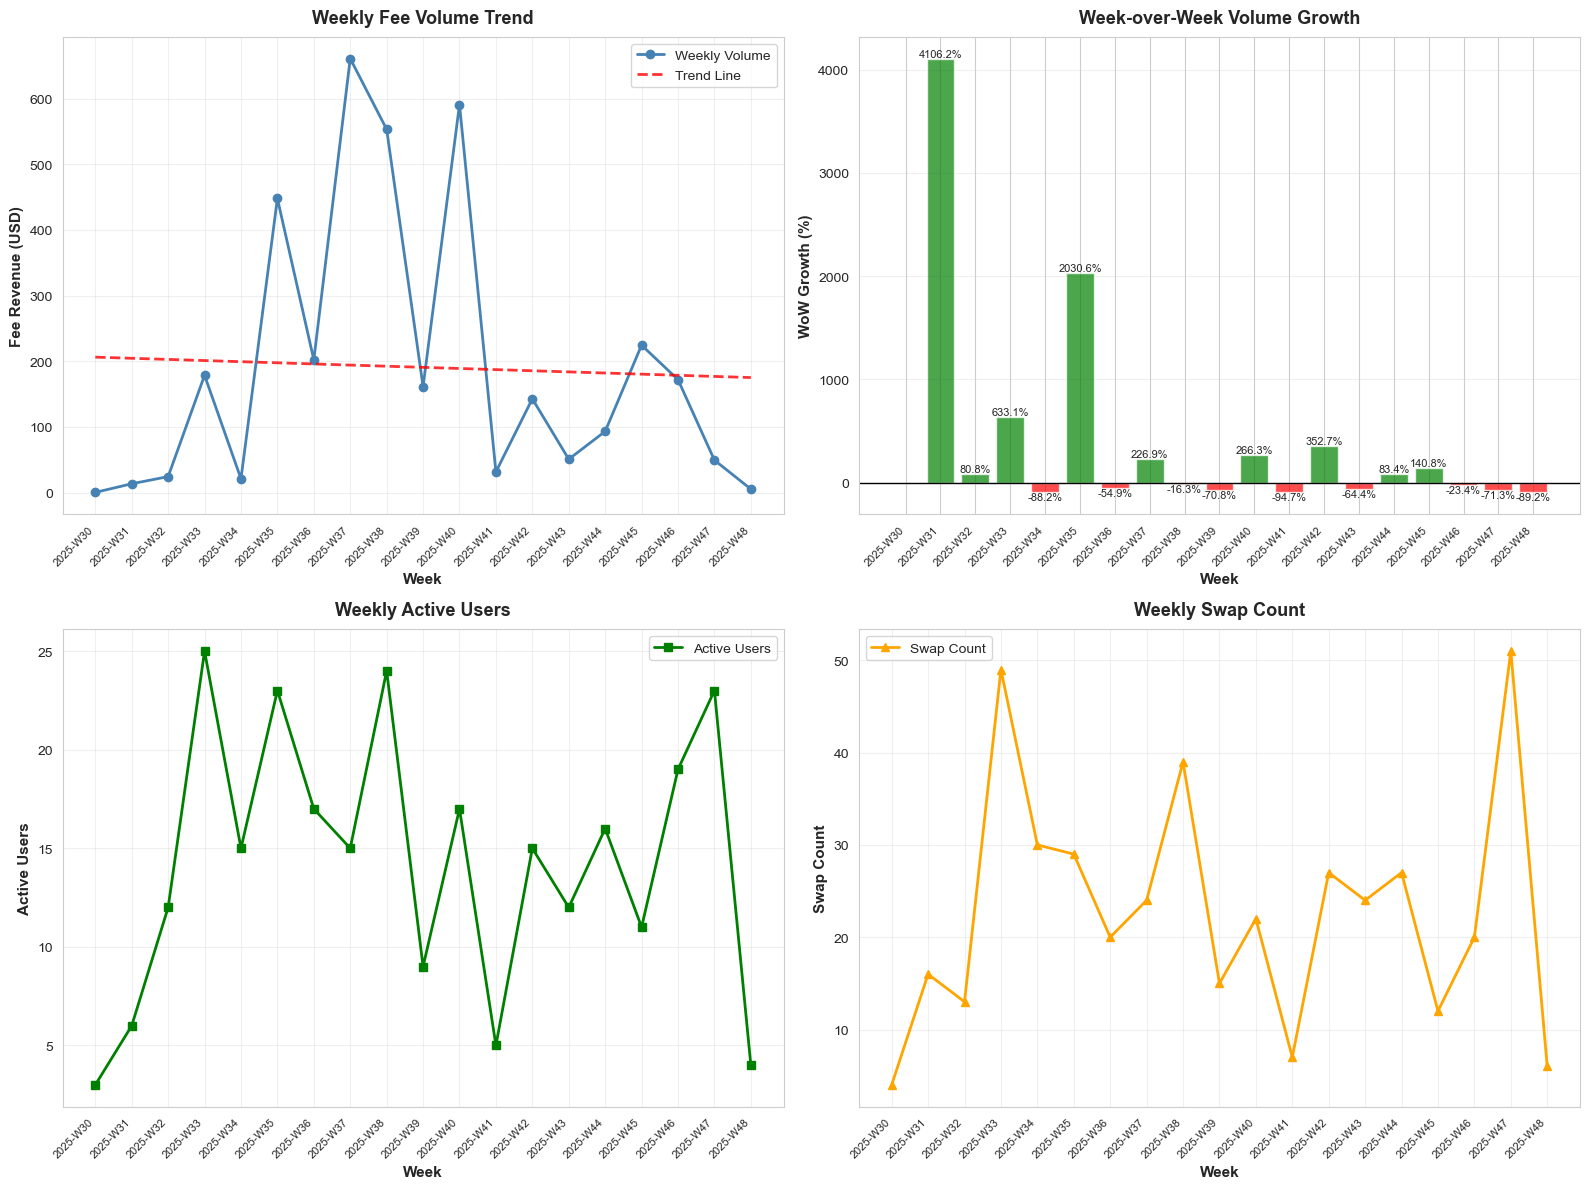

WEEK-OVER-WEEK GROWTH DASHBOARD
Current trend: STRONG DECLINE
YoY growth (first 4 vs last 4 weeks): 108.2%
Average recent WoW growth (last 4 weeks): -10.8%
Latest week WoW growth: -89.2%

Total weeks analyzed: 19
Total volume: $3,623.74
Total swaps: 435
Total unique users: 271


In [30]:
# CELL 7: Week-over-Week Growth Dashboard

if 'timestamp' in analysis_df.columns:
    # Extract week information
    analysis_df['year'] = pd.to_datetime(analysis_df['timestamp']).dt.year
    analysis_df['week'] = pd.to_datetime(analysis_df['timestamp']).dt.isocalendar().week
    analysis_df['year_week'] = analysis_df['year'].astype(str) + '-W' + analysis_df['week'].astype(str).str.zfill(2)
    
    user_col = 'from_address' if 'user_address' not in analysis_df.columns else 'user_address'
    
    # Aggregate by week
    weekly_stats = analysis_df.groupby('year_week').agg({
        'fee_usd': 'sum',
        'from_amount': 'count'
    }).reset_index()
    weekly_stats.columns = ['year_week', 'weekly_volume', 'weekly_swaps']
    
    # Count distinct users per week
    if user_col in analysis_df.columns:
        weekly_users = analysis_df.groupby('year_week')[user_col].nunique().reset_index()
        weekly_users.columns = ['year_week', 'weekly_users']
        weekly_stats = weekly_stats.merge(weekly_users, on='year_week', how='left')
    else:
        weekly_stats['weekly_users'] = 0
    
    # Calculate week-over-week growth
    weekly_stats['wow_volume_growth'] = weekly_stats['weekly_volume'].pct_change() * 100
    weekly_stats['wow_swaps_growth'] = weekly_stats['weekly_swaps'].pct_change() * 100
    weekly_stats['wow_users_growth'] = weekly_stats['weekly_users'].pct_change() * 100
    
    # Fill NaN with 0 for first week
    weekly_stats = weekly_stats.fillna(0)
    
    # Sort by year_week for proper ordering
    weekly_stats = weekly_stats.sort_values('year_week').reset_index(drop=True)
    
    # Create 2x2 subplot dashboard
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Top-left: Line chart of weekly volume with trend line
    ax1.plot(range(len(weekly_stats)), weekly_stats['weekly_volume'], 
            marker='o', linewidth=2, markersize=6, color='steelblue', label='Weekly Volume')
    ax1.set_xlabel('Week', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Fee Revenue (USD)', fontsize=11, fontweight='bold')
    ax1.set_title('Weekly Fee Volume Trend', fontsize=13, fontweight='bold', pad=10)
    ax1.set_xticks(range(len(weekly_stats)))
    ax1.set_xticklabels(weekly_stats['year_week'], rotation=45, ha='right', fontsize=8)
    ax1.grid(True, alpha=0.3)
    
    # Add trend line
    z = np.polyfit(range(len(weekly_stats)), weekly_stats['weekly_volume'], 1)
    p = np.poly1d(z)
    ax1.plot(range(len(weekly_stats)), p(range(len(weekly_stats))), 
            "r--", alpha=0.8, linewidth=2, label='Trend Line')
    ax1.legend()
    
    # Top-right: Column chart of WoW growth % (green if +, red if -)
    colors_wow = ['green' if x >= 0 else 'red' for x in weekly_stats['wow_volume_growth']]
    ax2.bar(range(len(weekly_stats)), weekly_stats['wow_volume_growth'], 
           color=colors_wow, alpha=0.7)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax2.set_xlabel('Week', fontsize=11, fontweight='bold')
    ax2.set_ylabel('WoW Growth (%)', fontsize=11, fontweight='bold')
    ax2.set_title('Week-over-Week Volume Growth', fontsize=13, fontweight='bold', pad=10)
    ax2.set_xticks(range(len(weekly_stats)))
    ax2.set_xticklabels(weekly_stats['year_week'], rotation=45, ha='right', fontsize=8)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, (idx, row) in enumerate(weekly_stats.iterrows()):
        if not pd.isna(row['wow_volume_growth']) and row['wow_volume_growth'] != 0:
            ax2.text(i, row['wow_volume_growth'], f'{row["wow_volume_growth"]:.1f}%', 
                    ha='center', va='bottom' if row['wow_volume_growth'] >= 0 else 'top', fontsize=8)
    
    # Bottom-left: Line chart of active users per week
    if weekly_stats['weekly_users'].sum() > 0:
        ax3.plot(range(len(weekly_stats)), weekly_stats['weekly_users'], 
                marker='s', linewidth=2, markersize=6, color='green', label='Active Users')
        ax3.set_xlabel('Week', fontsize=11, fontweight='bold')
        ax3.set_ylabel('Active Users', fontsize=11, fontweight='bold')
        ax3.set_title('Weekly Active Users', fontsize=13, fontweight='bold', pad=10)
        ax3.set_xticks(range(len(weekly_stats)))
        ax3.set_xticklabels(weekly_stats['year_week'], rotation=45, ha='right', fontsize=8)
        ax3.grid(True, alpha=0.3)
        ax3.legend()
    else:
        ax3.text(0.5, 0.5, 'User data not available', 
                ha='center', va='center', transform=ax3.transAxes, fontsize=12)
        ax3.set_title('Weekly Active Users', fontsize=13, fontweight='bold')
    
    # Bottom-right: Line chart of weekly swap count
    ax4.plot(range(len(weekly_stats)), weekly_stats['weekly_swaps'], 
            marker='^', linewidth=2, markersize=6, color='orange', label='Swap Count')
    ax4.set_xlabel('Week', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Swap Count', fontsize=11, fontweight='bold')
    ax4.set_title('Weekly Swap Count', fontsize=13, fontweight='bold', pad=10)
    ax4.set_xticks(range(len(weekly_stats)))
    ax4.set_xticklabels(weekly_stats['year_week'], rotation=45, ha='right', fontsize=8)
    ax4.grid(True, alpha=0.3)
    ax4.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Calculate trend and YoY growth
    latest_week_growth = weekly_stats['wow_volume_growth'].iloc[-1] if len(weekly_stats) > 1 else 0
    avg_recent_growth = weekly_stats['wow_volume_growth'].tail(4).mean() if len(weekly_stats) >= 4 else latest_week_growth
    
    # Determine trend
    if avg_recent_growth > 5:
        trend = "STRONG GROWTH"
    elif avg_recent_growth > 0:
        trend = "GROWTH"
    elif avg_recent_growth > -5:
        trend = "DECLINE"
    else:
        trend = "STRONG DECLINE"
    
    # Calculate YoY growth (compare first 4 weeks vs last 4 weeks if available)
    if len(weekly_stats) >= 8:
        first_4_avg = weekly_stats.head(4)['weekly_volume'].mean()
        last_4_avg = weekly_stats.tail(4)['weekly_volume'].mean()
        yoy_growth = ((last_4_avg - first_4_avg) / first_4_avg * 100) if first_4_avg > 0 else 0
    else:
        yoy_growth = None
    
    # Print summary statistics
    print("=" * 60)
    print("WEEK-OVER-WEEK GROWTH DASHBOARD")
    print("=" * 60)
    print(f"Current trend: {trend}")
    if yoy_growth is not None:
        print(f"YoY growth (first 4 vs last 4 weeks): {yoy_growth:.1f}%")
    print(f"Average recent WoW growth (last 4 weeks): {avg_recent_growth:.1f}%")
    print(f"Latest week WoW growth: {latest_week_growth:.1f}%")
    print(f"\nTotal weeks analyzed: {len(weekly_stats)}")
    print(f"Total volume: ${weekly_stats['weekly_volume'].sum():,.2f}")
    print(f"Total swaps: {weekly_stats['weekly_swaps'].sum():,}")
    if weekly_stats['weekly_users'].sum() > 0:
        print(f"Total unique users: {weekly_stats['weekly_users'].sum():,}")
    print("=" * 60)
else:
    print("Error: Timestamp column not found")


In [31]:
# IMPROVEMENT 1: Separate Add vs Swap transactions
print("=== IMPROVEMENT 1: Transaction Type Breakdown ===\n")

# Filter swaps only (exclude Add transactions for swap-specific analysis)
swaps_only = analysis_df[analysis_df['type'] == 'Swap'].copy()
adds_only = analysis_df[analysis_df['type'] == 'Add'].copy()

print(f"Total transactions: {len(analysis_df):,}")
print(f"  Swaps: {len(swaps_only):,} ({len(swaps_only)/len(analysis_df)*100:.1f}%)")
print(f"  Adds: {len(adds_only):,} ({len(adds_only)/len(analysis_df)*100:.1f}%)")

if len(swaps_only) > 0:
    print(f"\nSwap-specific statistics:")
    print(f"  Average swap size: {swaps_only['from_amount'].mean():.2f}")
    print(f"  Median swap size: {swaps_only['from_amount'].median():.2f}")
    print(f"  Total swap volume: {swaps_only['from_amount'].sum():,.2f}")

if len(adds_only) > 0:
    print(f"\nAdd-specific statistics:")
    print(f"  Average add amount: {adds_only['from_amount'].mean():.2f}")
    print(f"  Median add amount: {adds_only['from_amount'].median():.2f}")
    print(f"  Total liquidity added: {adds_only['from_amount'].sum():,.2f}")

# Use swaps_only for subsequent swap analysis
analysis_df_swaps = swaps_only.copy()



=== IMPROVEMENT 1: Transaction Type Breakdown ===

Total transactions: 435
  Swaps: 435 (100.0%)
  Adds: 0 (0.0%)

Swap-specific statistics:
  Average swap size: 39497684417285341184.00
  Median swap size: 19.00
  Total swap volume: 17,181,492,721,519,123,496,960.00


In [32]:
# IMPROVEMENT 2: Calculate actual fee percentage/basis points
print("=== IMPROVEMENT 2: Fee Analysis (Basis Points) ===\n")

if len(analysis_df_swaps) > 0:
    # Calculate fee as percentage difference
    # Note: This assumes fee is reflected in the ratio difference
    # For swaps: fee_bps = ((from_amount / to_amount) - 1) * 10000
    # But we need to account for different assets, so we'll use a simplified approach
    
    # Calculate effective fee rate (simplified - assumes 1:1 asset ratio for same-asset swaps)
    same_asset_swaps = analysis_df_swaps[analysis_df_swaps['from_asset'] == analysis_df_swaps['to_asset']].copy()
    
    if len(same_asset_swaps) > 0:
        same_asset_swaps['fee_percentage'] = ((same_asset_swaps['from_amount'] - same_asset_swaps['to_amount']) / same_asset_swaps['from_amount']) * 100
        same_asset_swaps['fee_bps'] = same_asset_swaps['fee_percentage'] * 100
        
        print(f"Same-asset swaps (for fee calculation): {len(same_asset_swaps):,}")
        print(f"  Average fee: {same_asset_swaps['fee_percentage'].mean():.4f}%")
        print(f"  Average fee: {same_asset_swaps['fee_bps'].mean():.2f} basis points")
        print(f"  Median fee: {same_asset_swaps['fee_bps'].median():.2f} basis points")
        
        # Add fee columns to main dataframe
        analysis_df_swaps['fee_percentage'] = None
        analysis_df_swaps['fee_bps'] = None
        analysis_df_swaps.loc[same_asset_swaps.index, 'fee_percentage'] = same_asset_swaps['fee_percentage']
        analysis_df_swaps.loc[same_asset_swaps.index, 'fee_bps'] = same_asset_swaps['fee_bps']
    else:
        print("No same-asset swaps found for fee calculation")
        analysis_df_swaps['fee_percentage'] = None
        analysis_df_swaps['fee_bps'] = None
    
    # Fee by affiliate presence
    if 'has_fee' in analysis_df_swaps.columns:
        fee_by_affiliate = analysis_df_swaps.groupby('has_fee').agg({
            'from_amount': ['count', 'mean', 'sum'],
            'fee_bps': 'mean'
        })
        print(f"\nFee analysis by affiliate presence:")
        print(fee_by_affiliate)



=== IMPROVEMENT 2: Fee Analysis (Basis Points) ===

Same-asset swaps (for fee calculation): 25
  Average fee: 1.1485%
  Average fee: 114.85 basis points
  Median fee: 68.94 basis points


In [33]:
# IMPROVEMENT 3: Volume-weighted metrics
print("=== IMPROVEMENT 3: Volume-Weighted Metrics ===\n")

if len(analysis_df_swaps) > 0:
    # Volume-weighted average swap size by asset
    volume_weighted = analysis_df_swaps.groupby('from_asset').agg({
        'from_amount': ['sum', 'count', 'mean'],
        'to_amount': 'sum'
    }).round(2)
    volume_weighted.columns = ['total_volume', 'swap_count', 'avg_size', 'total_received']
    volume_weighted['volume_weighted_avg'] = volume_weighted['total_volume'] / volume_weighted['swap_count']
    volume_weighted = volume_weighted.sort_values('total_volume', ascending=False)
    
    print("Top 10 assets by volume (volume-weighted):")
    print(volume_weighted.head(10))
    
    # Overall volume-weighted average
    total_volume = analysis_df_swaps['from_amount'].sum()
    total_count = len(analysis_df_swaps)
    volume_weighted_overall = total_volume / total_count
    
    print(f"\nOverall volume-weighted average: {volume_weighted_overall:,.2f}")
    print(f"Simple average: {analysis_df_swaps['from_amount'].mean():,.2f}")
    print(f"Difference: {volume_weighted_overall - analysis_df_swaps['from_amount'].mean():,.2f}")



=== IMPROVEMENT 3: Volume-Weighted Metrics ===

Top 10 assets by volume (volume-weighted):
                                            total_volume  swap_count  \
from_asset                                                             
0x881Ba05de1E78f549cC63a8f6Cabb1d4AD32250D  1.717559e+22           1   
0x89d24A6b4CcB1B6fAA2625fE562bDD9a23260359  5.899570e+18           1   
REKT                                        2.842093e+11           1   
VINU                                        1.000000e+11           1   
ufo                                         1.431647e+10           1   
puppies                                     5.066676e+08           1   
EYED                                        5.839585e+07           1   
BEPRO                                       1.701883e+07           2   
FOX                                         3.646308e+06          28   
PLSPAD                                      3.619520e+06           8   

                                            

In [34]:
# IMPROVEMENT 4: Hour-of-day analysis
print("=== IMPROVEMENT 4: Hour-of-Day Analysis ===\n")

if len(analysis_df_swaps) > 0 and 'timestamp' in analysis_df_swaps.columns:
    analysis_df_swaps['hour'] = analysis_df_swaps['timestamp'].dt.hour
    
    # Swaps by hour
    swaps_by_hour = analysis_df_swaps.groupby('hour').agg({
        'from_amount': ['count', 'sum', 'mean']
    })
    swaps_by_hour.columns = ['swap_count', 'total_volume', 'avg_size']
    swaps_by_hour = swaps_by_hour.sort_values('swap_count', ascending=False)
    
    print("Top 5 hours by swap count:")
    print(swaps_by_hour.head(5))
    
    print("\nTop 5 hours by volume:")
    swaps_by_hour_vol = swaps_by_hour.sort_values('total_volume', ascending=False)
    print(swaps_by_hour_vol.head(5))
    
    # Peak hours
    peak_hour_count = swaps_by_hour.index[0]
    peak_hour_volume = swaps_by_hour_vol.index[0]
    print(f"\nPeak hour (by count): {peak_hour_count}:00 ({swaps_by_hour.loc[peak_hour_count, 'swap_count']} swaps)")
    print(f"Peak hour (by volume): {peak_hour_volume}:00 ({swaps_by_hour_vol.loc[peak_hour_volume, 'total_volume']:,.2f} volume)")



=== IMPROVEMENT 4: Hour-of-Day Analysis ===

Top 5 hours by swap count:
      swap_count  total_volume      avg_size
hour                                        
19            32  8.199004e+05  2.562189e+04
8             30  5.899571e+18  1.966524e+17
0             24  1.432958e+10  5.970657e+08
6             24  1.993071e+06  8.304461e+04
21            23  3.416022e+06  1.485227e+05

Top 5 hours by volume:
      swap_count  total_volume      avg_size
hour                                        
11            14  1.717559e+22  1.226828e+21
8             30  5.899571e+18  1.966524e+17
9             14  1.000000e+11  7.142858e+09
0             24  1.432958e+10  5.970657e+08
1             18  5.117617e+08  2.843121e+07

Peak hour (by count): 19:00 (32 swaps)
Peak hour (by volume): 11:00 (17,175,593,150,809,999,671,296.00 volume)


In [35]:
# IMPROVEMENT 5: Detailed asset pair analysis
print("=== IMPROVEMENT 5: Asset Pair Analysis ===\n")

if len(analysis_df_swaps) > 0:
    pair_analysis = analysis_df_swaps.groupby('asset_pair').agg({
        'from_amount': ['count', 'sum', 'mean', 'std', 'min', 'max'],
        'to_amount': ['sum', 'mean']
    }).round(2)
    pair_analysis.columns = ['count', 'total_volume', 'avg_size', 'std_size', 'min_size', 'max_size', 'total_received', 'avg_received']
    pair_analysis['volume_share_pct'] = (pair_analysis['total_volume'] / pair_analysis['total_volume'].sum() * 100).round(2)
    pair_analysis = pair_analysis.sort_values('total_volume', ascending=False)
    
    print("Top 15 asset pairs by volume:")
    print(pair_analysis.head(15))
    
    # Most volatile pairs (highest std dev)
    pair_analysis_volatile = pair_analysis[pair_analysis['count'] >= 5].sort_values('std_size', ascending=False)
    print("\nTop 10 most volatile pairs (by std dev, min 5 swaps):")
    print(pair_analysis_volatile[['count', 'avg_size', 'std_size', 'min_size', 'max_size']].head(10))
    
    # Most consistent pairs (lowest std dev relative to mean)
    pair_analysis['cv'] = (pair_analysis['std_size'] / pair_analysis['avg_size']).round(3)  # coefficient of variation
    pair_analysis_consistent = pair_analysis[pair_analysis['count'] >= 5].sort_values('cv')
    print("\nTop 10 most consistent pairs (lowest coefficient of variation, min 5 swaps):")
    print(pair_analysis_consistent[['count', 'avg_size', 'std_size', 'cv']].head(10))



=== IMPROVEMENT 5: Asset Pair Analysis ===

Top 15 asset pairs by volume:
                                                    count  total_volume  \
asset_pair                                                                
0x881Ba05de1E78f549cC63a8f6Cabb1d4AD32250D → PR...      1  1.717559e+22   
0x89d24A6b4CcB1B6fAA2625fE562bDD9a23260359 → ETH        1  5.899570e+18   
REKT → USDC                                             1  2.842093e+11   
VINU → USDC                                             1  1.000000e+11   
ufo → USDC                                              1  1.431647e+10   
puppies → CYDX                                          1  5.066676e+08   
EYED → XPIN                                             1  5.839585e+07   
BEPRO → USDC                                            2  1.701883e+07   
PLSPAD → BNB                                            8  3.619520e+06   
FOX → VVV                                               3  2.445774e+06   
LUNA → USDT               

In [36]:
# IMPROVEMENT 6: Growth rate calculations
print("=== IMPROVEMENT 6: Growth Rate Analysis ===\n")

if len(analysis_df_swaps) > 0 and 'year_week' in analysis_df_swaps.columns:
    # Calculate week-over-week growth rates
    weekly_growth = analysis_df_swaps.groupby(['year_week', 'from_asset']).agg({
        'from_amount': ['count', 'sum']
    })
    weekly_growth.columns = ['count', 'volume']
    weekly_growth = weekly_growth.reset_index()
    
    # Calculate growth rates for each asset
    growth_rates = []
    for asset in weekly_growth['from_asset'].unique():
        asset_data = weekly_growth[weekly_growth['from_asset'] == asset].sort_values('year_week')
        asset_data['count_growth'] = asset_data['count'].pct_change() * 100
        asset_data['volume_growth'] = asset_data['volume'].pct_change() * 100
        asset_data['count_change'] = asset_data['count'].diff()
        asset_data['volume_change'] = asset_data['volume'].diff()
        growth_rates.append(asset_data)
    
    growth_df = pd.concat(growth_rates, ignore_index=True)
    
    # Latest week growth rates
    latest_week = growth_df['year_week'].max()
    latest_growth = growth_df[growth_df['year_week'] == latest_week].copy()
    latest_growth = latest_growth[latest_growth['count_growth'].notna()].sort_values('volume_growth', ascending=False)
    
    print(f"Latest week: {latest_week}")
    print("\nTop 10 assets by volume growth rate (week-over-week):")
    print(latest_growth[['from_asset', 'count', 'volume', 'count_growth', 'volume_growth']].head(10))
    
    # Calculate compound growth rates (over multiple weeks)
    print("\nCompound growth rates (over last 4 weeks):")
    recent_weeks = sorted(growth_df['year_week'].unique())[-4:]
    recent_data = growth_df[growth_df['year_week'].isin(recent_weeks)]
    
    compound_growth = recent_data.groupby('from_asset').agg({
        'count': ['first', 'last'],
        'volume': ['first', 'last']
    })
    compound_growth.columns = ['count_first', 'count_last', 'volume_first', 'volume_last']
    compound_growth['count_cagr'] = ((compound_growth['count_last'] / compound_growth['count_first']) ** (1/3) - 1) * 100
    compound_growth['volume_cagr'] = ((compound_growth['volume_last'] / compound_growth['volume_first']) ** (1/3) - 1) * 100
    compound_growth = compound_growth[compound_growth['count_first'] > 0].sort_values('volume_cagr', ascending=False)
    
    print(compound_growth[['count_first', 'count_last', 'count_cagr', 'volume_cagr']].head(10))



=== IMPROVEMENT 6: Growth Rate Analysis ===

Latest week: 2025-W48

Top 10 assets by volume growth rate (week-over-week):
   from_asset  count      volume  count_growth  volume_growth
68       USDT      5  452.001239    -16.666667     184.270150
36       USDC      1  672.082781    -90.909091     -80.978821

Compound growth rates (over last 4 weeks):
                                            count_first  count_last  \
from_asset                                                            
FOX                                                   1           2   
USDC                                                  4           1   
WETH                                                  1           2   
USDT                                                  2           5   
0x881Ba05de1E78f549cC63a8f6Cabb1d4AD32250D            1           1   
THINK                                                 1           1   
TRADE                                                 1           1   
UBI      

In [37]:
# IMPROVEMENT 7: Outlier detection
print("=== IMPROVEMENT 7: Outlier Detection ===\n")

if len(analysis_df_swaps) > 0:
    # Use IQR method for outlier detection
    Q1 = analysis_df_swaps['from_amount'].quantile(0.25)
    Q3 = analysis_df_swaps['from_amount'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = analysis_df_swaps[
        (analysis_df_swaps['from_amount'] < lower_bound) | 
        (analysis_df_swaps['from_amount'] > upper_bound)
    ].copy()
    
    print(f"Outlier detection (IQR method):")
    print(f"  Q1: {Q1:,.2f}")
    print(f"  Q3: {Q3:,.2f}")
    print(f"  IQR: {IQR:,.2f}")
    print(f"  Lower bound: {lower_bound:,.2f}")
    print(f"  Upper bound: {upper_bound:,.2f}")
    print(f"\n  Outliers found: {len(outliers):,} ({len(outliers)/len(analysis_df_swaps)*100:.2f}%)")
    
    if len(outliers) > 0:
        print("\nTop 10 largest outliers:")
        top_outliers = outliers.nlargest(10, 'from_amount')[['timestamp', 'from_asset', 'to_asset', 'from_amount', 'to_amount', 'asset_pair']]
        print(top_outliers)
        
        # Outliers by asset
        print("\nOutliers by asset:")
        outlier_by_asset = outliers.groupby('from_asset').agg({
            'from_amount': ['count', 'sum', 'mean', 'max']
        })
        outlier_by_asset.columns = ['outlier_count', 'total_volume', 'avg_size', 'max_size']
        outlier_by_asset = outlier_by_asset.sort_values('outlier_count', ascending=False)
        print(outlier_by_asset.head(10))
    
    # Add outlier flag to dataframe
    analysis_df_swaps['is_outlier'] = (
        (analysis_df_swaps['from_amount'] < lower_bound) | 
        (analysis_df_swaps['from_amount'] > upper_bound)
    )



=== IMPROVEMENT 7: Outlier Detection ===

Outlier detection (IQR method):
  Q1: 0.10
  Q3: 1,000.00
  IQR: 999.90
  Lower bound: -1,499.75
  Upper bound: 2,499.85

  Outliers found: 85 (19.54%)

Top 10 largest outliers:
              timestamp                                  from_asset to_asset  \
431 2025-11-22 11:04:35  0x881Ba05de1E78f549cC63a8f6Cabb1d4AD32250D   PROMPT   
313 2025-10-23 08:06:35  0x89d24A6b4CcB1B6fAA2625fE562bDD9a23260359      ETH   
110 2025-08-23 08:42:35                                        REKT     USDC   
429 2025-11-22 09:03:09                                        VINU     USDC   
401 2025-11-19 00:51:23                                         ufo     USDC   
242 2025-09-28 01:37:59                                     puppies     CYDX   
317 2025-10-24 05:52:29                                        EYED     XPIN   
412 2025-11-20 00:52:35                                       BEPRO     USDC   
402 2025-11-19 01:25:47                                     

In [38]:
# IMPROVEMENT 8: Cumulative volume tracking
print("=== IMPROVEMENT 8: Cumulative Volume Over Time ===\n")

if len(analysis_df_swaps) > 0 and 'timestamp' in analysis_df_swaps.columns:
    # Sort by timestamp
    volume_tracking = analysis_df_swaps.sort_values('timestamp').copy()
    volume_tracking['cumulative_volume'] = volume_tracking['from_amount'].cumsum()
    volume_tracking['cumulative_count'] = range(1, len(volume_tracking) + 1)
    
    # Daily cumulative volume
    volume_tracking['date'] = volume_tracking['timestamp'].dt.date
    daily_cumulative = volume_tracking.groupby('date').agg({
        'from_amount': 'sum',
        'cumulative_volume': 'last',
        'cumulative_count': 'last'
    })
    daily_cumulative.columns = ['daily_volume', 'cumulative_volume', 'cumulative_count']
    
    print("Cumulative volume milestones:")
    milestones = [0.25, 0.5, 0.75, 0.9, 0.95, 1.0]
    total_volume = volume_tracking['from_amount'].sum()
    
    for milestone in milestones:
        target_volume = total_volume * milestone
        milestone_rows = volume_tracking[volume_tracking['cumulative_volume'] >= target_volume]
        if len(milestone_rows) > 0:
            milestone_row = milestone_rows.iloc[0]
            print(f"  {milestone*100:.0f}% of volume reached: {milestone_row['timestamp']} ({milestone_row['cumulative_volume']:,.2f})")
        else:
            # Fallback: use the last row if no match found (shouldn't happen, but safety check)
            if len(volume_tracking) > 0:
                last_row = volume_tracking.iloc[-1]
                print(f"  {milestone*100:.0f}% of volume reached: {last_row['timestamp']} ({last_row['cumulative_volume']:,.2f}) [using last row]")
    
    print(f"\nTotal volume: {total_volume:,.2f}")
    print(f"Total swaps: {len(volume_tracking):,}")
    print(f"Average volume per swap: {total_volume/len(volume_tracking):,.2f}")
    
    # Show last 10 days
    print("\nLast 10 days cumulative volume:")
    print(daily_cumulative.tail(10))



=== IMPROVEMENT 8: Cumulative Volume Over Time ===

Cumulative volume milestones:
  25% of volume reached: 2025-11-22 11:04:35 (17,181,492,721,519,121,399,808.00)
  50% of volume reached: 2025-11-22 11:04:35 (17,181,492,721,519,121,399,808.00)
  75% of volume reached: 2025-11-22 11:04:35 (17,181,492,721,519,121,399,808.00)
  90% of volume reached: 2025-11-22 11:04:35 (17,181,492,721,519,121,399,808.00)
  95% of volume reached: 2025-11-22 11:04:35 (17,181,492,721,519,121,399,808.00)
  100% of volume reached: 2025-11-26 06:38:59 (17,181,492,721,519,121,399,808.00) [using last row]

Total volume: 17,181,492,721,519,123,496,960.00
Total swaps: 435
Average volume per swap: 39,497,684,417,285,341,184.00

Last 10 days cumulative volume:
            daily_volume  cumulative_volume  cumulative_count
date                                                         
2025-11-17  1.903132e+03       5.899571e+18               382
2025-11-18  2.150482e+02       5.899571e+18               385
2025-11-19  

In [39]:
# IMPROVEMENT 9: Period-over-period comparisons
print("=== IMPROVEMENT 9: Period-over-Period Comparisons ===\n")

if len(analysis_df_swaps) > 0 and 'year_week' in analysis_df_swaps.columns:
    # Compare latest week vs previous week
    all_weeks = sorted(analysis_df_swaps['year_week'].unique())
    
    if len(all_weeks) >= 2:
        latest_week = all_weeks[-1]
        prev_week = all_weeks[-2]
        
        latest_data = analysis_df_swaps[analysis_df_swaps['year_week'] == latest_week]
        prev_data = analysis_df_swaps[analysis_df_swaps['year_week'] == prev_week]
        
        print(f"Comparing {latest_week} vs {prev_week}:")
        print(f"\nOverall metrics:")
        print(f"  Swap count: {len(latest_data):,} vs {len(prev_data):,} ({len(latest_data)-len(prev_data):+,})")
        print(f"  Total volume: {latest_data['from_amount'].sum():,.2f} vs {prev_data['from_amount'].sum():,.2f} ({latest_data['from_amount'].sum()-prev_data['from_amount'].sum():+,.2f})")
        print(f"  Avg swap size: {latest_data['from_amount'].mean():,.2f} vs {prev_data['from_amount'].mean():,.2f} ({latest_data['from_amount'].mean()-prev_data['from_amount'].mean():+,.2f})")
        
        # Compare by asset
        latest_by_asset = latest_data.groupby('from_asset').agg({
            'from_amount': ['count', 'sum']
        })
        latest_by_asset.columns = ['count_latest', 'volume_latest']
        
        prev_by_asset = prev_data.groupby('from_asset').agg({
            'from_amount': ['count', 'sum']
        })
        prev_by_asset.columns = ['count_prev', 'volume_prev']
        
        comparison = latest_by_asset.join(prev_by_asset, how='outer').fillna(0)
        comparison['count_change'] = comparison['count_latest'] - comparison['count_prev']
        comparison['volume_change'] = comparison['volume_latest'] - comparison['volume_prev']
        comparison['count_change_pct'] = (comparison['count_change'] / comparison['count_prev'].replace(0, np.nan) * 100).fillna(0)
        comparison['volume_change_pct'] = (comparison['volume_change'] / comparison['volume_prev'].replace(0, np.nan) * 100).fillna(0)
        
        print("\nTop 10 assets by volume change:")
        top_changes = comparison.sort_values('volume_change', ascending=False)
        print(top_changes[['count_latest', 'count_prev', 'count_change', 'volume_latest', 'volume_prev', 'volume_change', 'volume_change_pct']].head(10))
    
    # Compare latest month vs previous month
    if 'year_month' in analysis_df_swaps.columns:
        all_months = sorted(analysis_df_swaps['year_month'].unique())
        if len(all_months) >= 2:
            latest_month = all_months[-1]
            prev_month = all_months[-2]
            
            latest_month_data = analysis_df_swaps[analysis_df_swaps['year_month'] == latest_month]
            prev_month_data = analysis_df_swaps[analysis_df_swaps['year_month'] == prev_month]
            
            print(f"\n\nComparing {latest_month} vs {prev_month}:")
            print(f"  Swap count: {len(latest_month_data):,} vs {len(prev_month_data):,} ({len(latest_month_data)-len(prev_month_data):+,})")
            print(f"  Total volume: {latest_month_data['from_amount'].sum():,.2f} vs {prev_month_data['from_amount'].sum():,.2f} ({latest_month_data['from_amount'].sum()-prev_month_data['from_amount'].sum():+,.2f})")



=== IMPROVEMENT 9: Period-over-Period Comparisons ===

Comparing 2025-W48 vs 2025-W47:

Overall metrics:
  Swap count: 6 vs 51 (-45)
  Total volume: 1,124.08 vs 17,175,593,150,924,334,301,184.00 (-17,175,593,150,924,334,301,184.00)
  Avg swap size: 187.35 vs 336,776,336,292,634,034,176.00 (-336,776,336,292,634,034,176.00)

Top 10 assets by volume change:
            count_latest  count_prev  count_change  volume_latest  \
from_asset                                                          
USDT                 5.0           6          -1.0     452.001239   
RAD                  0.0           1          -1.0       0.000000   
KING                 0.0           1          -1.0       0.000000   
ETH                  0.0           4          -4.0       0.000000   
FORTH                0.0           1          -1.0       0.000000   
ASTER                0.0           1          -1.0       0.000000   
WSOL                 0.0           2          -2.0       0.000000   
sUSDe                0

In [40]:
# IMPROVEMENT 10: Export comprehensive summary statistics
print("=== IMPROVEMENT 10: Export Comprehensive Statistics ===\n")

import json

# Compile all statistics
summary_stats_comprehensive = {
    'overview': {
        'total_transactions': len(analysis_df),
        'total_swaps': len(analysis_df_swaps) if 'analysis_df_swaps' in locals() else 0,
        'total_adds': len(adds_only) if 'adds_only' in locals() else 0,
        'date_range_start': str(analysis_df['timestamp'].min()) if 'timestamp' in analysis_df.columns else None,
        'date_range_end': str(analysis_df['timestamp'].max()) if 'timestamp' in analysis_df.columns else None,
        'unique_from_assets': analysis_df['from_asset'].nunique(),
        'unique_to_assets': analysis_df['to_asset'].nunique(),
    },
    'volume_metrics': {
        'total_volume': float(analysis_df['from_amount'].sum()),
        'average_swap_size': float(analysis_df['from_amount'].mean()),
        'median_swap_size': float(analysis_df['from_amount'].median()),
        'volume_weighted_avg': float(volume_weighted_overall) if 'volume_weighted_overall' in locals() else None,
    },
    'top_assets': {
        'by_count': analysis_df['from_asset'].value_counts().head(10).to_dict(),
        'by_volume': volume_weighted.head(10)['total_volume'].to_dict() if 'volume_weighted' in locals() else {},
    },
    'top_pairs': {
        'by_count': analysis_df['asset_pair'].value_counts().head(10).to_dict() if 'asset_pair' in analysis_df.columns else {},
        'by_volume': pair_analysis.head(10)['total_volume'].to_dict() if 'pair_analysis' in locals() else {},
    },
    'time_analysis': {
        'peak_hour_by_count': int(peak_hour_count) if 'peak_hour_count' in locals() else None,
        'peak_hour_by_volume': int(peak_hour_volume) if 'peak_hour_volume' in locals() else None,
        'top_day_by_count': analysis_df['day_of_week'].value_counts().head(1).to_dict() if 'day_of_week' in analysis_df.columns else {},
    },
    'outlier_stats': {
        'outlier_count': len(outliers) if 'outliers' in locals() else 0,
        'outlier_percentage': float(len(outliers)/len(analysis_df_swaps)*100) if 'outliers' in locals() and len(analysis_df_swaps) > 0 else 0,
    }
}

# Add fee stats if available
if 'fee_bps' in analysis_df_swaps.columns and analysis_df_swaps['fee_bps'].notna().any():
    fee_stats = {
        'average_fee_bps': float(analysis_df_swaps['fee_bps'].mean()),
        'median_fee_bps': float(analysis_df_swaps['fee_bps'].median()),
    }
    summary_stats_comprehensive['fee_metrics'] = fee_stats

# Save to JSON
stats_output_json = Path.home() / "Downloads" / f"thorchain_summary_stats_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
with open(stats_output_json, 'w') as f:
    json.dump(summary_stats_comprehensive, f, indent=2, default=str)

print(f"✓ Saved comprehensive statistics to: {stats_output_json}")

# Also create a CSV summary
summary_df = pd.DataFrame([
    ['Total Transactions', len(analysis_df)],
    ['Total Swaps', len(analysis_df_swaps) if 'analysis_df_swaps' in locals() else 0],
    ['Total Adds', len(adds_only) if 'adds_only' in locals() else 0],
    ['Total Volume', analysis_df['from_amount'].sum()],
    ['Average Swap Size', analysis_df['from_amount'].mean()],
    ['Median Swap Size', analysis_df['from_amount'].median()],
    ['Unique From Assets', analysis_df['from_asset'].nunique()],
    ['Unique To Assets', analysis_df['to_asset'].nunique()],
    ['Peak Hour (by count)', peak_hour_count if 'peak_hour_count' in locals() else None],
    ['Peak Hour (by volume)', peak_hour_volume if 'peak_hour_volume' in locals() else None],
], columns=['Metric', 'Value'])

stats_output_csv = Path.home() / "Downloads" / f"thorchain_summary_stats_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
summary_df.to_csv(stats_output_csv, index=False)
print(f"✓ Saved summary statistics CSV to: {stats_output_csv}")

print("\n=== Summary Statistics Preview ===")
print(summary_df.to_string(index=False))



=== IMPROVEMENT 10: Export Comprehensive Statistics ===

✓ Saved comprehensive statistics to: /Users/chrismccarthy/Downloads/thorchain_summary_stats_20251210_004703.json
✓ Saved summary statistics CSV to: /Users/chrismccarthy/Downloads/thorchain_summary_stats_20251210_004703.csv

=== Summary Statistics Preview ===
               Metric        Value
   Total Transactions 4.350000e+02
          Total Swaps 4.350000e+02
           Total Adds 0.000000e+00
         Total Volume 1.718149e+22
    Average Swap Size 3.949768e+19
     Median Swap Size 1.900000e+01
   Unique From Assets 9.000000e+01
     Unique To Assets 6.600000e+01
 Peak Hour (by count) 1.900000e+01
Peak Hour (by volume) 1.100000e+01
